In [57]:
from sys import stdout
 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
 
from scipy.signal import savgol_filter
 
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import scale 
from numpy.polynomial.polynomial import Polynomial

from keras.models import Sequential
from keras.layers import Dense

from progressbar import ProgressBar

from sklearn.preprocessing import StandardScaler

In [58]:

#import training datadet
#import test data
inter = pd.ExcelFile('own LC data_v2_90_10.xlsx')
comb = pd.read_excel(inter,'90pct')
#print(inter.info())
#comb = inter.dropna(axis=0)
#print(comb.info())
comb = comb[comb["tR (min)"] != "?"]
print(comb.shape[0])
print(comb.shape[1])
col_to_remove=[]
#preprocess
for col in comb.columns[1:]:
    if (comb[col] == 0).all():
        comb = comb.drop([col], axis = 1)
        col_to_remove.append(col)
comb = comb.reset_index(drop=True)
X_CAL = comb.drop(['Project','Column','Gnum','tR (min)'], axis=1)
print(X_CAL.info())
#print(X_CAL.iloc[:,0:12])
y = {'tR (min)': [round(x,4) for x in comb['tR (min)']]}
y = pd.DataFrame(comb, columns = ['tR (min)'])


#inter1 = pd.ExcelFile('own LC data_v2_90_10.xlsx')
test = pd.read_excel(inter,'10pct')
#print(inter.info())
#test = inter1.dropna(axis=0)
#print(comb.info())
test = test[test["tR (min)"] != "?"]
#preprocess
test = test.drop(col_to_remove,axis=1)
X_test = test.drop(['Project','Column','Gnum','tR (min)'], axis=1)
print(X_test.info())
#print(X_test.iloc[:,0:12])
y_test = {'tR (min)': [round(x,4) for x in test['tR (min)']]}
y_test = pd.DataFrame(test, columns = ['tR (min)'])
print(y_test)

1637
185
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1637 entries, 0 to 1636
Columns: 141 entries, H to fsulfone
dtypes: float64(100), int64(41)
memory usage: 1.8 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153 entries, 0 to 152
Columns: 141 entries, H to fsulfone
dtypes: float64(95), int64(46)
memory usage: 169.7 KB
None
     tR (min)
0      7.9100
1      8.4820
2      7.6610
3      8.3480
4     10.2440
..        ...
148    4.9129
149    7.3170
150    5.7500
151    5.6500
152    5.3600

[153 rows x 1 columns]


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def HPLC_COLUMN_TRANSFER_SEARCH(X_CAL, Y_CAL, ind_table, COL_A, COL_B):
    temp_A = ind_table[ind_table['Column'] == COL_A].index
    temp_B = ind_table[ind_table['Column'] == COL_B].index

    Gnum_A = ind_table.loc[temp_A, 'Gnum'].values
    Gnum_B = ind_table.loc[temp_B, 'Gnum'].values
    
    X_CAL_A = X_CAL[temp_A, :]
    Y_CAL_A = Y_CAL[temp_A, :]

    X_CAL_B = X_CAL[temp_B, :]
    Y_CAL_B = Y_CAL[temp_B, :]

    UNIQUE_LIST = np.unique(np.concatenate((Gnum_A, Gnum_B)))


    X_SEL_A = np.empty((0, X_CAL.shape[1]))
    Y_SEL_A = np.empty((0, Y_CAL.shape[1]))
    X_SEL_B = np.empty((0, X_CAL.shape[1]))
    Y_SEL_B = np.empty((0, Y_CAL.shape[1]))
    Gnum = np.empty((0,), dtype=str)
    
    for unique_item in UNIQUE_LIST:

        ind_A = np.where(Gnum_A == unique_item)[0]
        ind_B = np.where(Gnum_B == unique_item)[0]

        if ind_A.size == 0 or ind_B.size == 0:
            continue
        elif ind_A.size == ind_B.size:
            for k in range(len(ind_A)):
                # column 11 is the pH
                temp = X_CAL_A[ind_A[k], 11] - X_CAL_B[ind_B, 11]

                ind = np.where(temp == 0)
                ind = np.asarray(ind).astype('int16')

                if ind.size != 0:
                    X_SEL_A = np.vstack([X_SEL_A, X_CAL_A[ind_A[k], :]])
                    Y_SEL_A = np.vstack([Y_SEL_A, Y_CAL_A[ind_A[k], :]])
                    X_SEL_B = np.vstack([X_SEL_B, np.mean(X_CAL_B[ind_B[ind], :], axis=0)])
                    Y_SEL_B = np.vstack([Y_SEL_B, np.mean(Y_CAL_B[ind_B[ind], :], axis=0)])
                    Gnum = np.append(Gnum, unique_item)
        elif ind_A.size < ind_B.size:
            for k in range(len(ind_A)):
                temp = X_CAL_A[ind_A[k], 11] - X_CAL_B[ind_B, 11]

                ind = np.where(temp == 0)
                ind = np.asarray(ind).astype('int16')

                if ind.size != 0:
                    X_SEL_A = np.vstack([X_SEL_A, X_CAL_A[ind_A[k], :]])
                    Y_SEL_A = np.vstack([Y_SEL_A, Y_CAL_A[ind_A[k], :]])
                    X_SEL_B = np.vstack([X_SEL_B, np.mean(X_CAL_B[ind_B[ind], :], axis=0)])
                    Y_SEL_B = np.vstack([Y_SEL_B, np.mean(Y_CAL_B[ind_B[ind], :], axis=0)])
                    Gnum = np.append(Gnum, unique_item)
        elif ind_A.size > ind_B.size:
            for k in range(len(ind_B)):
                temp = X_CAL_A[ind_A, 11] - X_CAL_B[ind_B[k], 11]

                ind = np.where(temp == 0)
                ind = np.asarray(ind).astype('int16')

                if ind.size != 0:
                    X_SEL_A = np.vstack([X_SEL_A, np.mean(X_CAL_A[ind_A[ind], :], axis=0)])
                    Y_SEL_A = np.vstack([Y_SEL_A, np.mean(Y_CAL_A[ind_A[ind], :], axis=0)])
                    X_SEL_B = np.vstack([X_SEL_B, X_CAL_B[ind_B[k], :]])
                    Y_SEL_B = np.vstack([Y_SEL_B, Y_CAL_B[ind_B[k], :]])
                    Gnum = np.append(Gnum, unique_item)
    
    RESULTS = {
        'X_SEL_A': X_SEL_A,
        'X_SEL_B': X_SEL_B,
        'Y_SEL_A': Y_SEL_A,
        'Y_SEL_B': Y_SEL_B,
        'Gnum': Gnum
    }

    if len(Y_SEL_A) == len(Y_SEL_B):
        plt.plot(Y_SEL_A, Y_SEL_B, 'ro')
        plt.xlabel(f'measured Rt on {COL_A} (min)')
        plt.ylabel(f'measured Rt on {COL_B} (min)')
        plt.show()
    
    return RESULTS

In [62]:
import numpy as np
from scipy.stats import pearsonr
from numpy.linalg import lstsq

def COLUMN_TRANSFER_TABLE_90_10(X_CAL_90, Y_CAL_90, X_CAL_10, Y_CAL_10, ind_METRIC_90, ind_METRIC_10):
    UNIQUE_LIST = np.unique(ind_METRIC_90['Column'])

    METRIC = []
    LABEL = []

    for i in range(len(UNIQUE_LIST)):
        for k in range(i + 1, len(UNIQUE_LIST)):
            unique_list_i = UNIQUE_LIST[i]
            unique_list_k = UNIQUE_LIST[k]
            print(unique_list_i)
            print(unique_list_k)

            # Filter down to desired columns per 90% of our database
            RESULTS_90 = HPLC_COLUMN_TRANSFER_SEARCH(X_CAL_90, Y_CAL_90, ind_METRIC_90, unique_list_i, unique_list_k)

            # Filter down to desired columns per 10% of our database
            RESULTS_10 = HPLC_COLUMN_TRANSFER_SEARCH(X_CAL_10, Y_CAL_10, ind_METRIC_10, unique_list_i, unique_list_k)

            if len(RESULTS_90['Gnum']) >= 2:
                num_gnum = len(RESULTS_90['Gnum'])
                print(RESULTS_90['Y_SEL_A'].shape)
                print(RESULTS_90['Y_SEL_B'].shape)
                
                if len(RESULTS_90['Y_SEL_A']) == len(RESULTS_90['Y_SEL_B']):
                    corr_coef = np.corrcoef(RESULTS_90['Y_SEL_A'], RESULTS_90['Y_SEL_B'])[0, 1]
                    r_squared = corr_coef ** 2

                    # Calculate RMSE
                    slope, intercept = np.polyfit(RESULTS_90['Y_SEL_A'].flatten(), RESULTS_90['Y_SEL_B'].flatten(), 1)
                    predicted_values = np.polyval([slope, intercept], RESULTS_10['Y_SEL_A'])
                    rmse = np.sqrt(np.sum((RESULTS_10['Y_SEL_B'] - predicted_values) ** 2) / len(RESULTS_10['Gnum']))
                else:
                    r_squared=1
                    rmse=99

                METRIC.append([num_gnum, r_squared, rmse])
                LABEL.append([unique_list_i, unique_list_k])
                
                # ANN
                XScaler=StandardScaler()
                YScaler=StandardScaler()
                temp_x=np.vstack([X_CAL_90, RESULTS_10['X_SEL_A']])
                temp_y=np.vstack([Y_CAL_90, RESULTS_10['Y_SEL_A']])
                temp_x_test = RESULTS_10['X_SEL_B']
                temp_y = np.asarray(temp_y).astype('float32')
                temp_x = np.asarray(temp_x).astype('float32')
                temp_x_test = np.asarray(temp_x_test).astype('float32')
                temp_y_test=RESULTS_10['Y_SEL_B']
                temp_y_test = np.asarray(temp_y_test).astype('float32')
    
                X_scaled=XScaler.fit_transform(temp_x)
                y_scaled=YScaler.fit_transform(temp_y)
                X_test_scaled=XScaler.transform(temp_x_test)

                # create ANN model
                model = Sequential()
                # Defining the Input layer and FIRST hidden layer, both are same!
                model.add(Dense(units=5, input_dim=141, kernel_initializer='normal', activation='relu'))
                # Defining the Second layer of the model
                # after the first layer we don't have to specify input_dim as keras configure it automatically
                model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
                # Defining the Third layer of the model
                model.add(Dense(units=10, kernel_initializer='normal', activation='relu'))
                # The output neuron is a single fully connected node 
                # Since we will be predicting a single number
                model.add(Dense(1, kernel_initializer='normal'))
                # Compiling the model
                model.compile(loss='mean_squared_error', optimizer='adam')    
                # Fitting the ANN to the Training set
                model.fit(X_scaled, y_scaled ,batch_size = 50, epochs = 50, verbose=0)

                #X_test = X_test.astype('float32')
                # Generating Predictions on testing data
                Predictions=model.predict(X_test_scaled)
                # Scaling the predicted Price data back to original price scale
                Predictions=YScaler.inverse_transform(Predictions)
                rmse_ann = np.sqrt(mean_squared_error(temp_y_test, Predictions))
                METRIC[-1].append(rmse_ann)

            else:
                pass  # If condition not met, do nothing

    OUTPUT = {'METRIC': METRIC, 'LABEL': LABEL}  

    return OUTPUT

   

ACE AQ
ACE C18


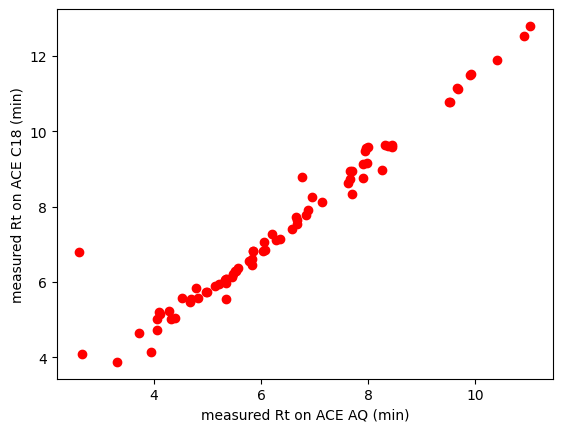

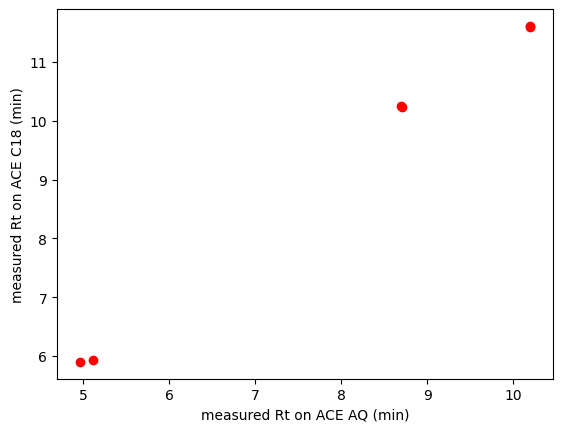

(77, 1)
(77, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE AQ
ACE C18 PFP


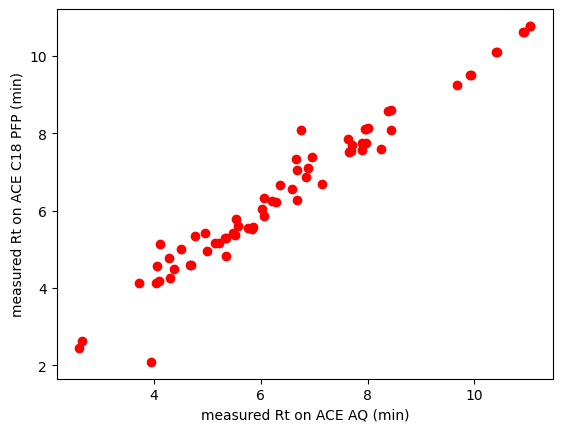

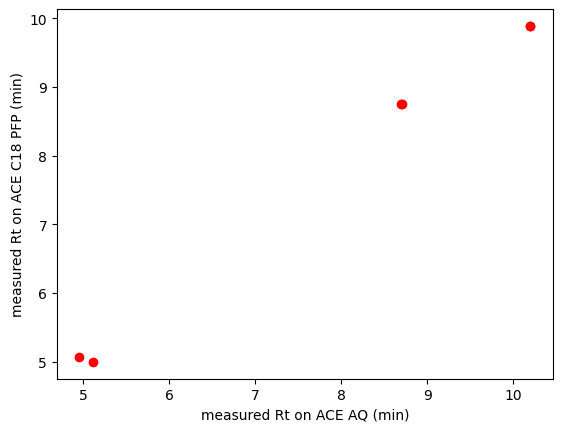

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE AQ
ACE CN


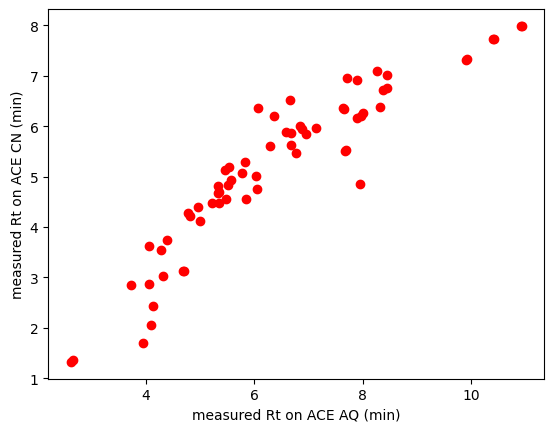

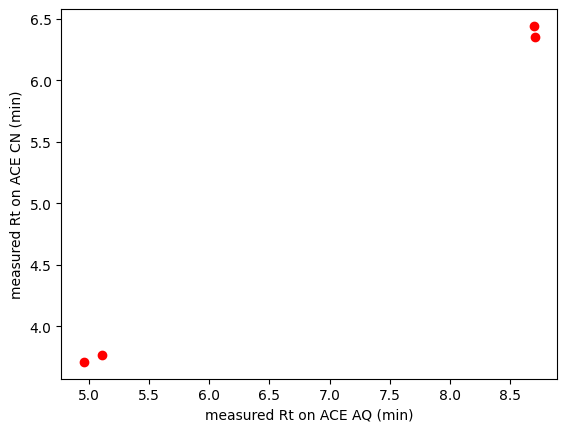

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE AQ
ACE Phenyl


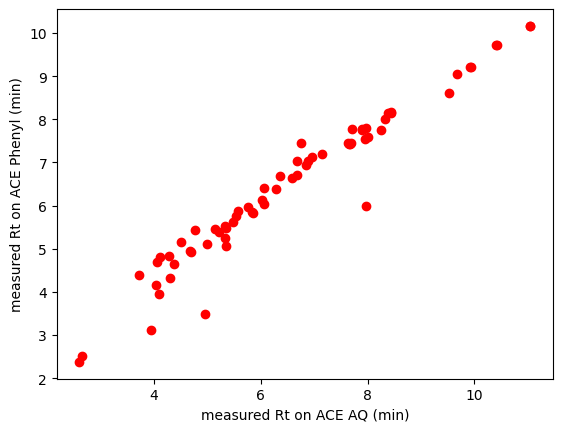

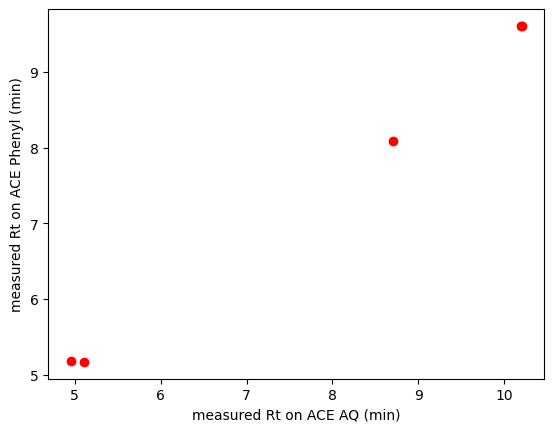

(66, 1)
(66, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE AQ
Ascentis F5


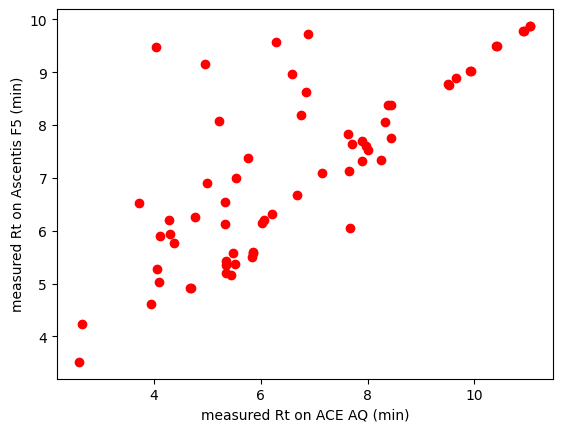

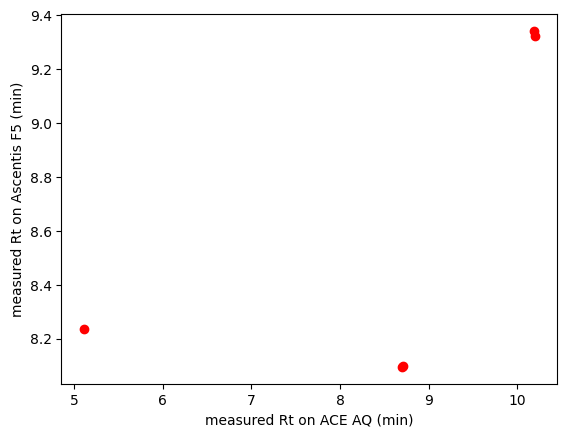

(64, 1)
(64, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE AQ
BEH C18 UPLC


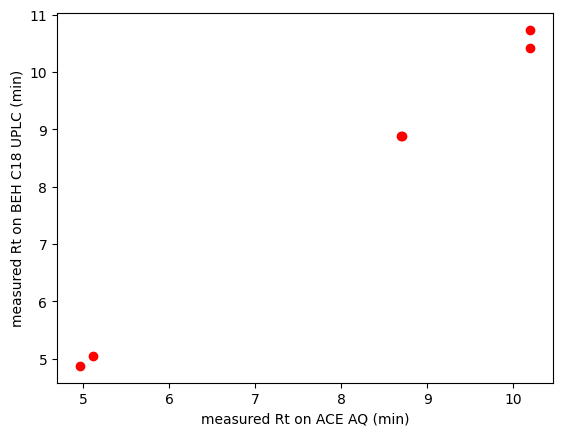

(76, 1)
(81, 1)
1/1 [==============================] - 0s 78ms/step
ACE AQ
Bonus RP


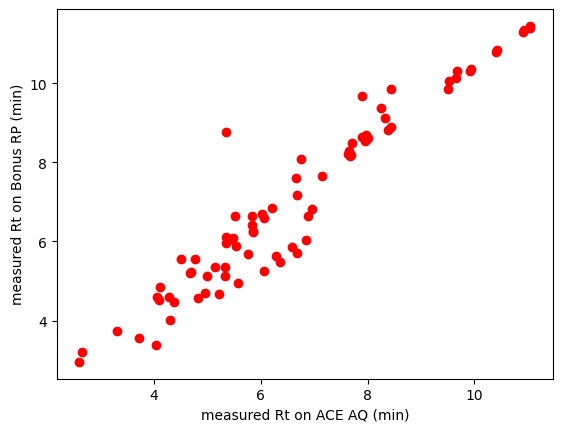

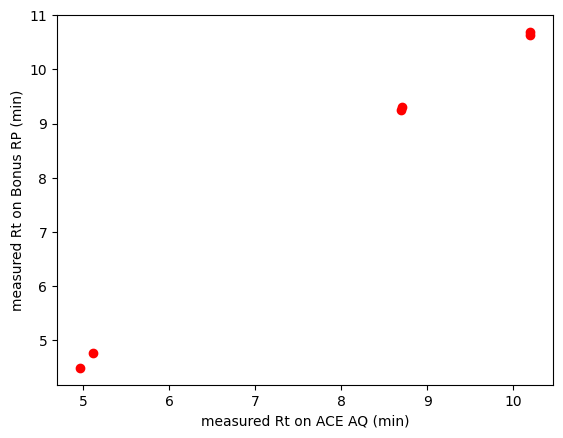

(78, 1)
(78, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE AQ
CSH C18 UPLC


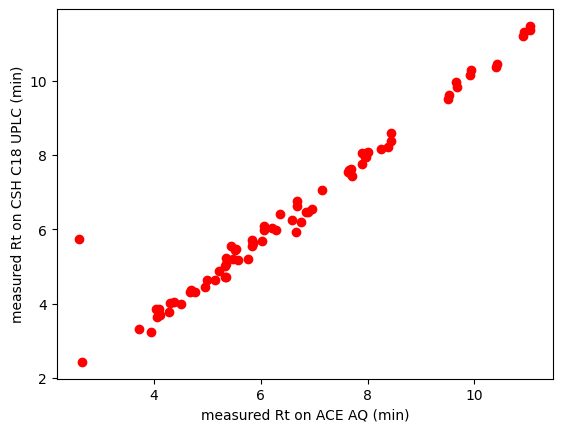

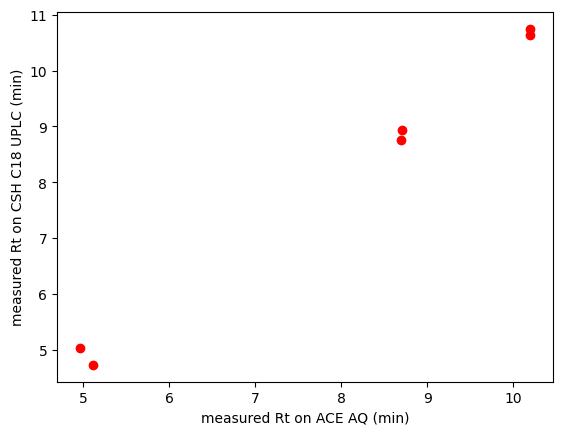

(76, 1)
(76, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE AQ
Cortecs C18+


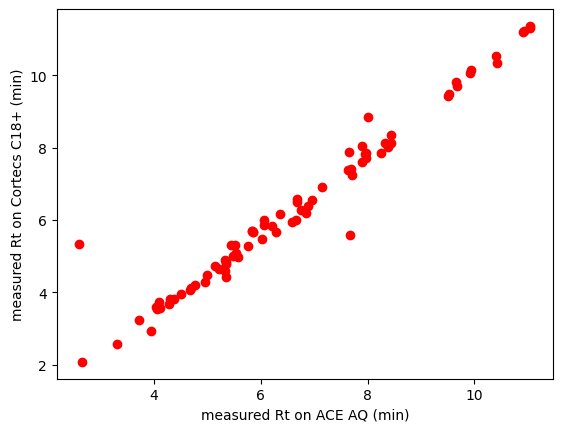

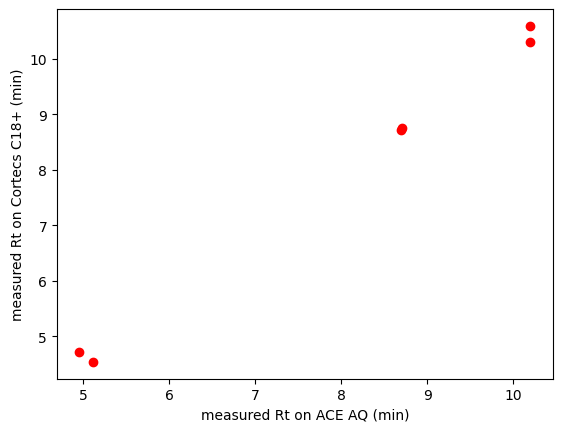

(78, 1)
(78, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE AQ
Eclipse RRHD Plus C18


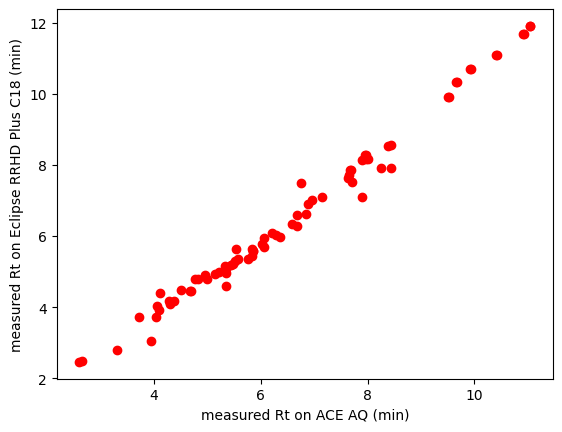

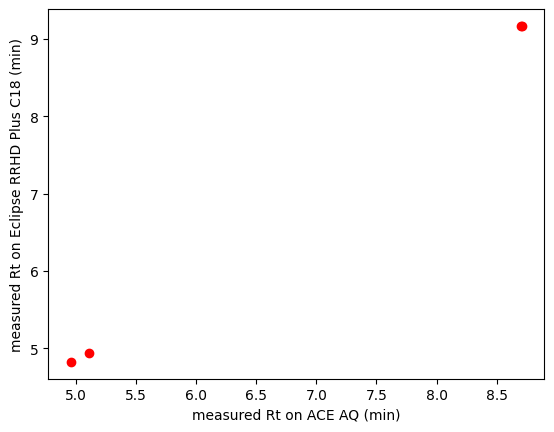

(76, 1)
(76, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 64ms/step
ACE AQ
Hypersil PFP


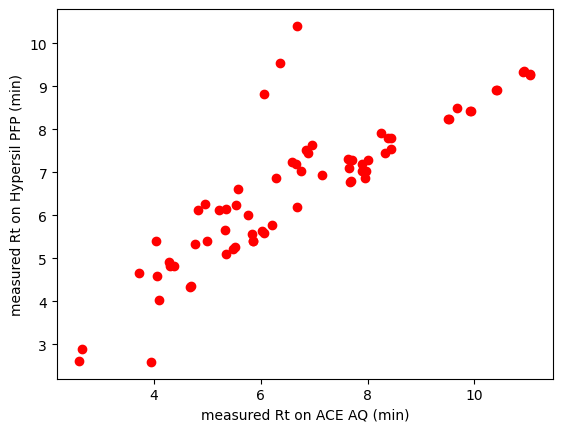

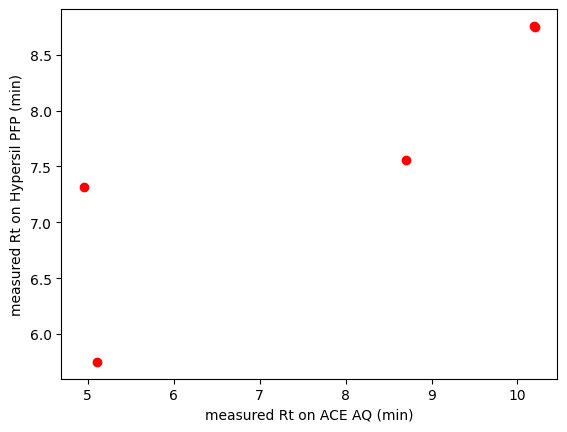

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE AQ
Hypersil aQ


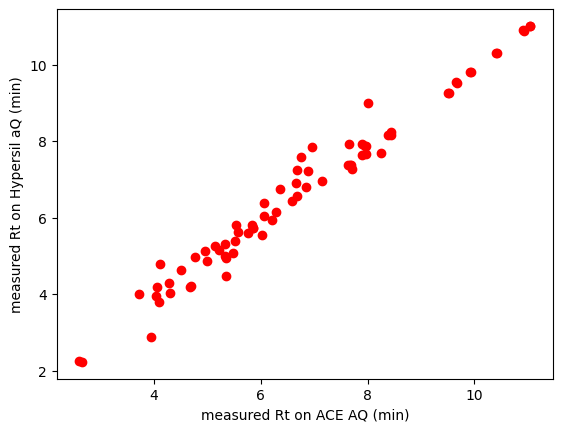

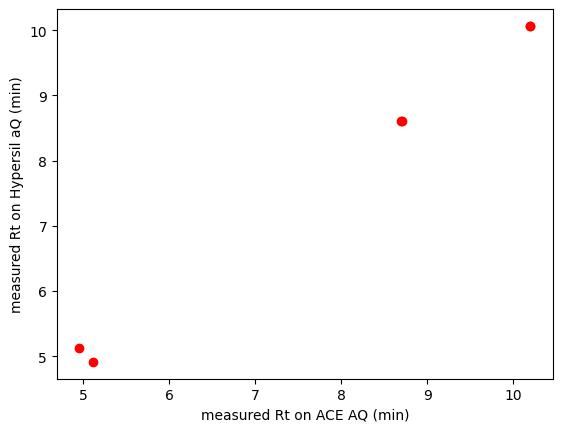

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE AQ
Kinetix XB-C18


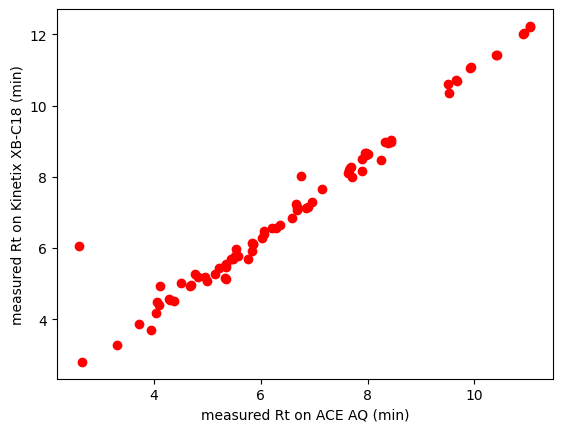

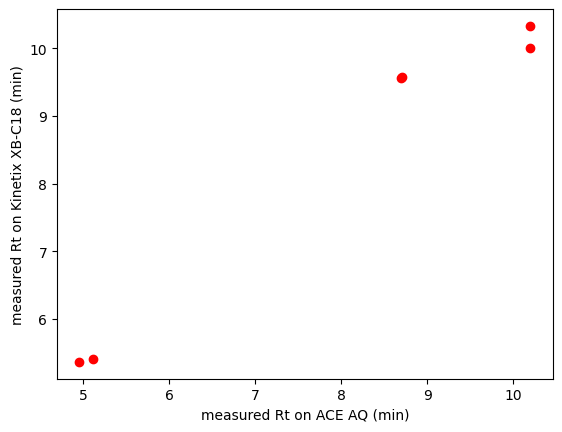

(79, 1)
(79, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE AQ
Poroshell EC-C18


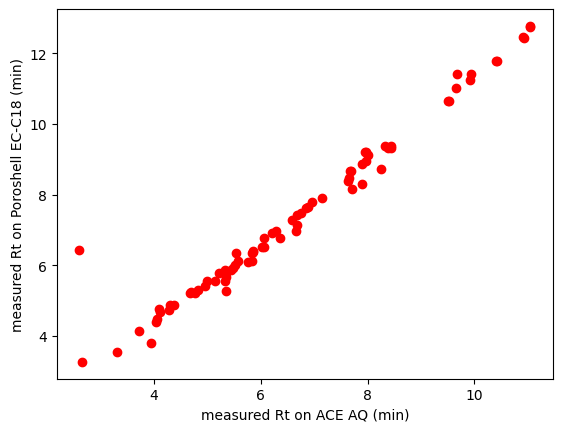

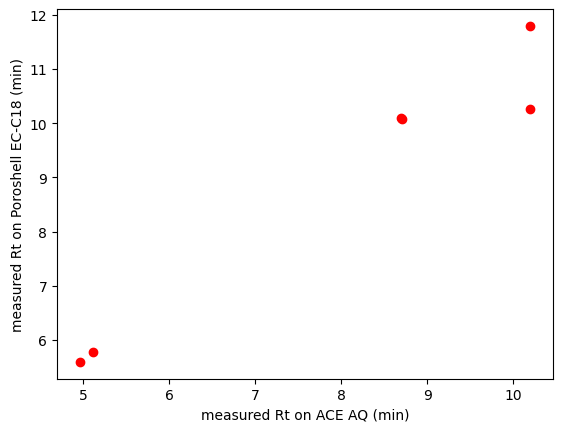

(78, 1)
(78, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE AQ
Poroshell SB-AQ


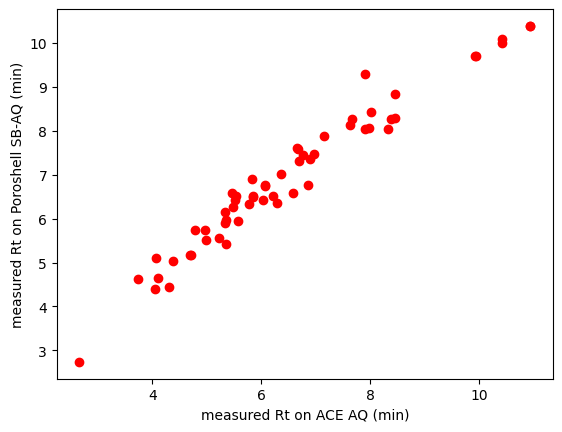

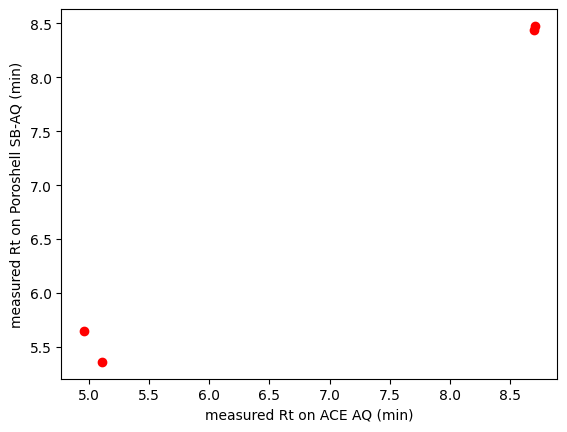

(57, 1)
(57, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE AQ
Shield RP18


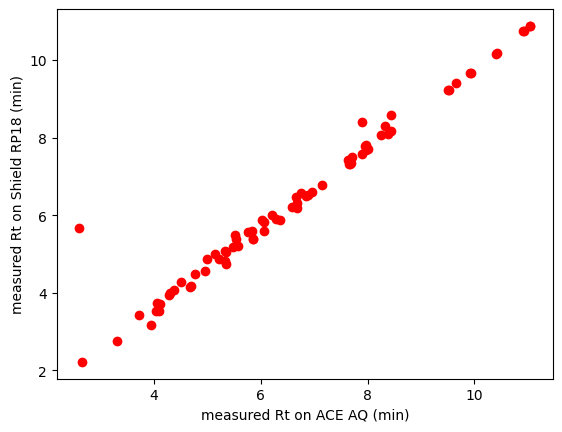

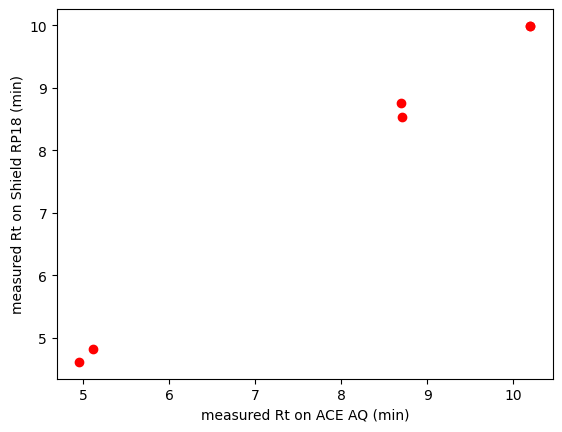

(74, 1)
(74, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE AQ
Zorbax Extend C18


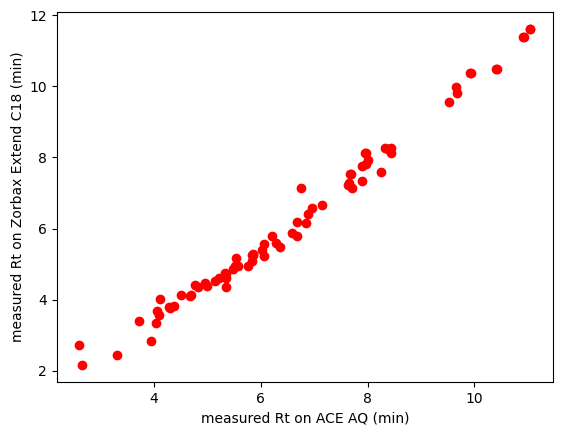

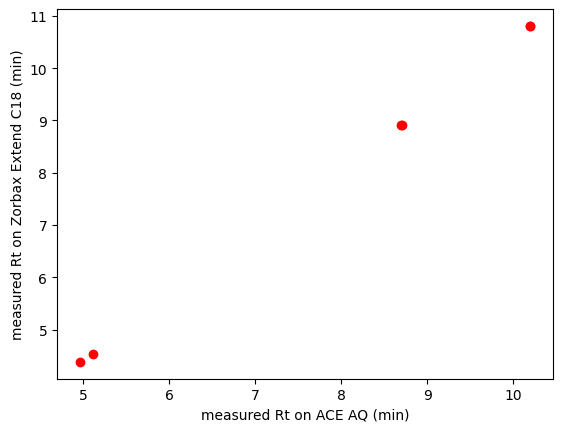

(75, 1)
(75, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE AQ
Zorbax SB C8


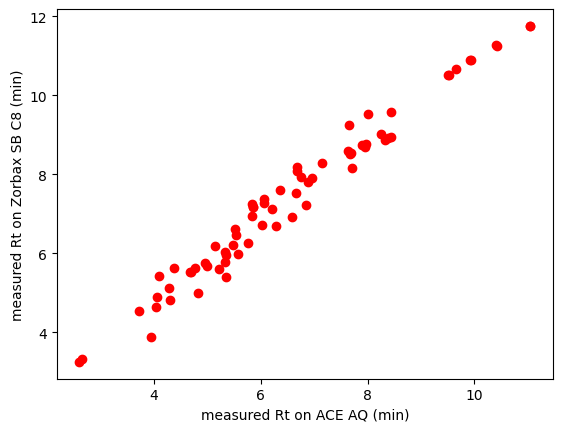

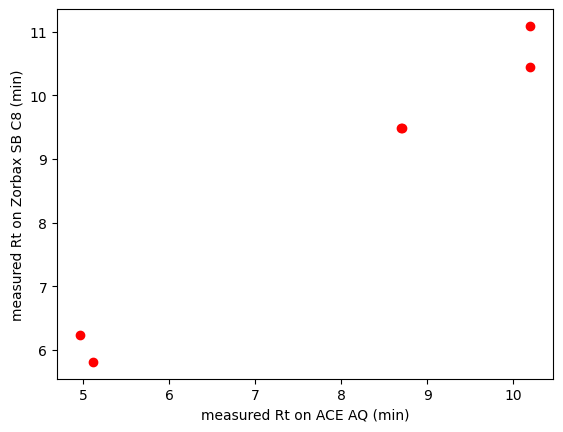

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE AQ
Zorbax SB-CN


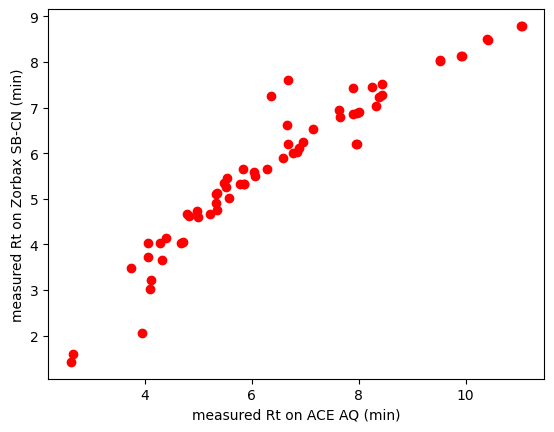

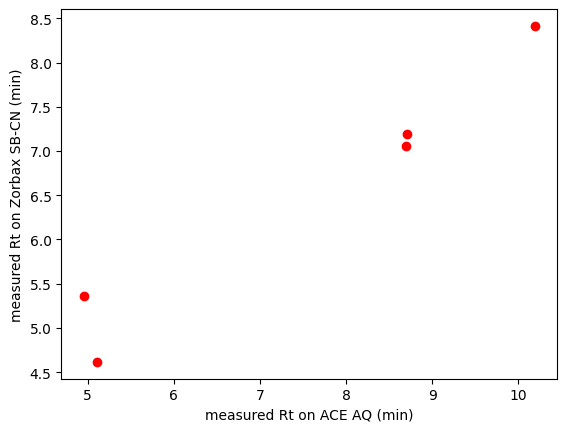

(64, 1)
(64, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18
ACE C18 PFP


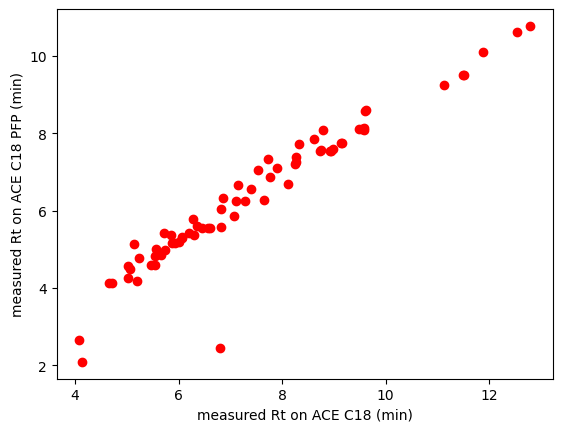

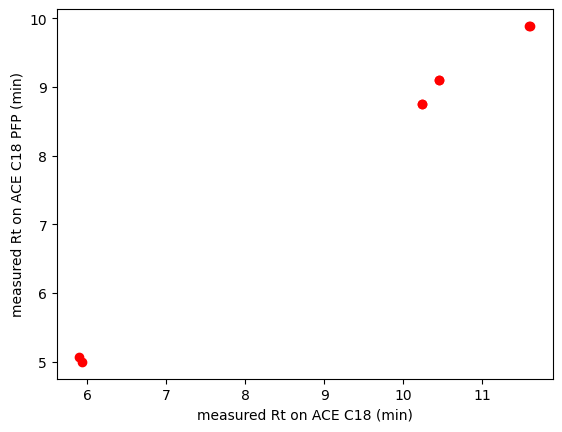

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18
ACE CN


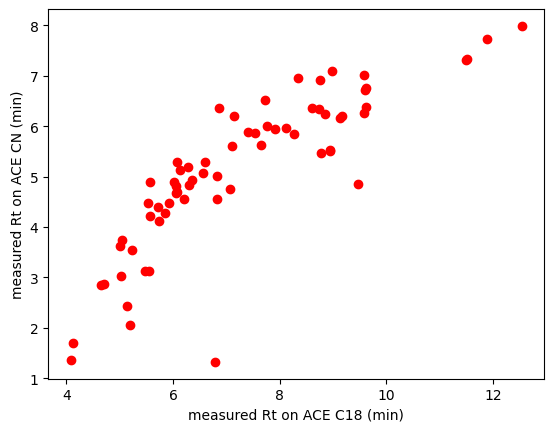

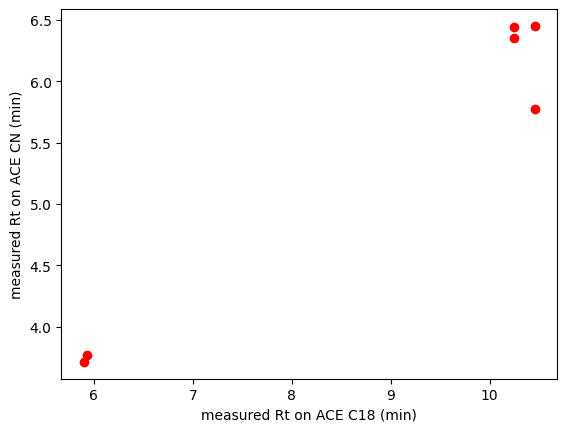

(67, 1)
(67, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE C18
ACE Phenyl


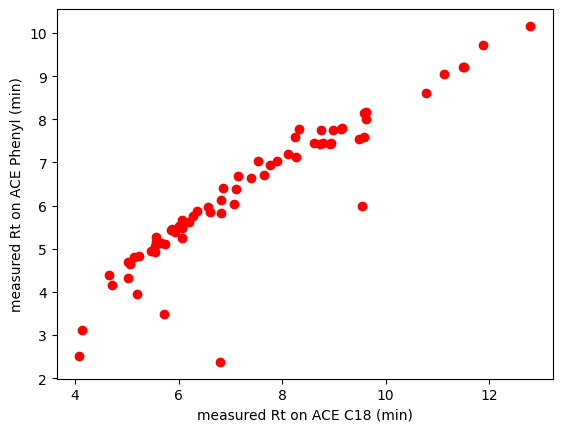

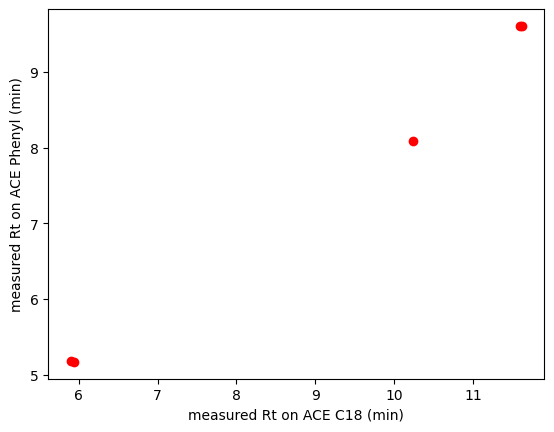

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE C18
Ascentis F5


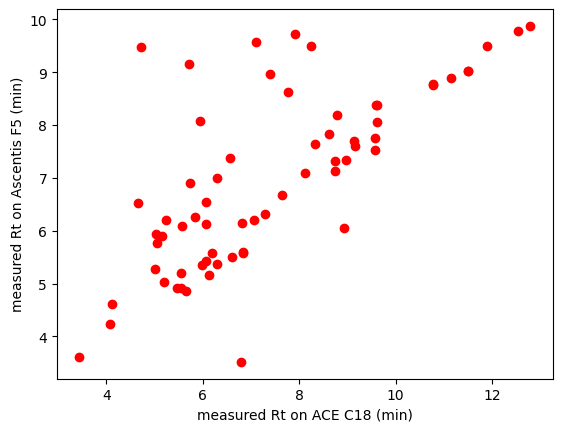

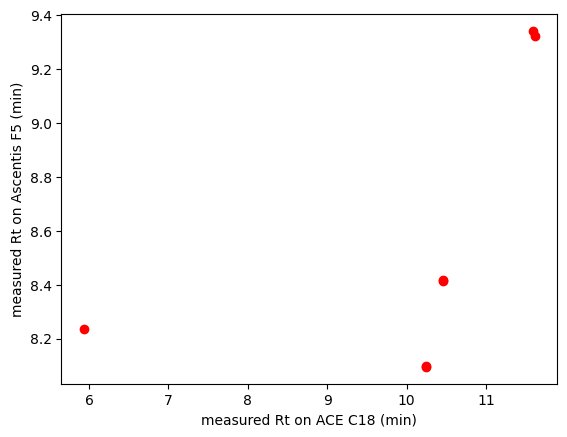

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE C18
BEH C18 UPLC


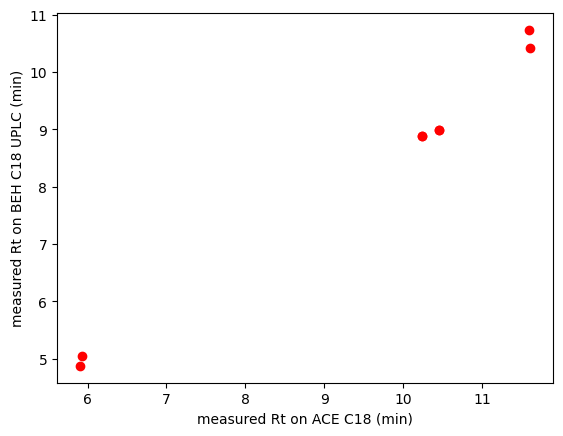

(80, 1)
(85, 1)
1/1 [==============================] - 0s 63ms/step
ACE C18
Bonus RP


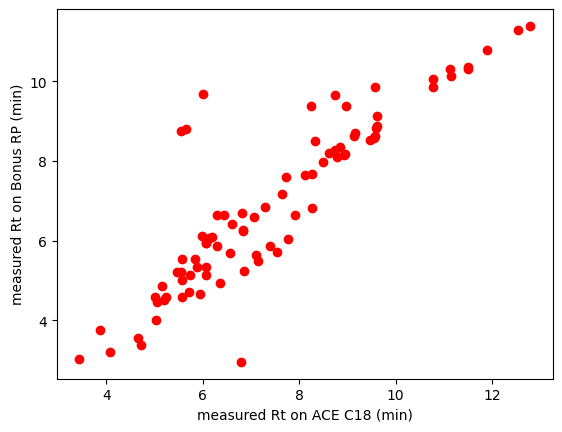

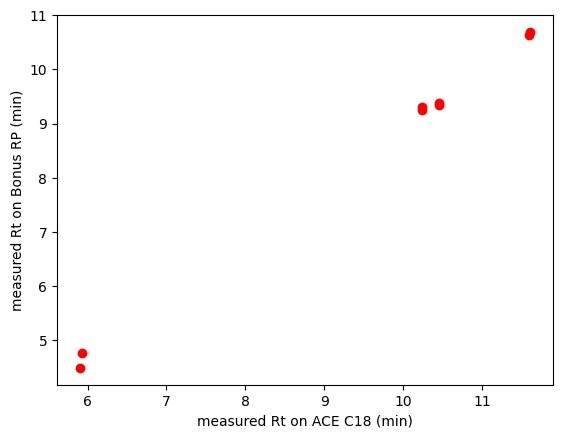

(84, 1)
(84, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18
CSH C18 UPLC


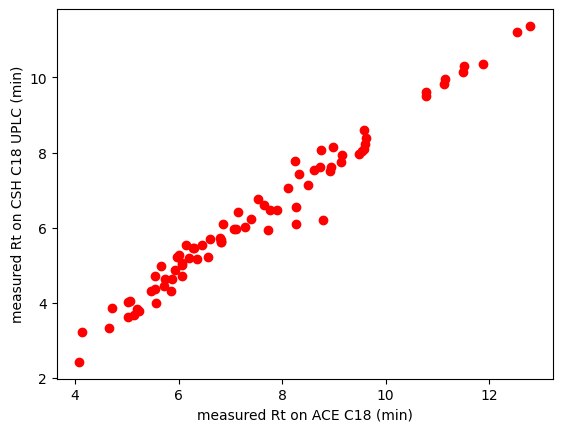

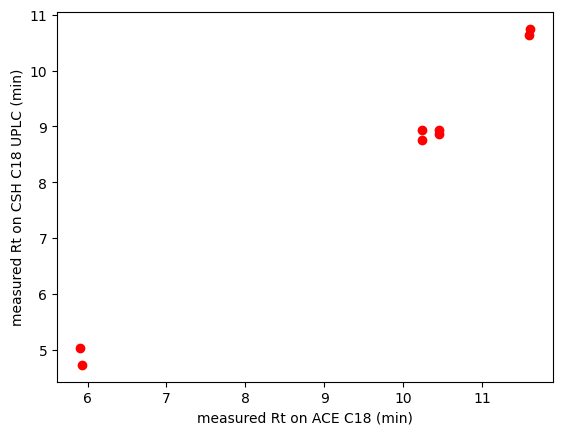

(78, 1)
(78, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18
Cortecs C18+


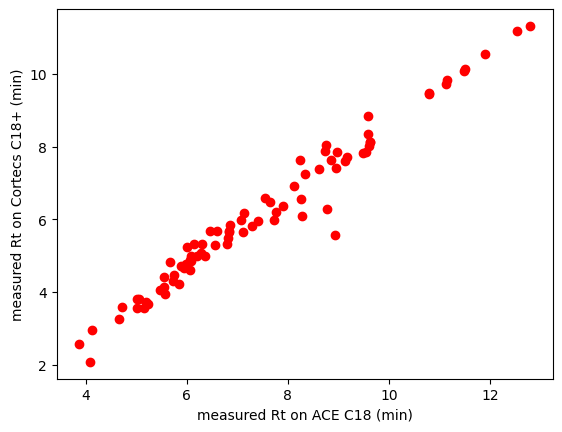

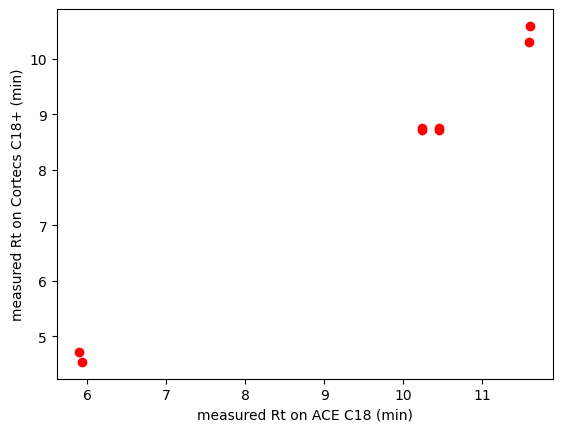

(81, 1)
(81, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
ACE C18
Eclipse RRHD Plus C18


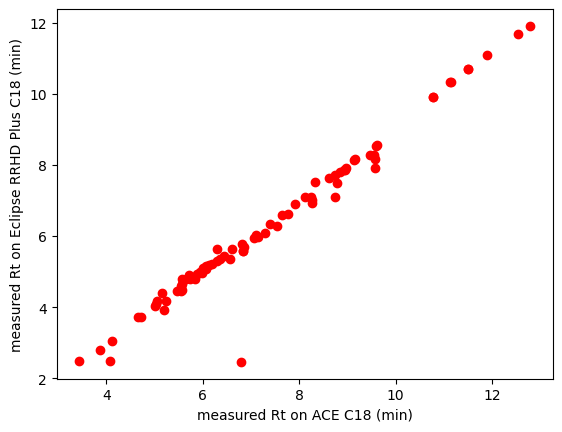

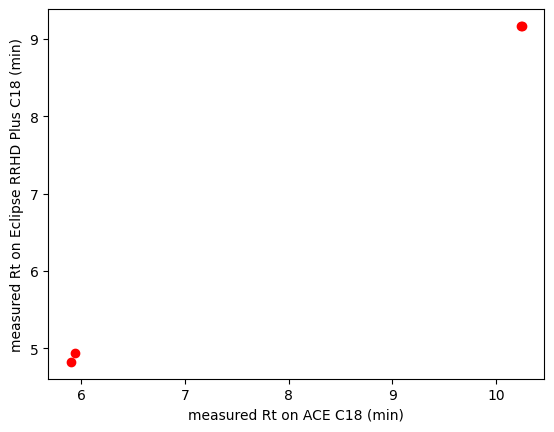

(80, 1)
(80, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18
Hypersil PFP


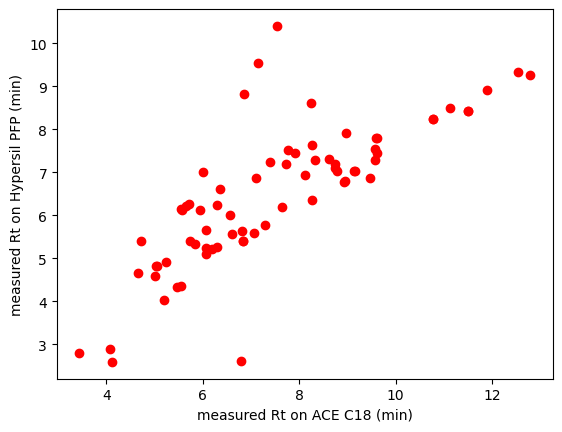

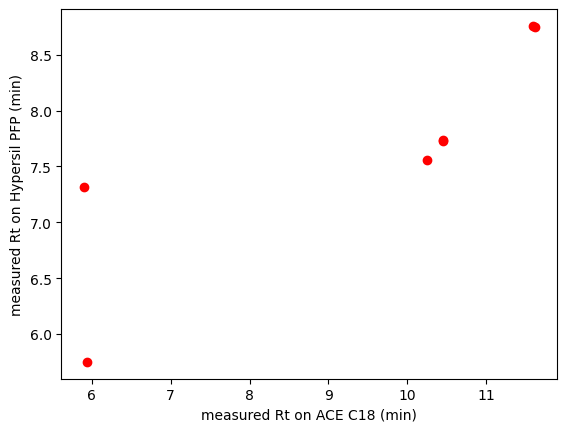

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 72ms/step
ACE C18
Hypersil aQ


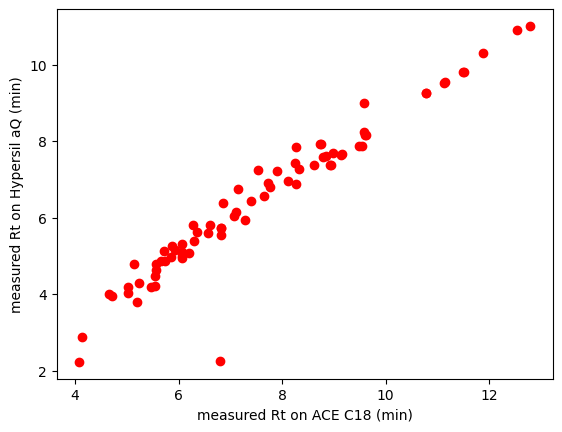

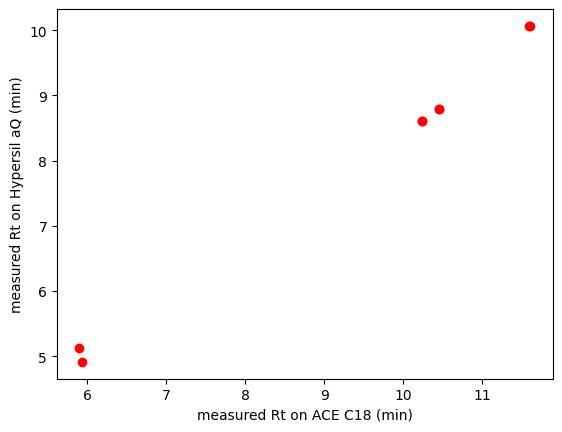

(75, 1)
(75, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE C18
Kinetix XB-C18


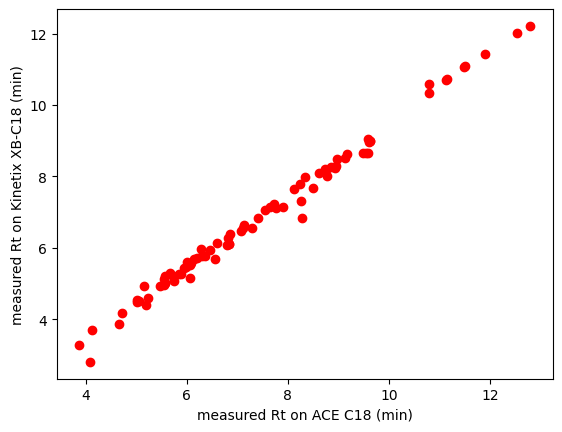

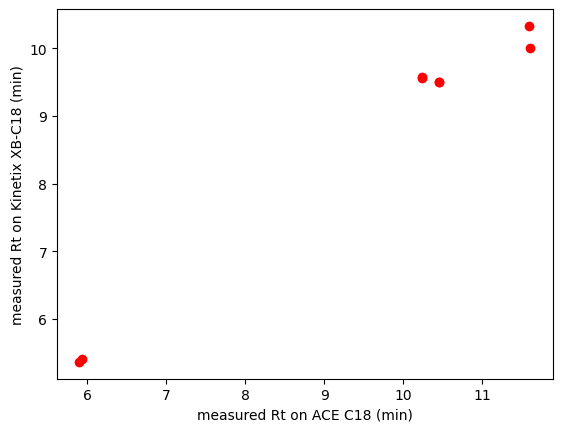

(83, 1)
(83, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18
Poroshell EC-C18


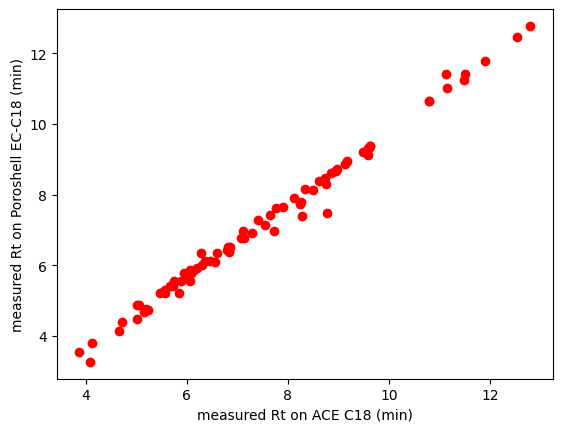

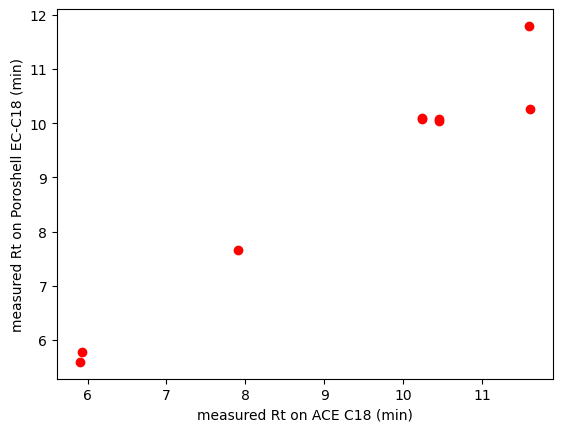

(83, 1)
(83, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18
Poroshell SB-AQ


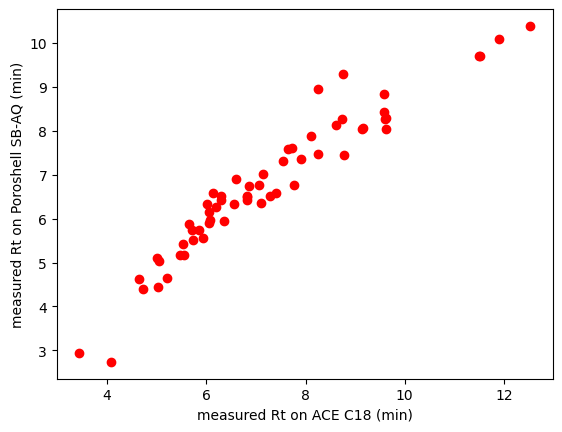

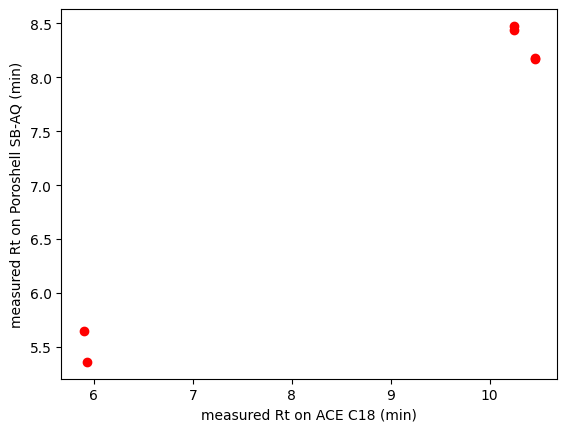

(59, 1)
(59, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18
Shield RP18


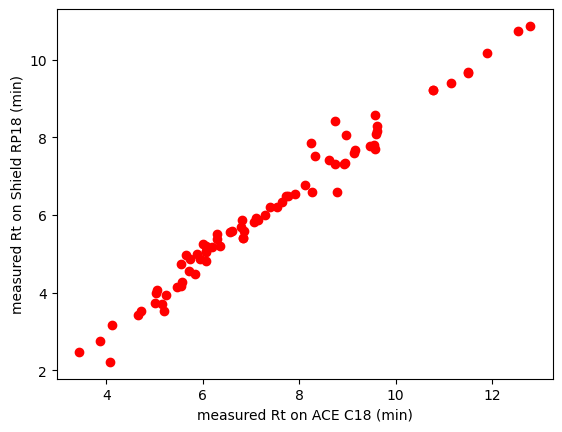

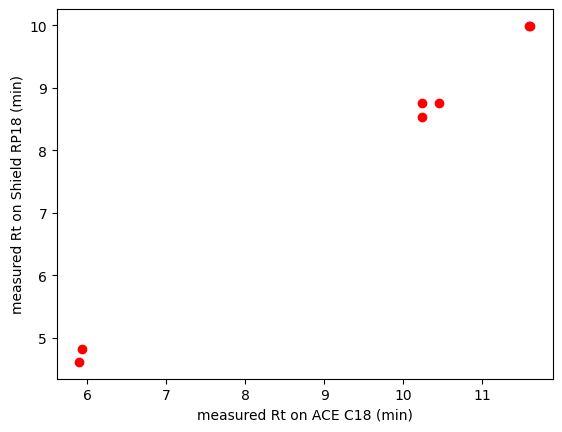

(76, 1)
(76, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18
Zorbax Extend C18


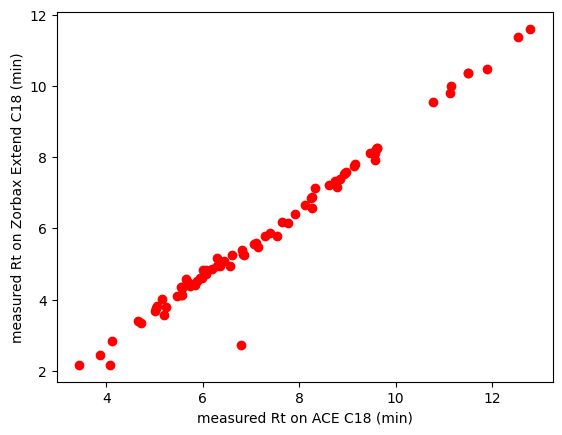

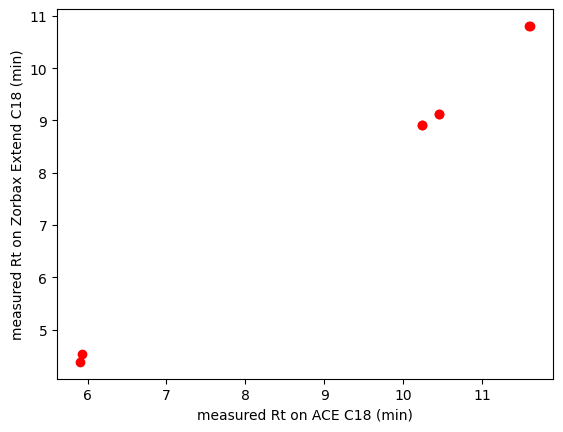

(80, 1)
(80, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE C18
Zorbax SB C8


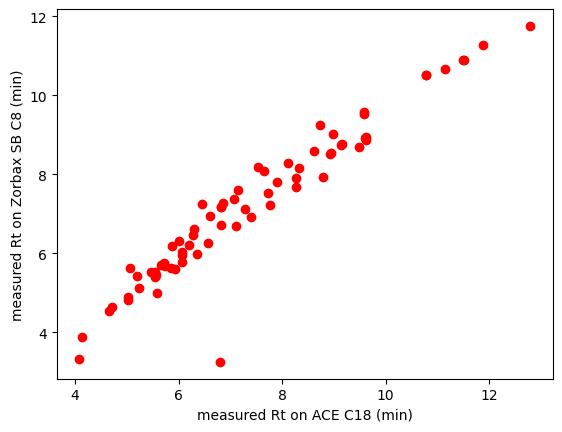

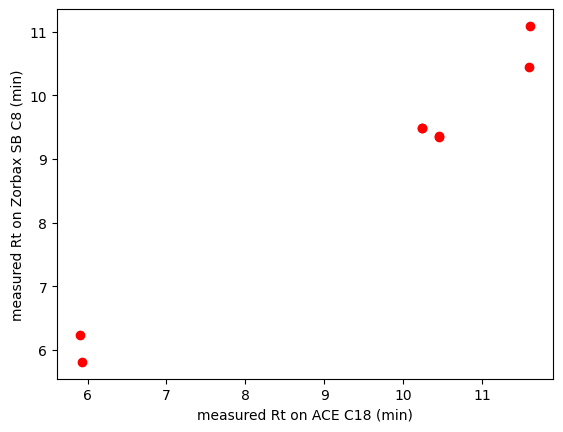

(71, 1)
(71, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 70ms/step
ACE C18
Zorbax SB-CN


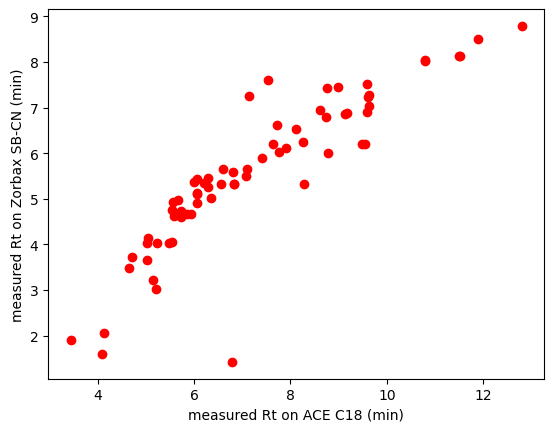

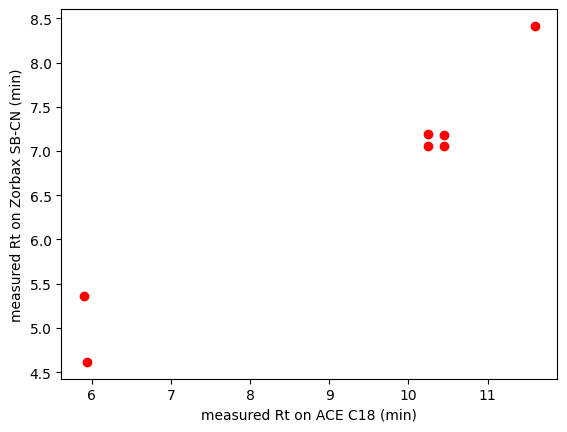

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 85ms/step
ACE C18 PFP
ACE CN


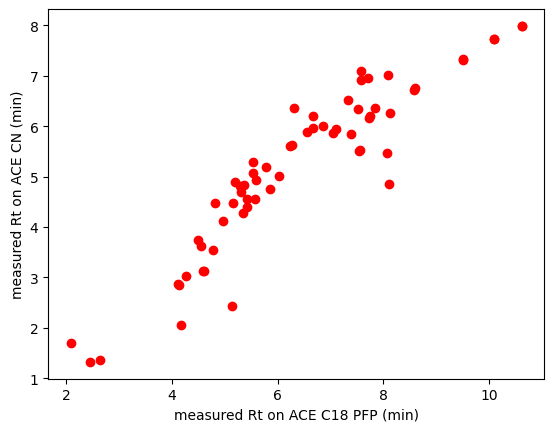

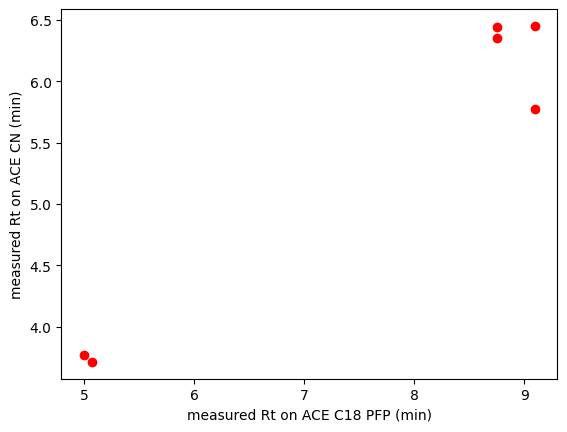

(62, 1)
(62, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 60ms/step
ACE C18 PFP
ACE Phenyl


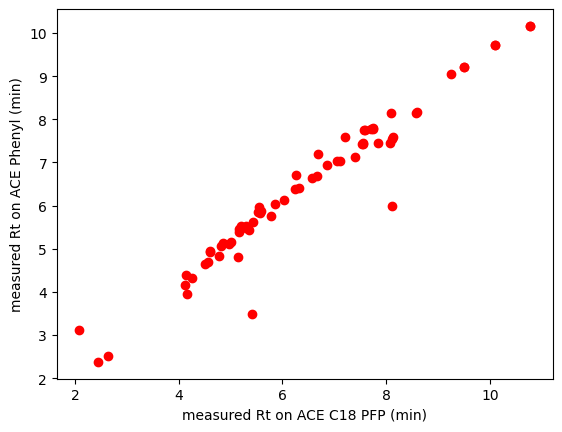

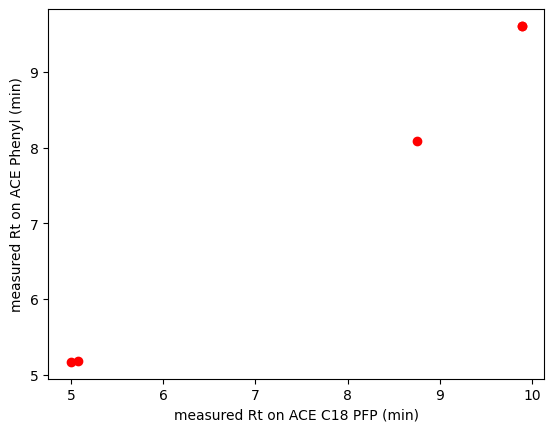

(66, 1)
(66, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18 PFP
Ascentis F5


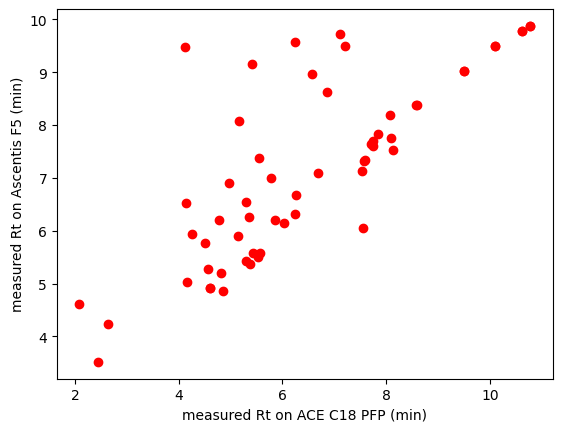

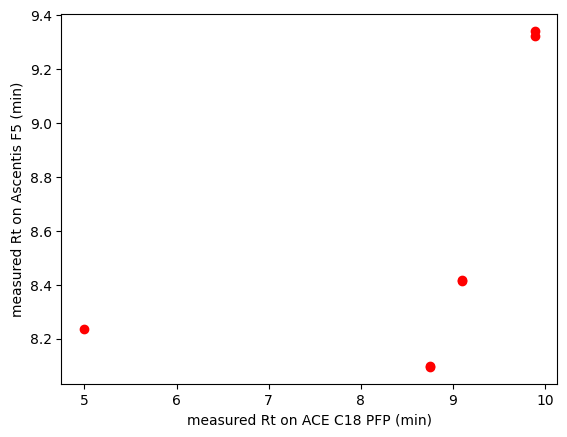

(58, 1)
(58, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18 PFP
BEH C18 UPLC


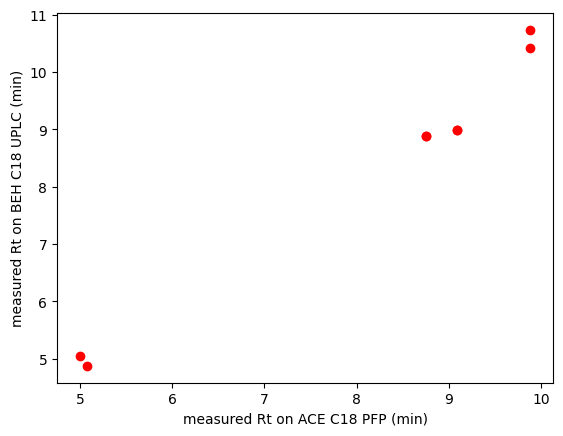

(71, 1)
(76, 1)
1/1 [==============================] - 0s 62ms/step
ACE C18 PFP
Bonus RP


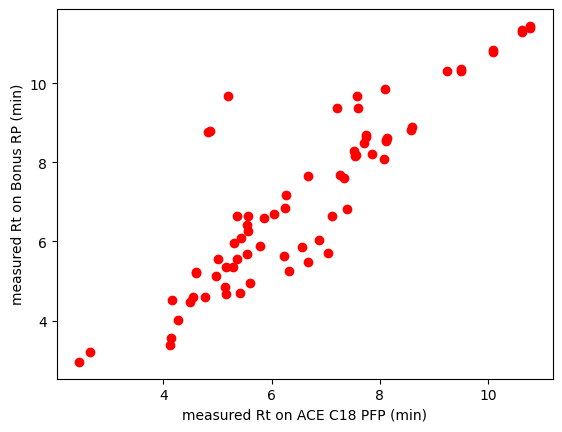

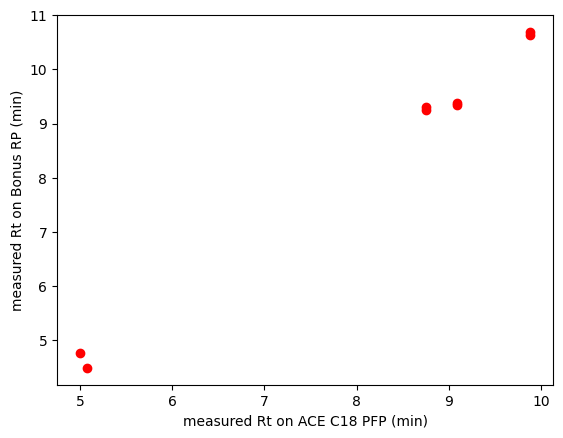

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18 PFP
CSH C18 UPLC


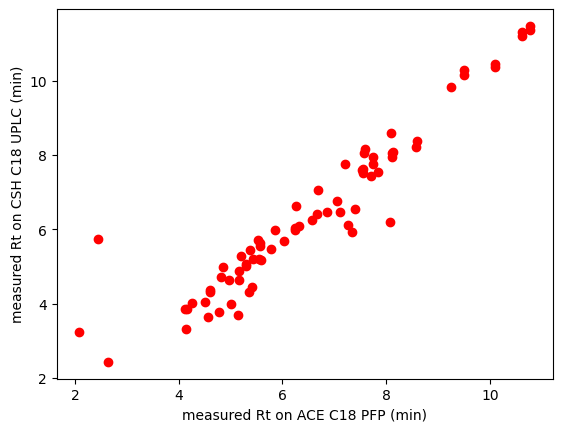

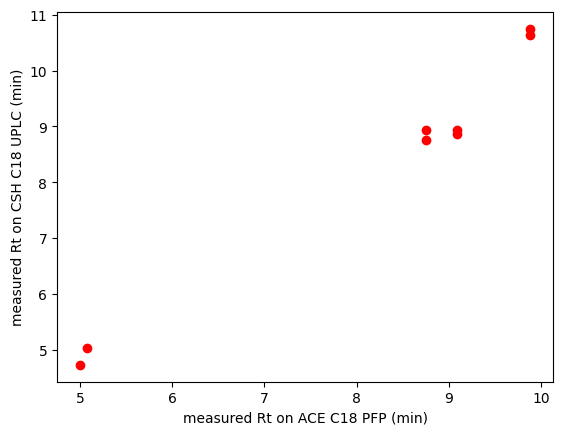

(73, 1)
(73, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE C18 PFP
Cortecs C18+


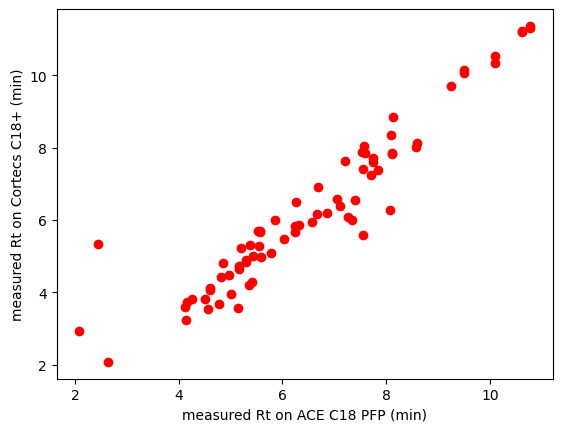

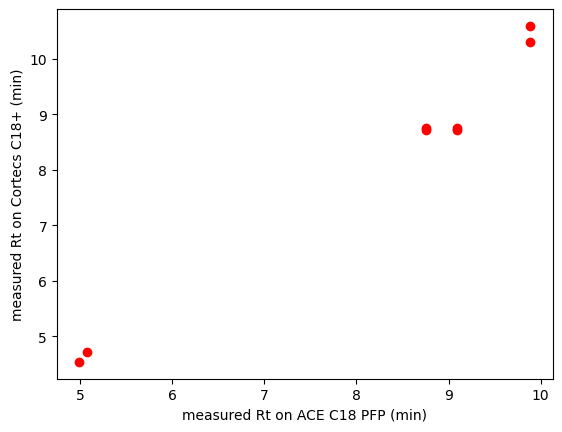

(73, 1)
(73, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18 PFP
Eclipse RRHD Plus C18


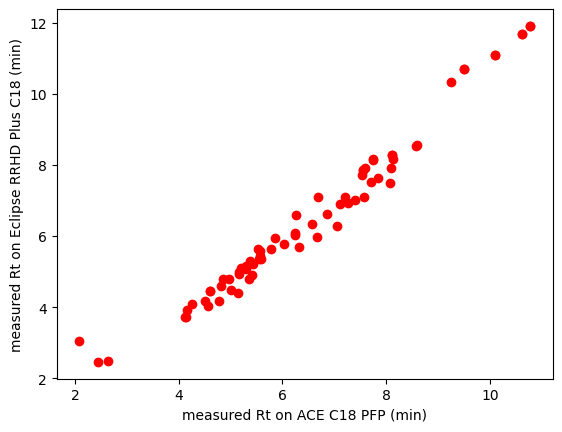

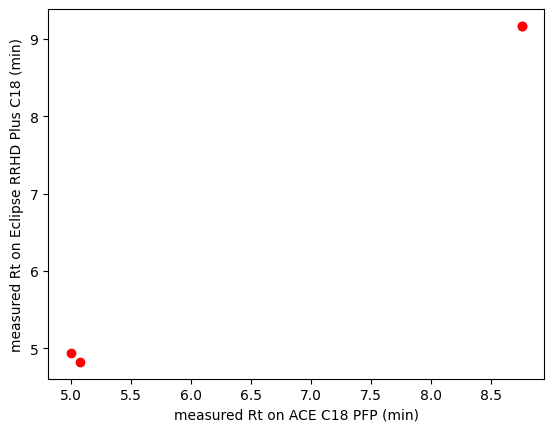

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18 PFP
Hypersil PFP


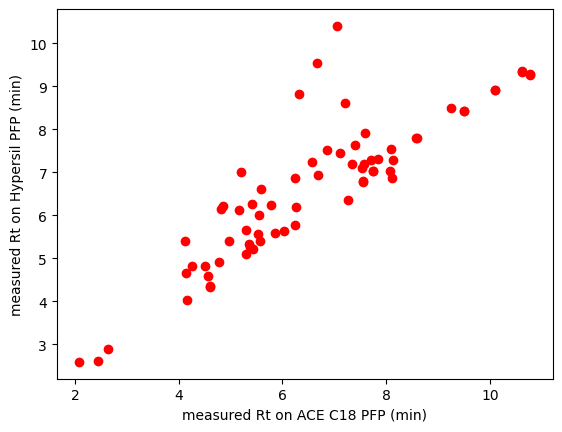

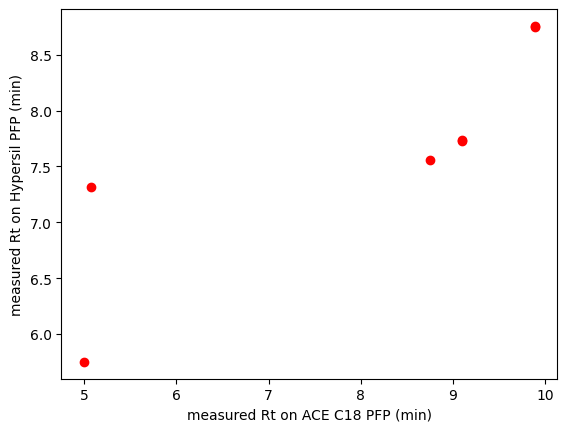

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18 PFP
Hypersil aQ


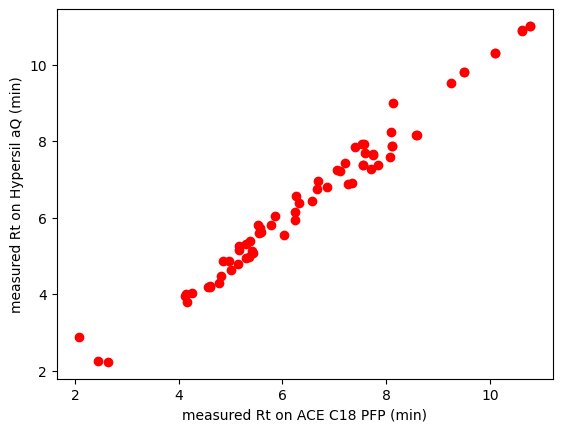

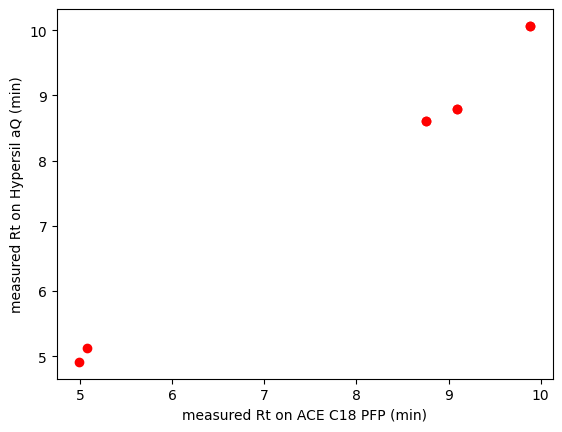

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18 PFP
Kinetix XB-C18


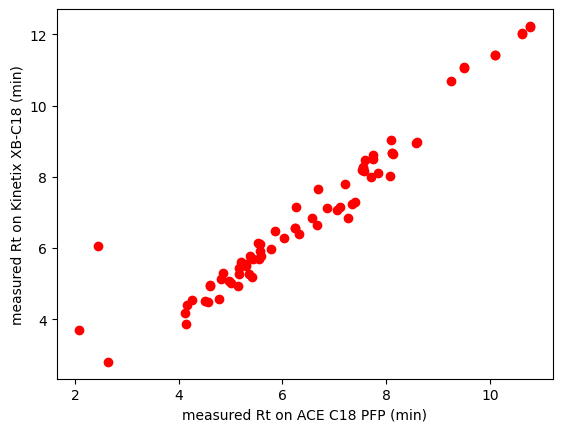

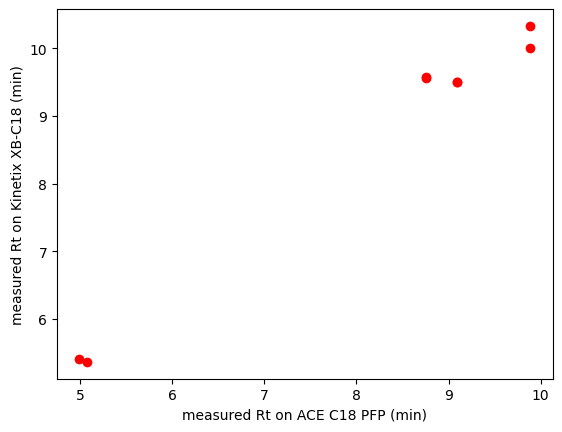

(73, 1)
(73, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
ACE C18 PFP
Poroshell EC-C18


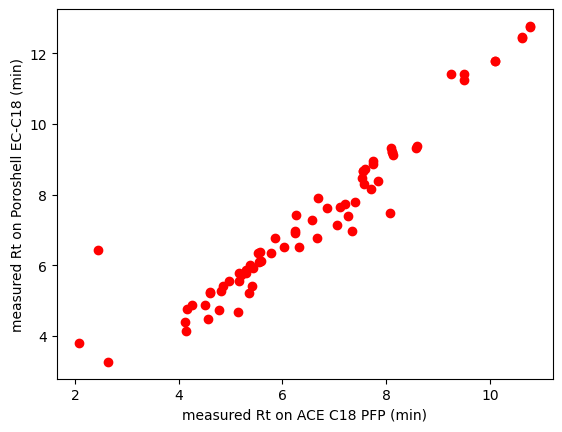

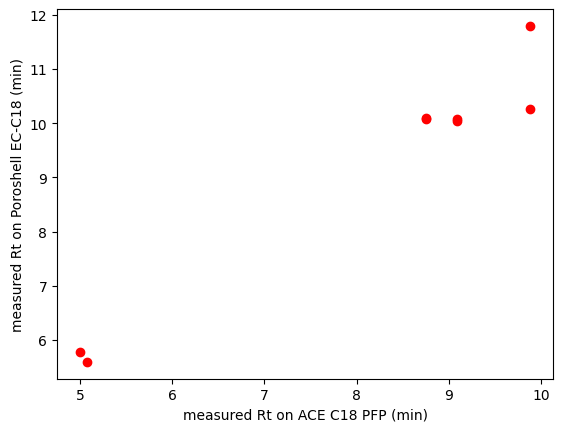

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE C18 PFP
Poroshell SB-AQ


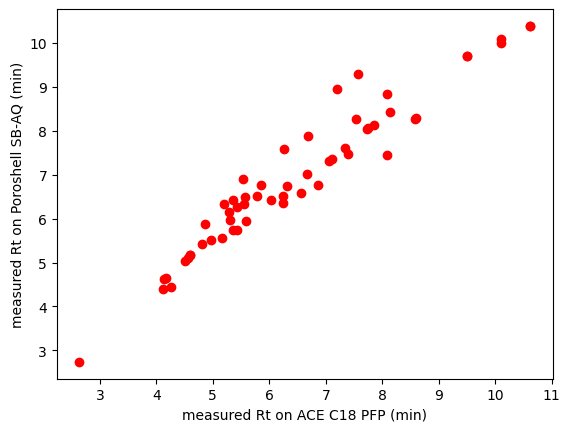

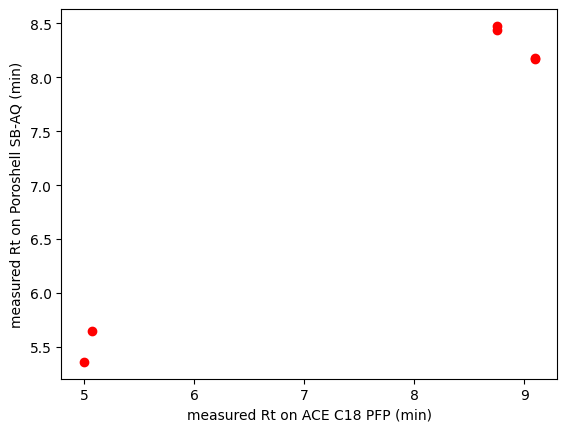

(56, 1)
(56, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18 PFP
Shield RP18


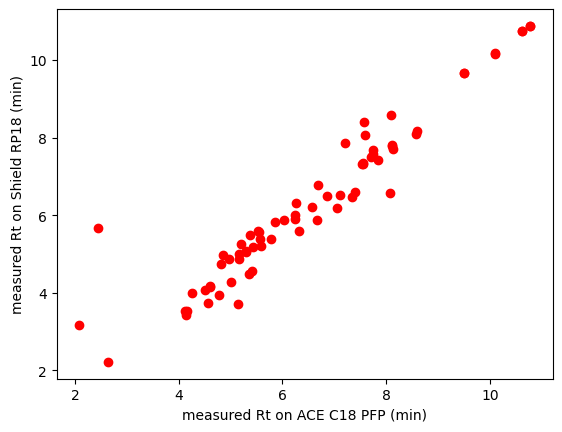

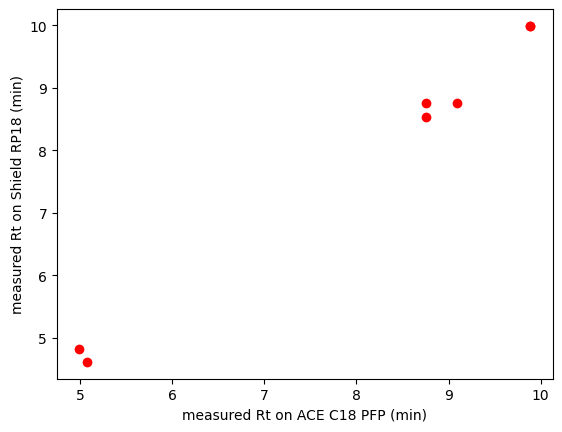

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18 PFP
Zorbax Extend C18


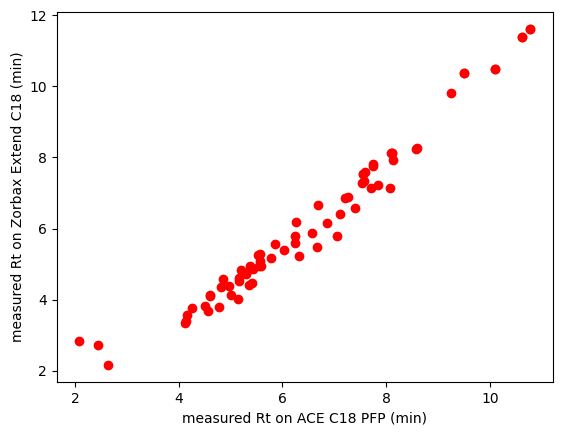

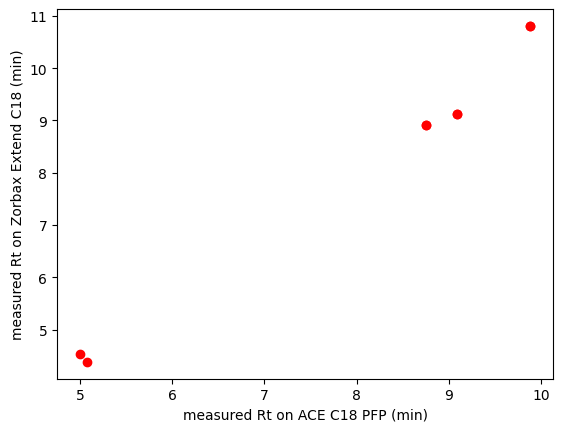

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE C18 PFP
Zorbax SB C8


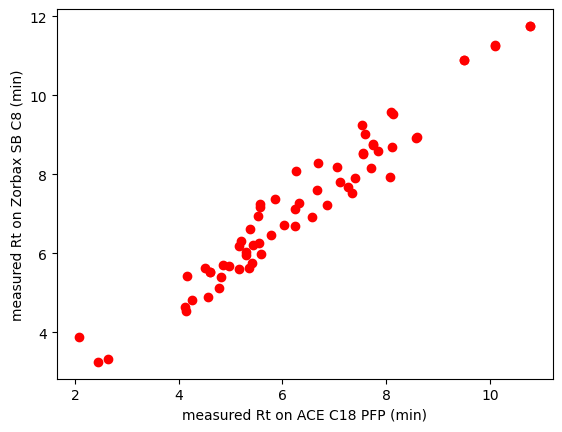

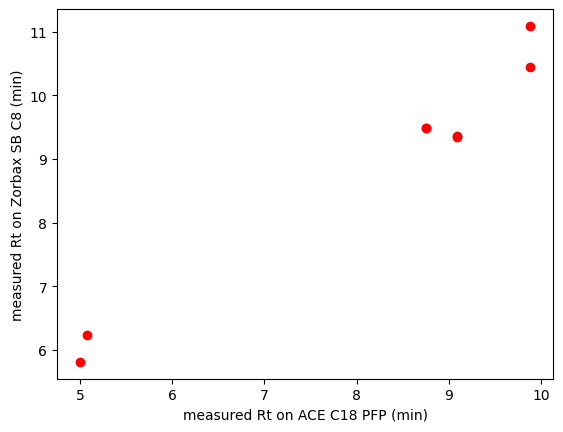

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE C18 PFP
Zorbax SB-CN


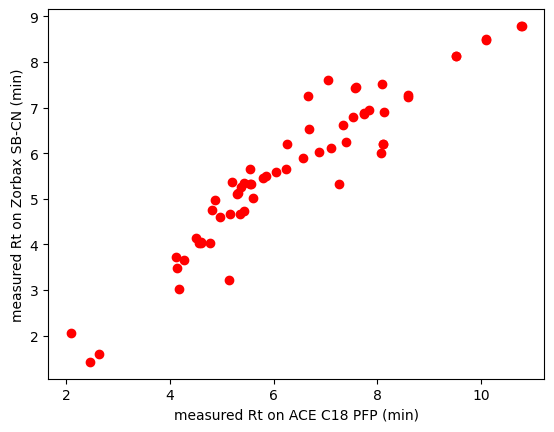

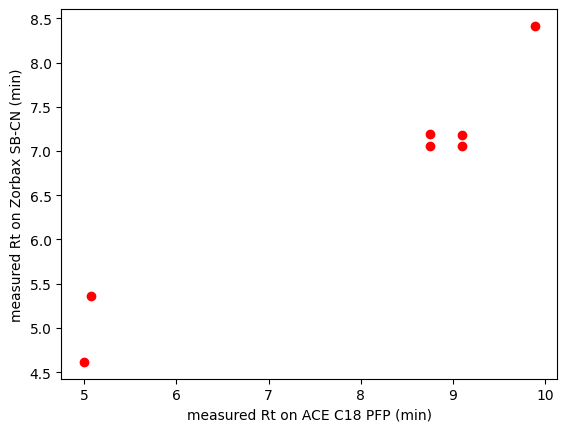

(61, 1)
(61, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
ACE CN
ACE Phenyl


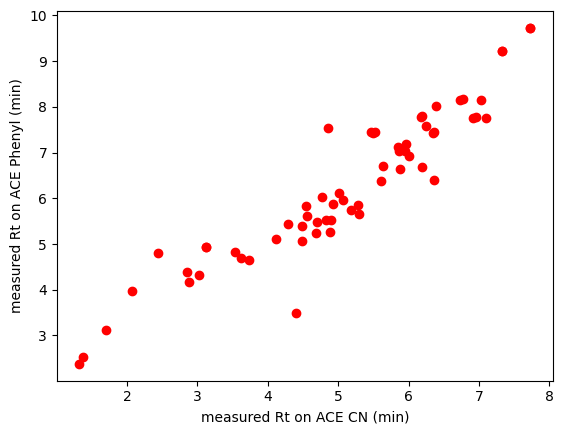

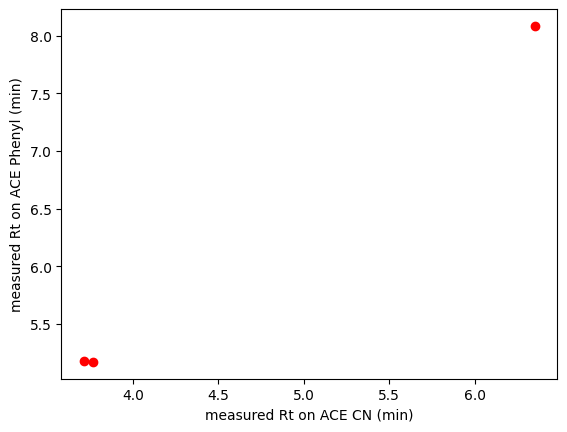

(62, 1)
(62, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 109ms/step
ACE CN
Ascentis F5


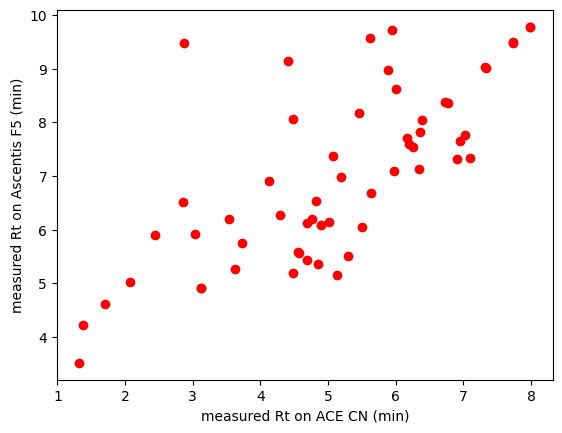

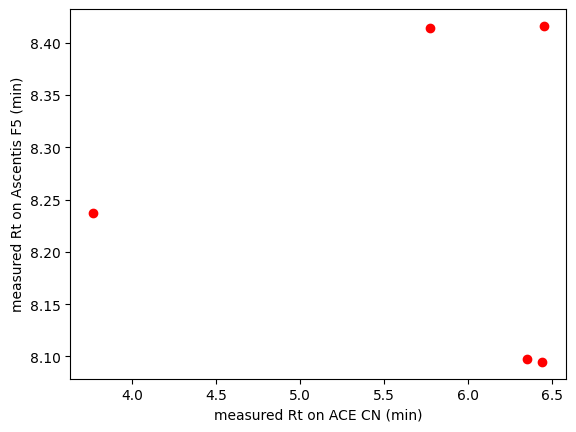

(57, 1)
(57, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE CN
BEH C18 UPLC


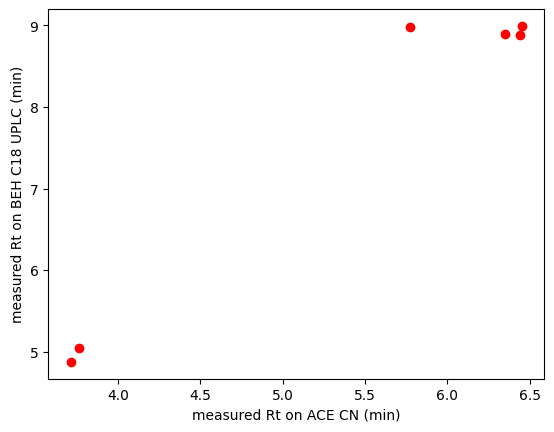

(67, 1)
(72, 1)
1/1 [==============================] - 0s 63ms/step
ACE CN
Bonus RP


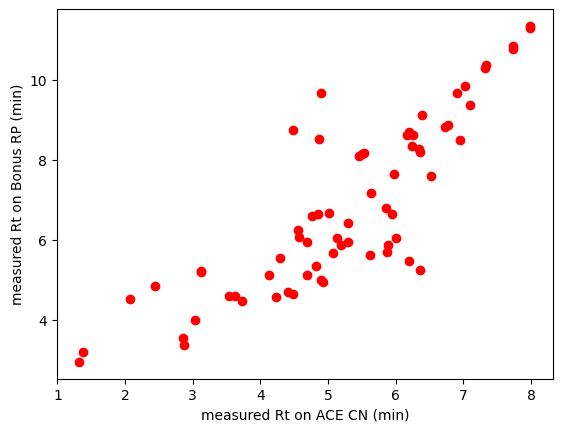

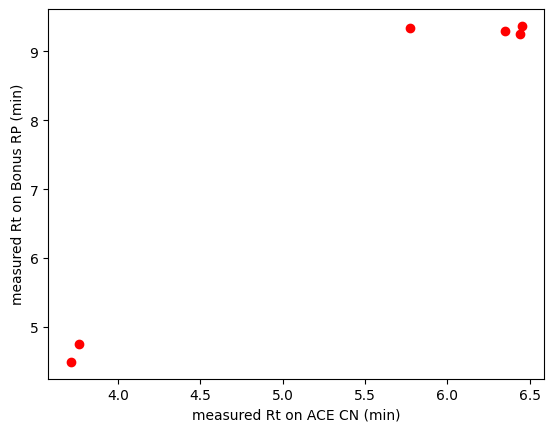

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE CN
CSH C18 UPLC


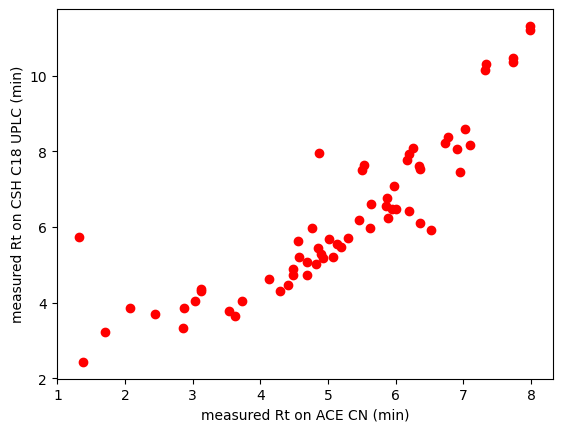

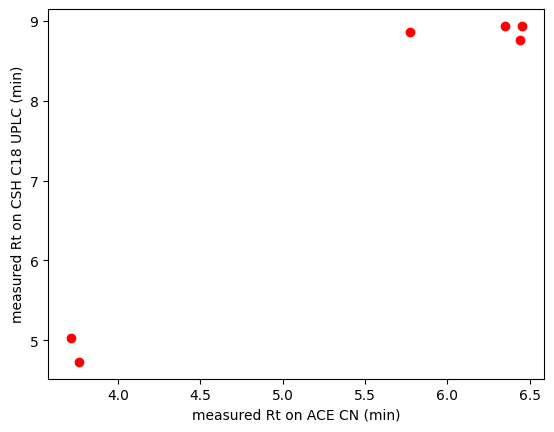

(64, 1)
(64, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE CN
Cortecs C18+


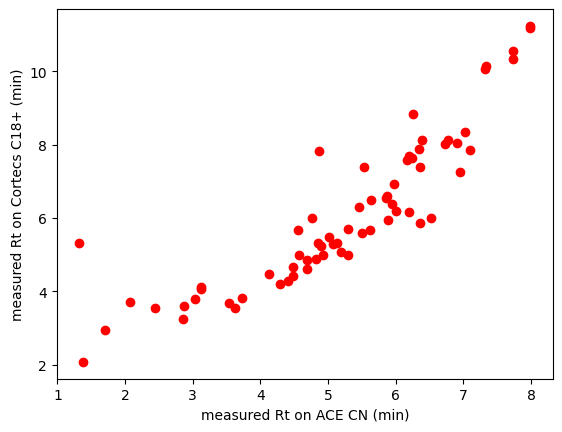

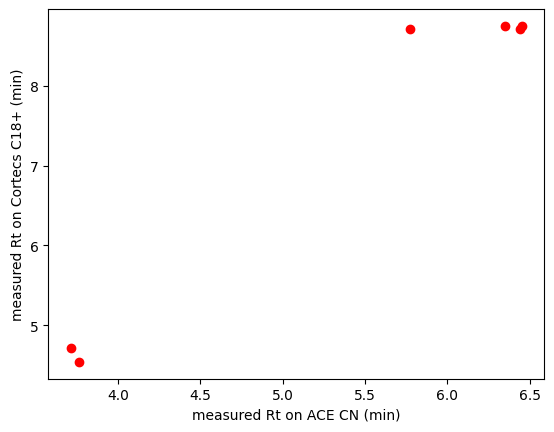

(67, 1)
(67, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE CN
Eclipse RRHD Plus C18


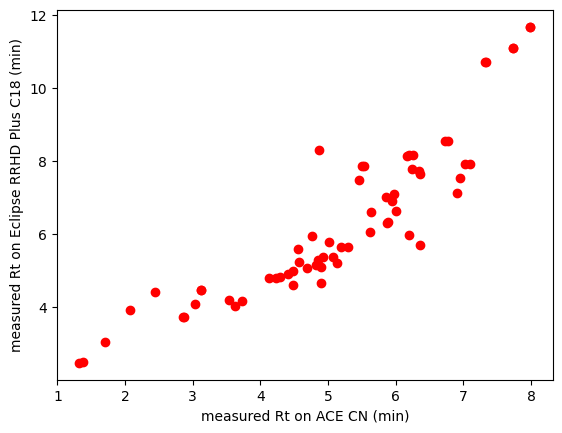

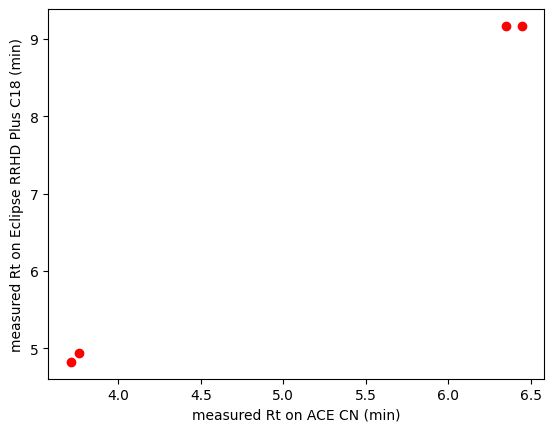

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE CN
Hypersil PFP


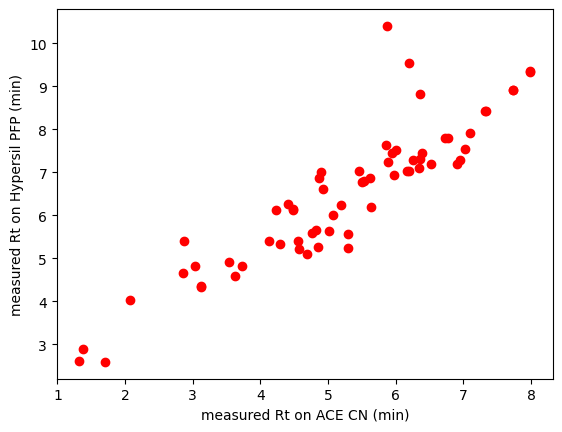

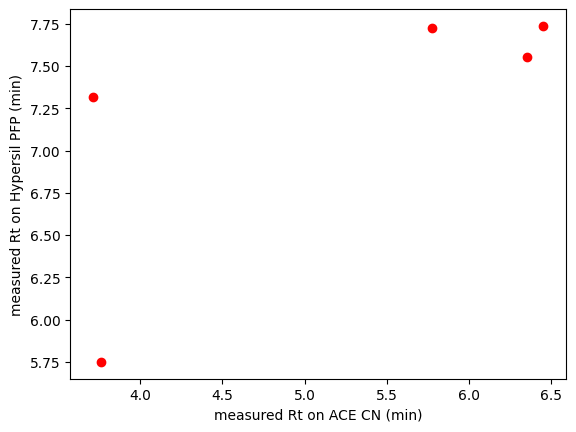

(64, 1)
(64, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE CN
Hypersil aQ


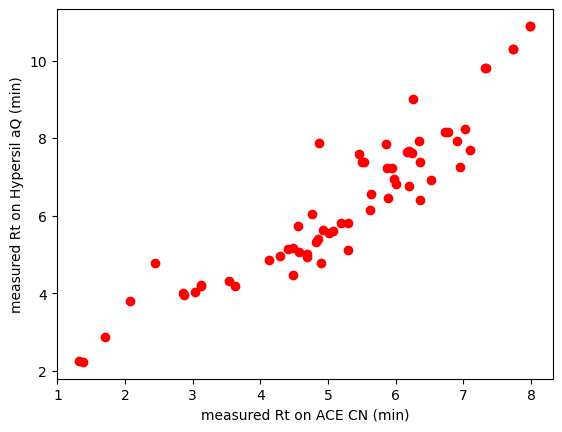

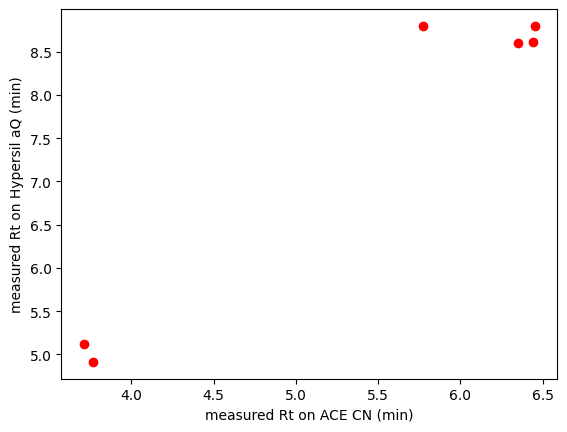

(64, 1)
(64, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE CN
Kinetix XB-C18


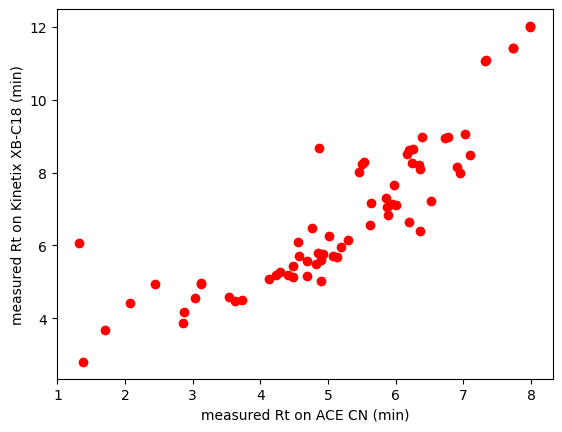

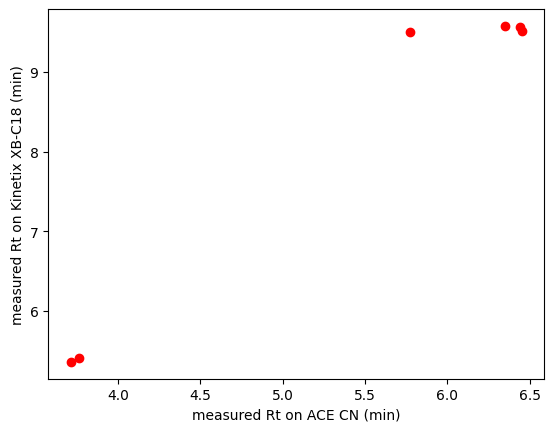

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE CN
Poroshell EC-C18


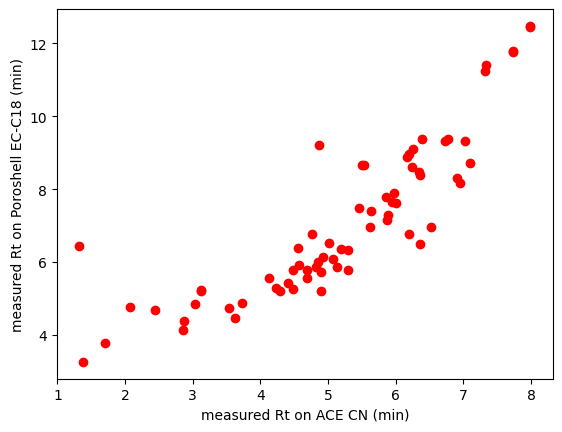

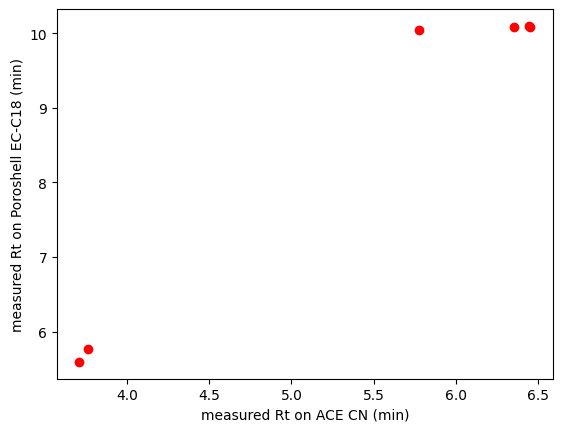

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE CN
Poroshell SB-AQ


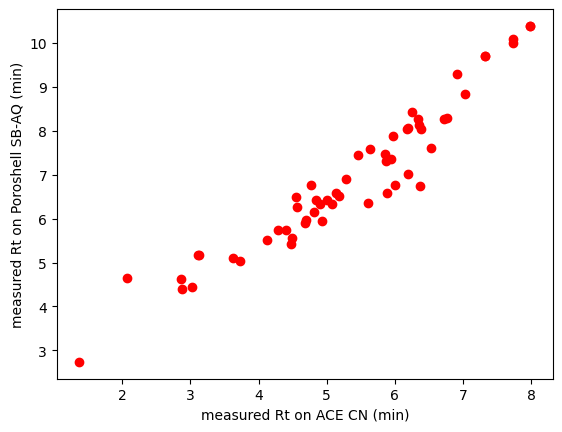

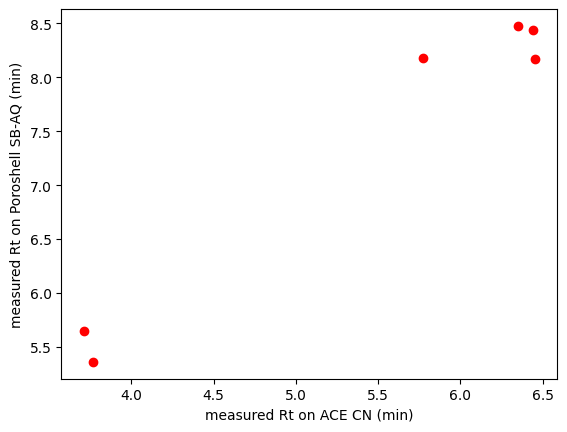

(56, 1)
(56, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE CN
Shield RP18


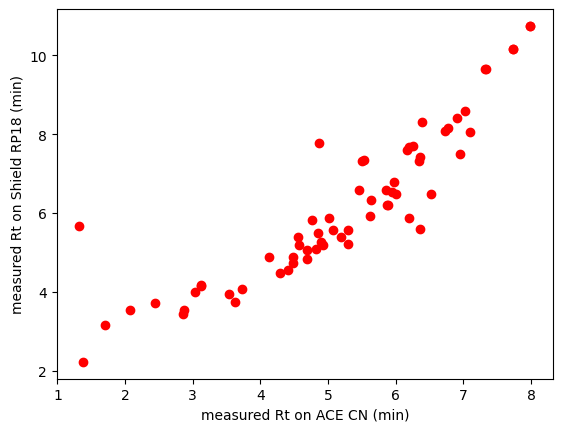

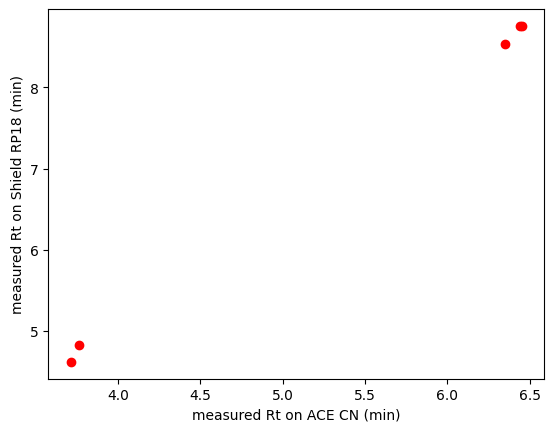

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE CN
Zorbax Extend C18


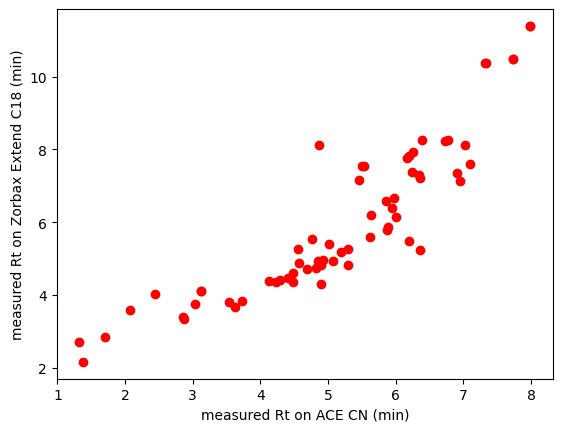

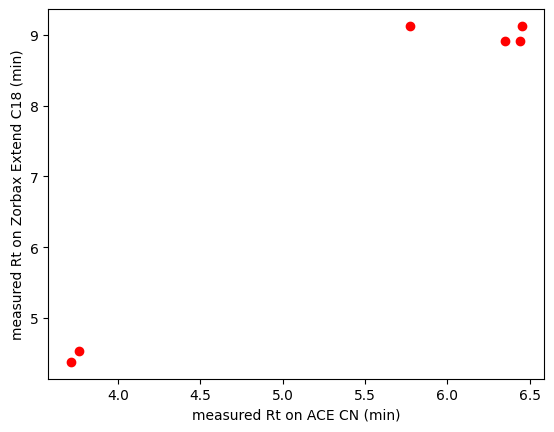

(66, 1)
(66, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE CN
Zorbax SB C8


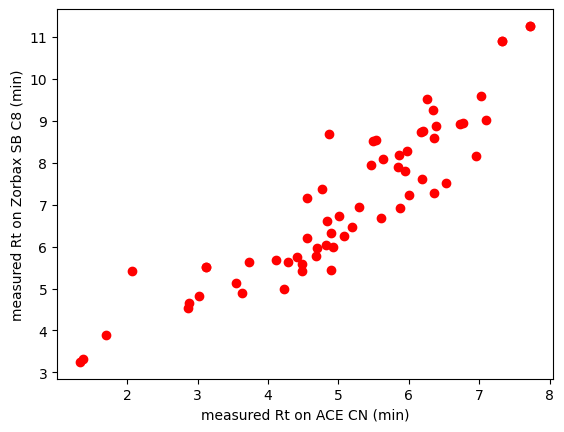

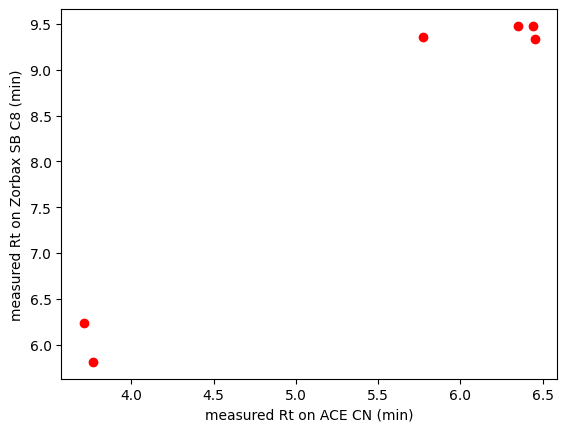

(62, 1)
(62, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE CN
Zorbax SB-CN


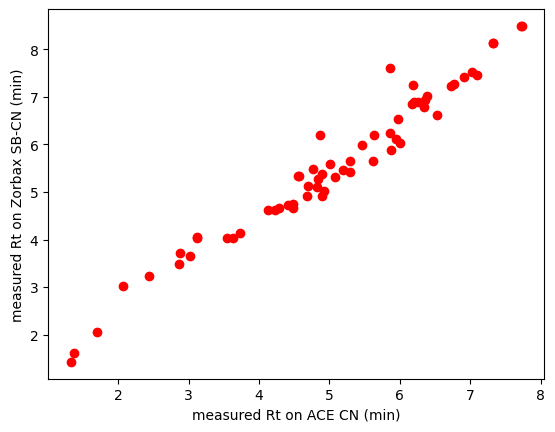

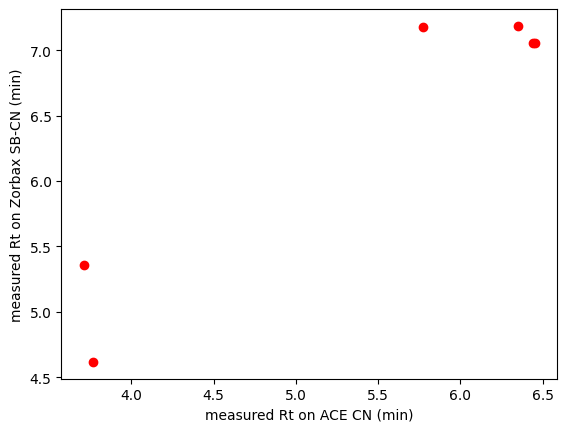

(61, 1)
(61, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE Phenyl
Ascentis F5


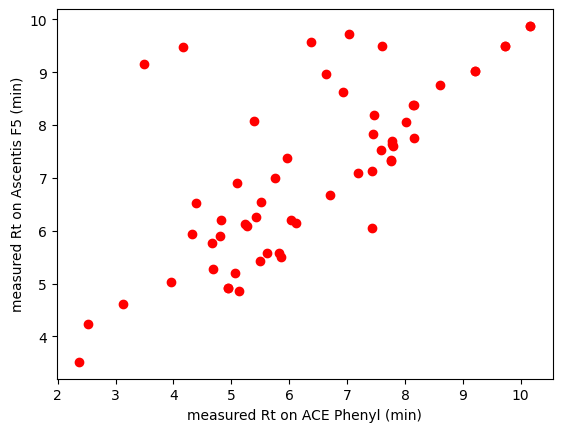

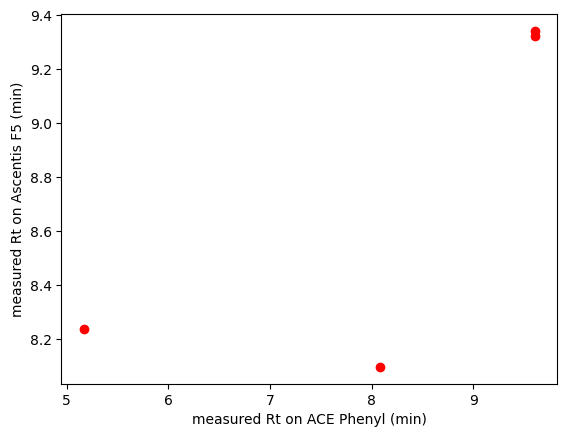

(58, 1)
(58, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE Phenyl
BEH C18 UPLC


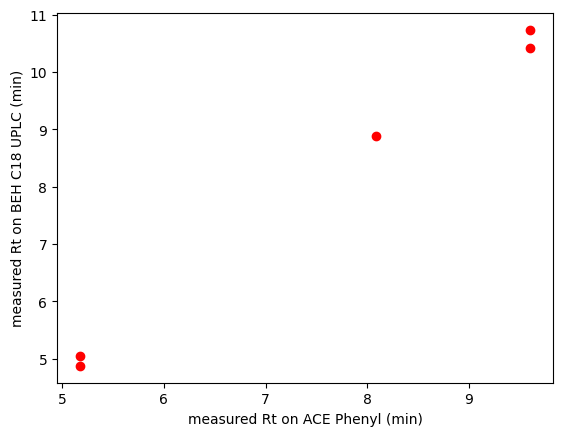

(68, 1)
(73, 1)
1/1 [==============================] - 0s 63ms/step
ACE Phenyl
Bonus RP


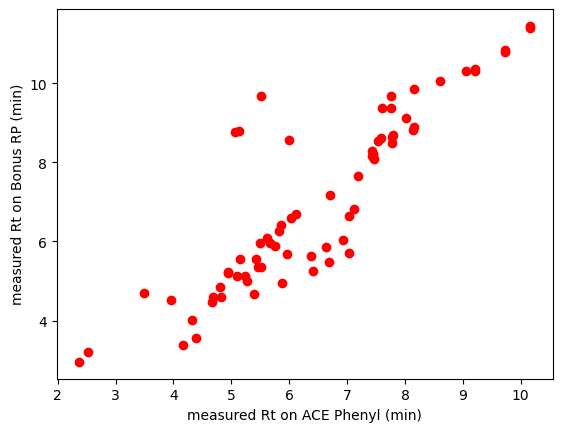

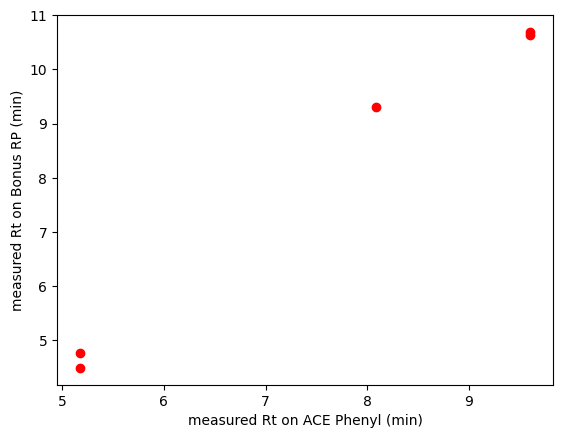

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE Phenyl
CSH C18 UPLC


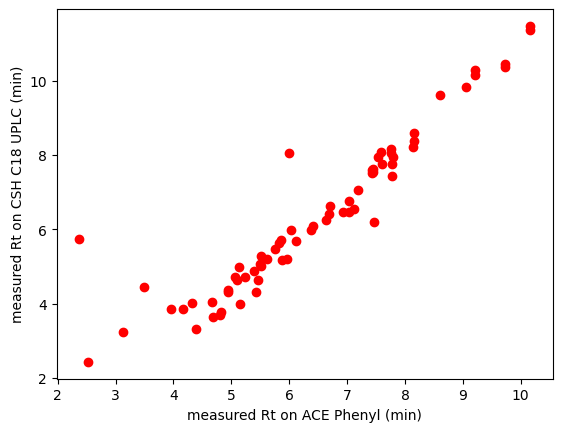

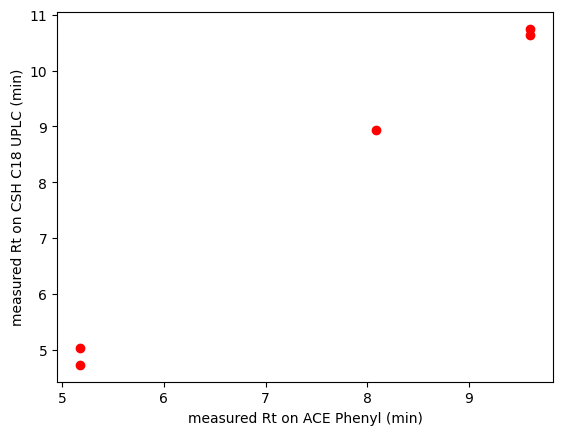

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE Phenyl
Cortecs C18+


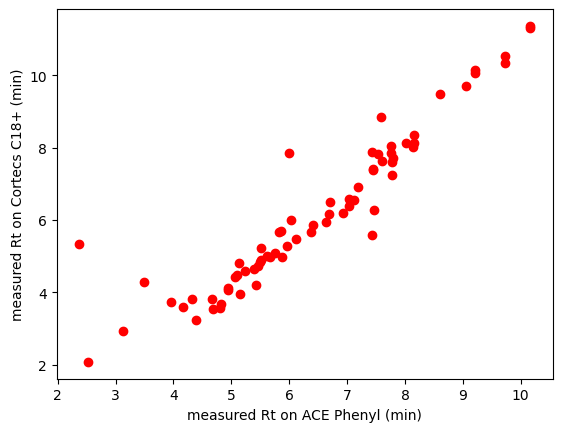

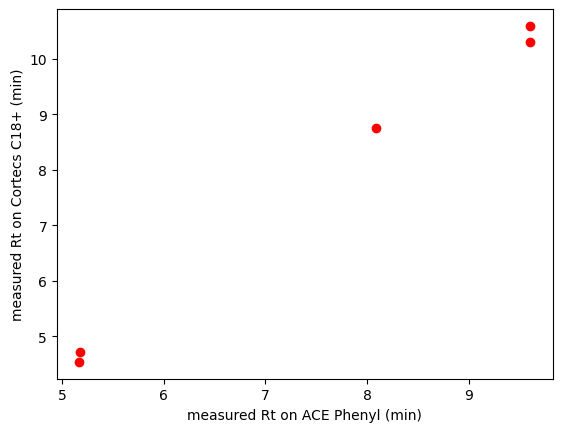

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE Phenyl
Eclipse RRHD Plus C18


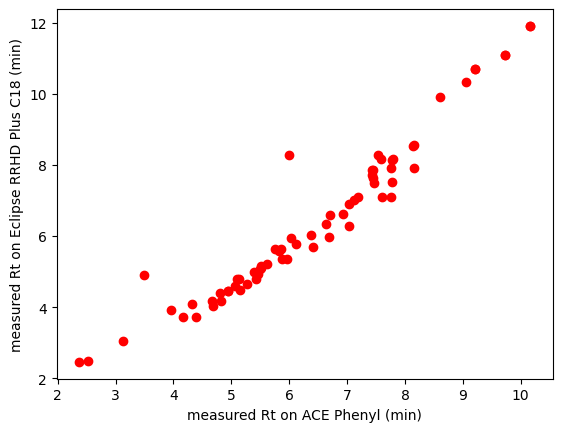

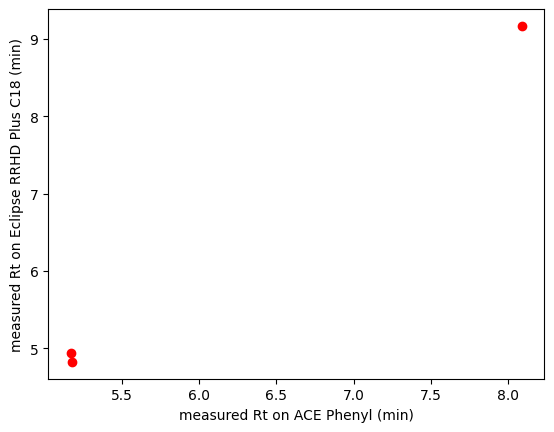

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE Phenyl
Hypersil PFP


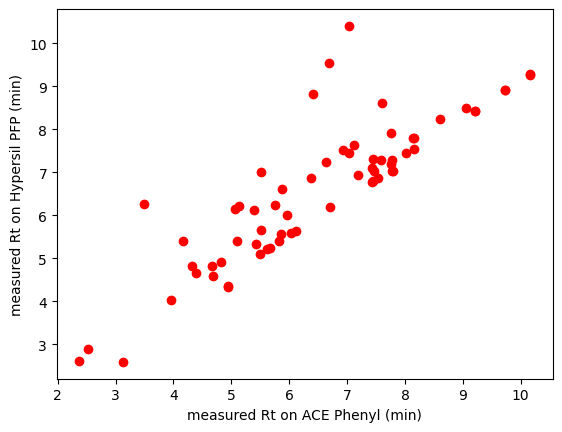

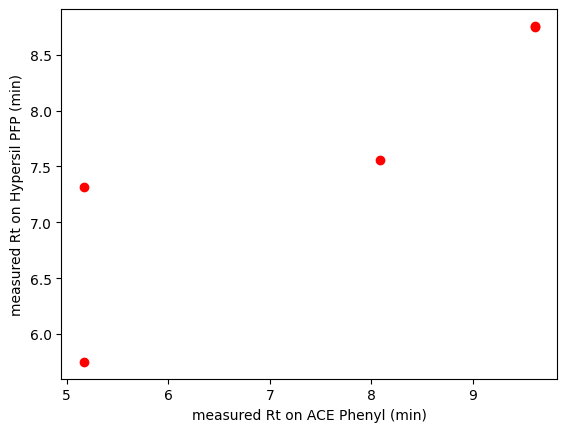

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE Phenyl
Hypersil aQ


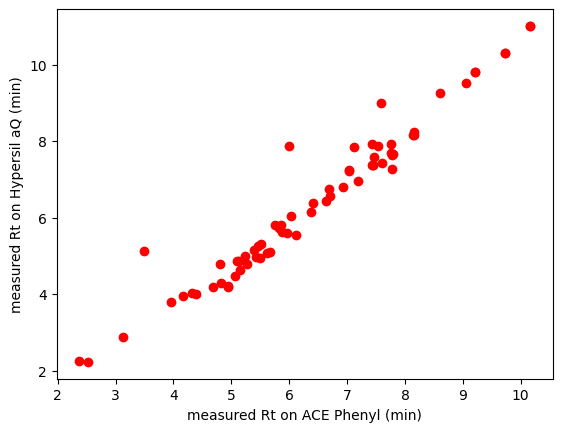

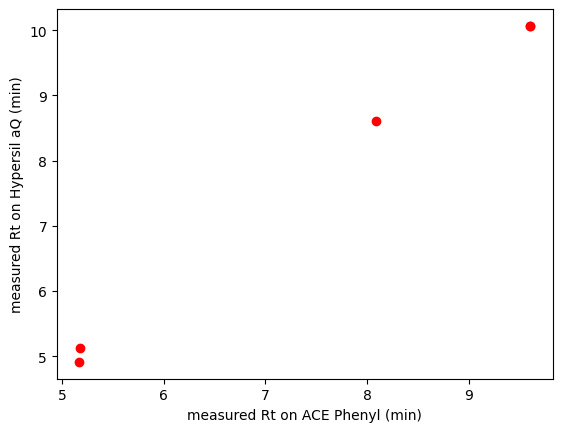

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE Phenyl
Kinetix XB-C18


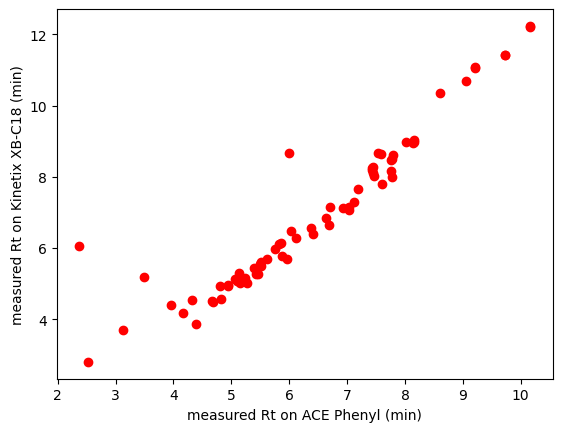

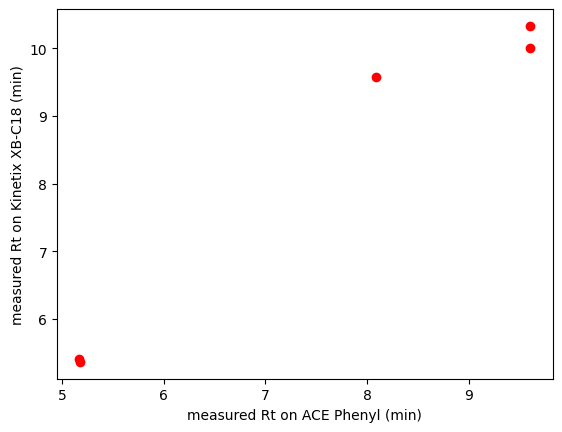

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE Phenyl
Poroshell EC-C18


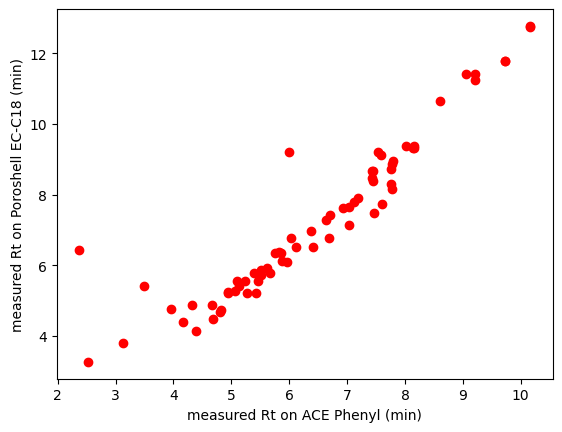

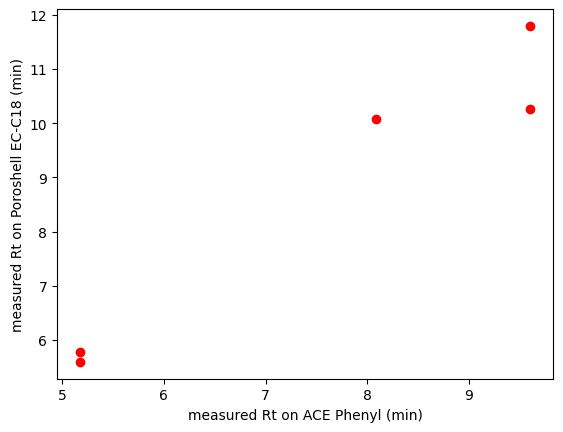

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE Phenyl
Poroshell SB-AQ


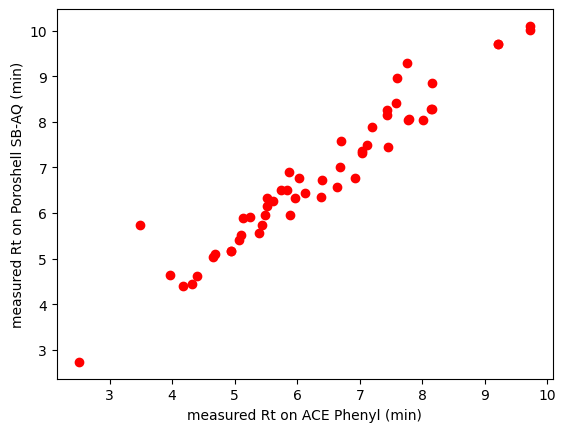

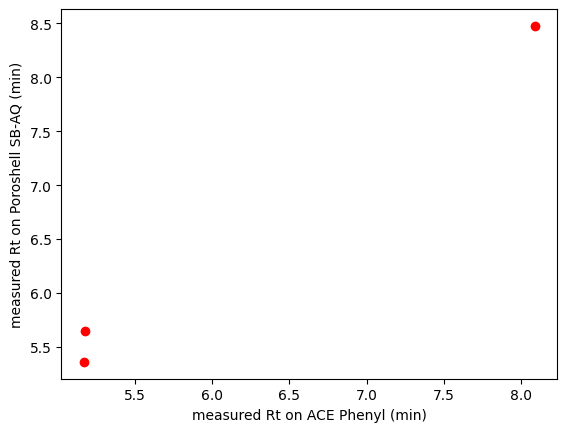

(53, 1)
(53, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE Phenyl
Shield RP18


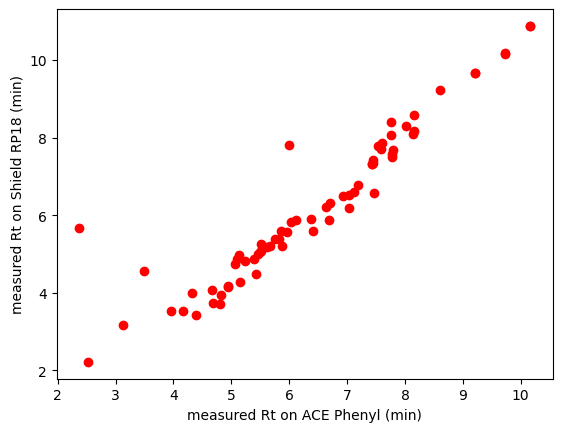

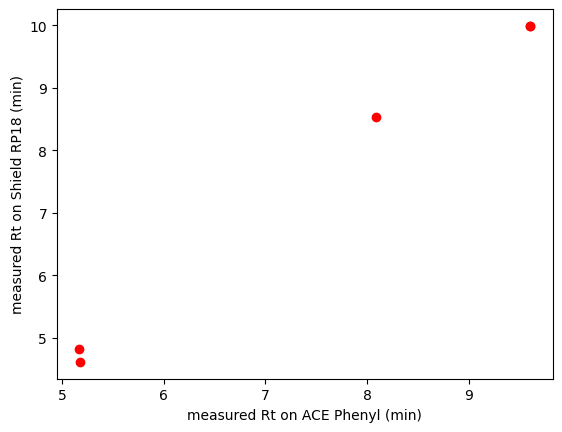

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
ACE Phenyl
Zorbax Extend C18


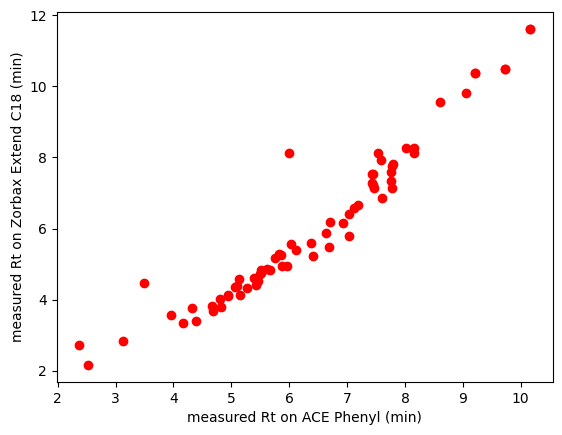

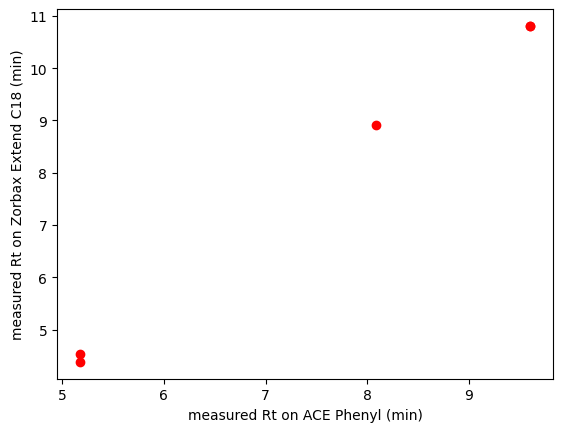

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
ACE Phenyl
Zorbax SB C8


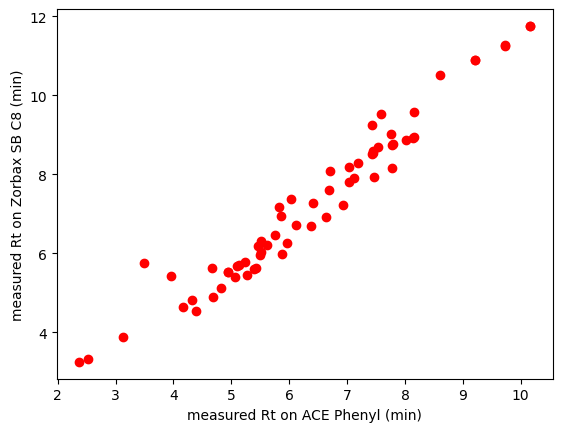

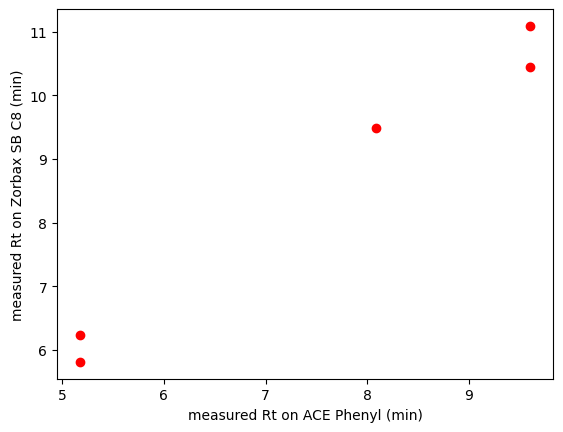

(64, 1)
(64, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
ACE Phenyl
Zorbax SB-CN


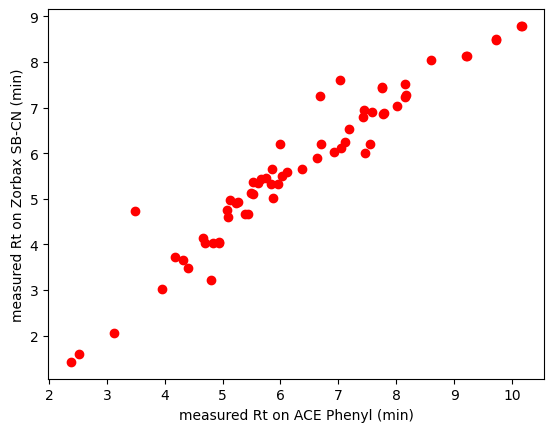

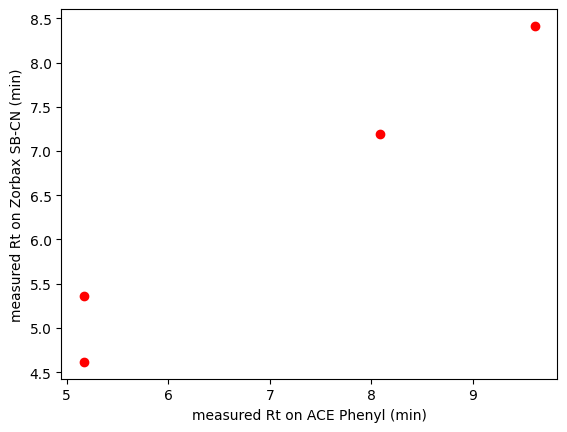

(63, 1)
(63, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Ascentis F5
BEH C18 UPLC


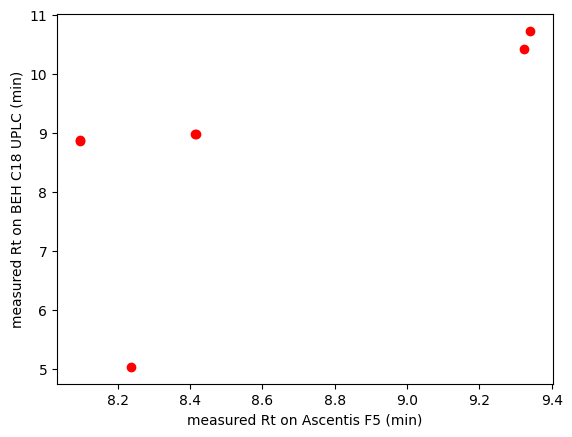

(66, 1)
(71, 1)
1/1 [==============================] - 0s 78ms/step
Ascentis F5
Bonus RP


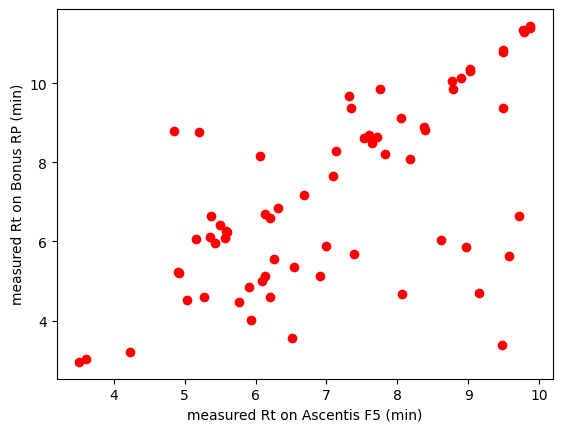

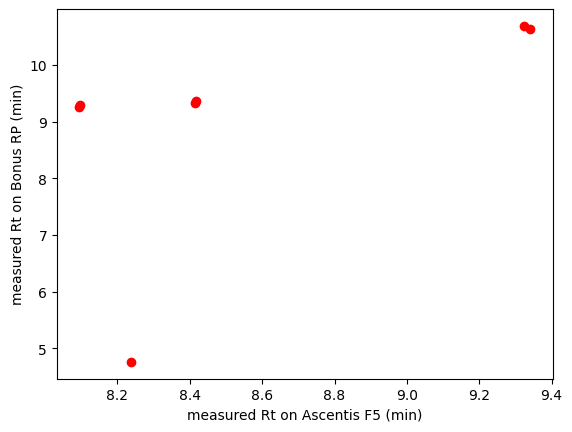

(67, 1)
(67, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Ascentis F5
CSH C18 UPLC


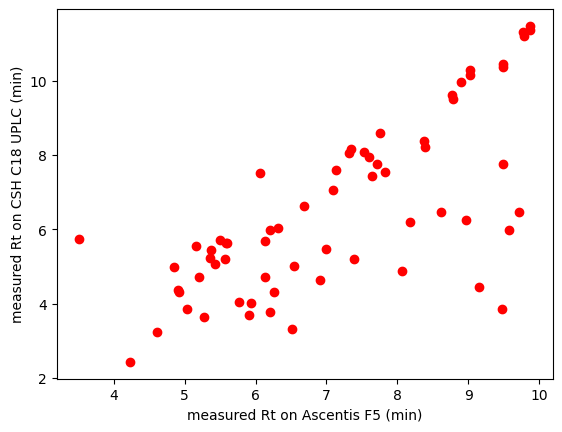

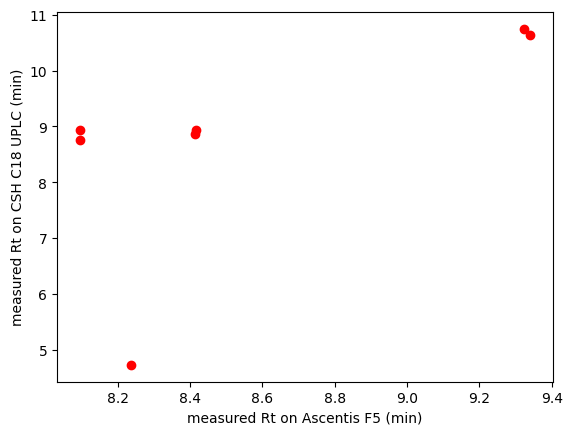

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Ascentis F5
Cortecs C18+


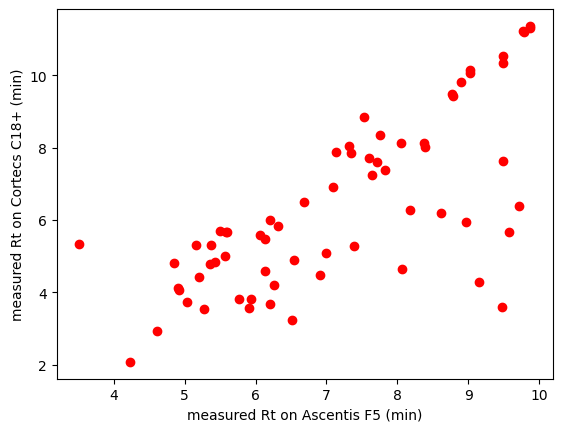

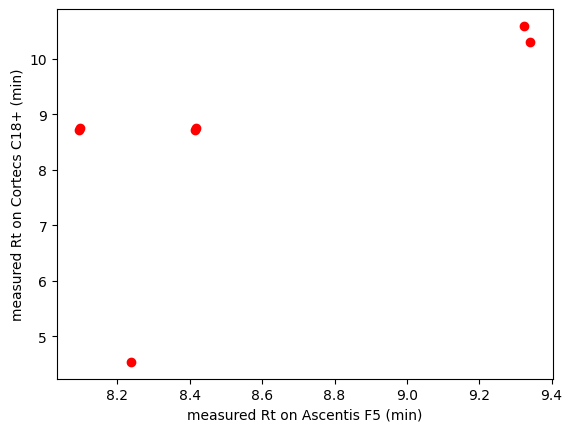

(66, 1)
(66, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Ascentis F5
Eclipse RRHD Plus C18


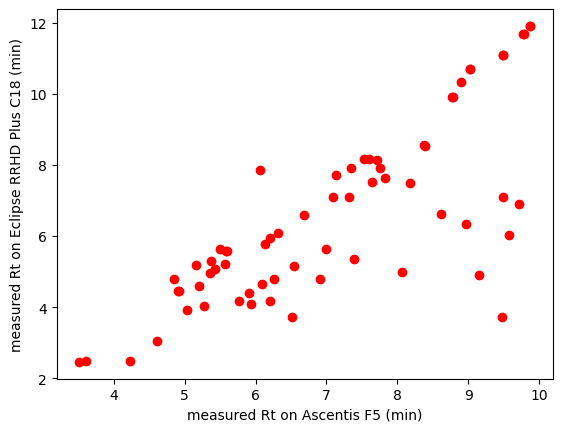

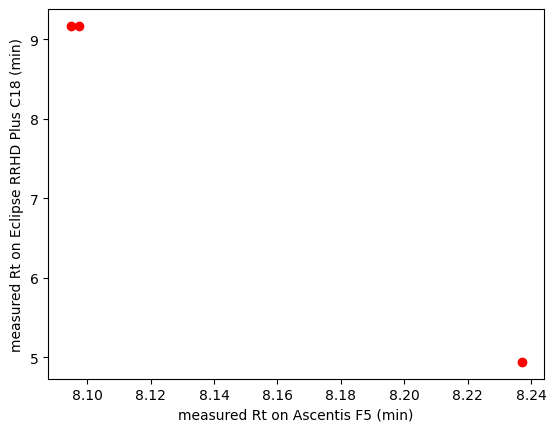

(66, 1)
(66, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Ascentis F5
Hypersil PFP


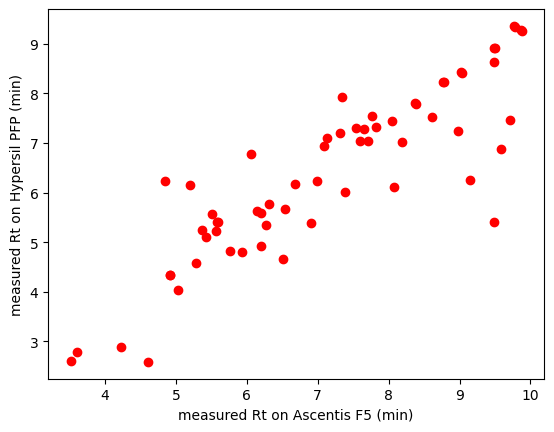

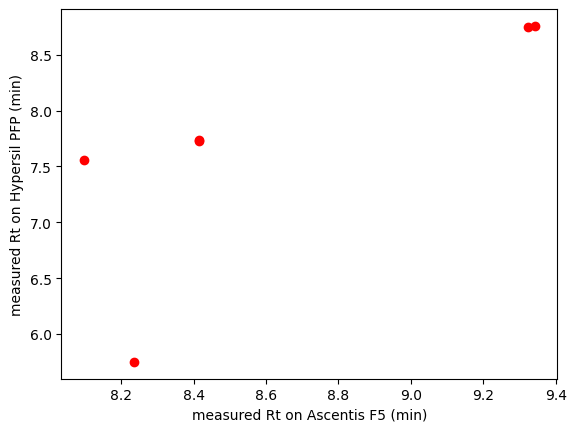

(62, 1)
(62, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Ascentis F5
Hypersil aQ


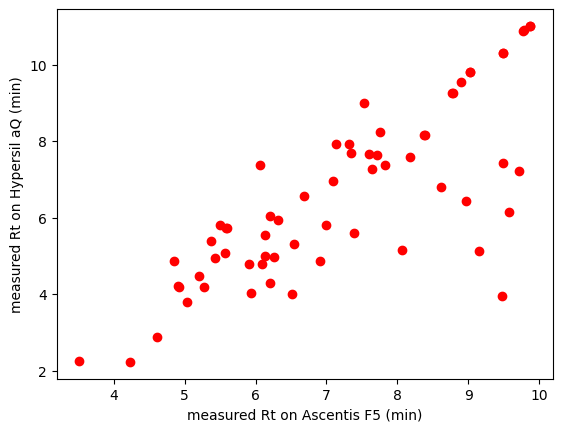

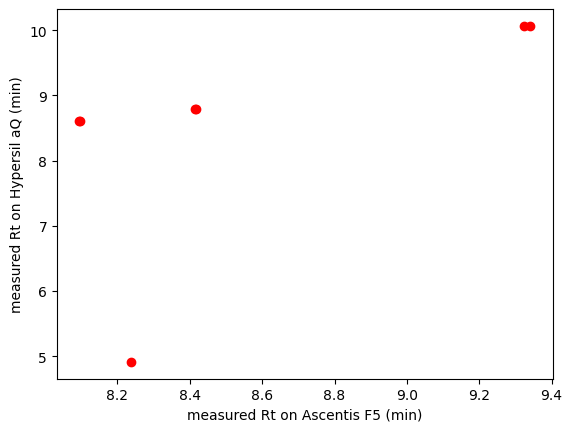

(63, 1)
(63, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Ascentis F5
Kinetix XB-C18


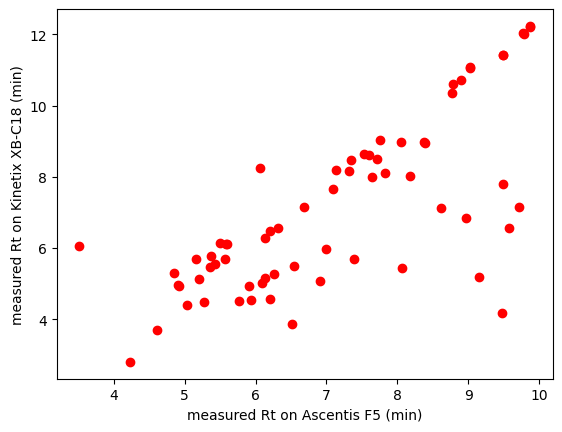

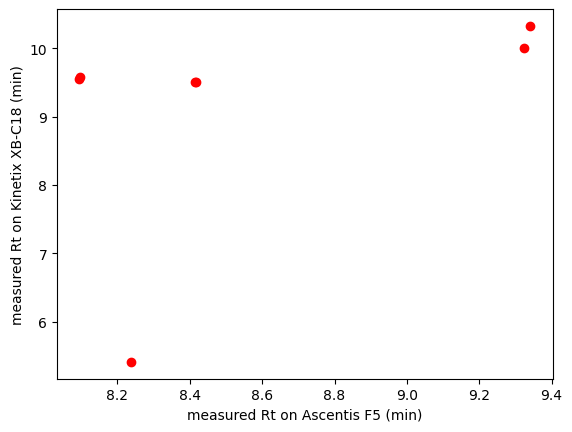

(67, 1)
(67, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Ascentis F5
Poroshell EC-C18


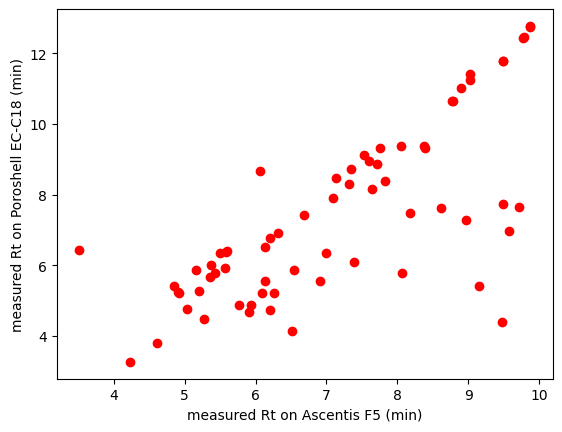

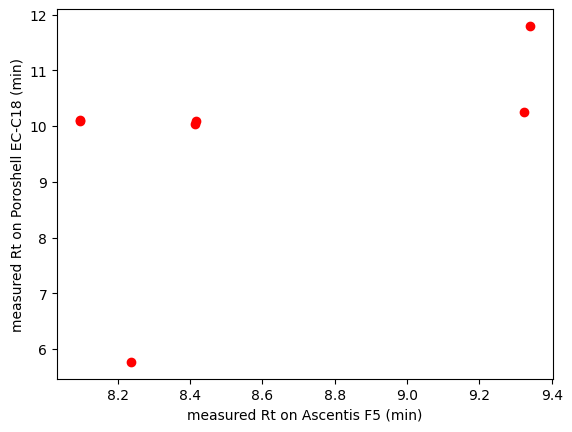

(67, 1)
(67, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Ascentis F5
Poroshell SB-AQ


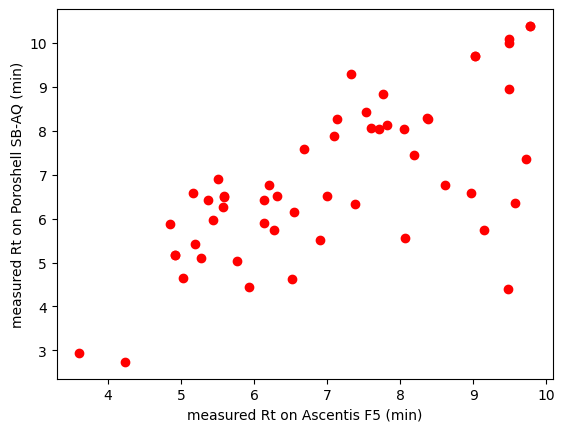

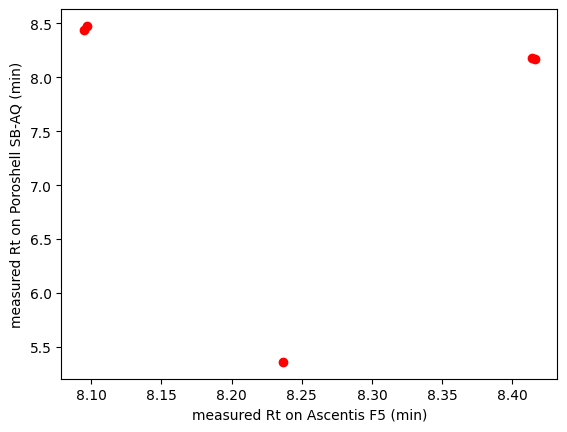

(54, 1)
(54, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Ascentis F5
Shield RP18


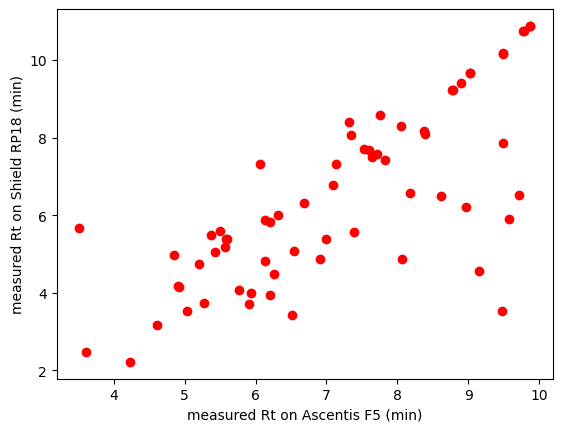

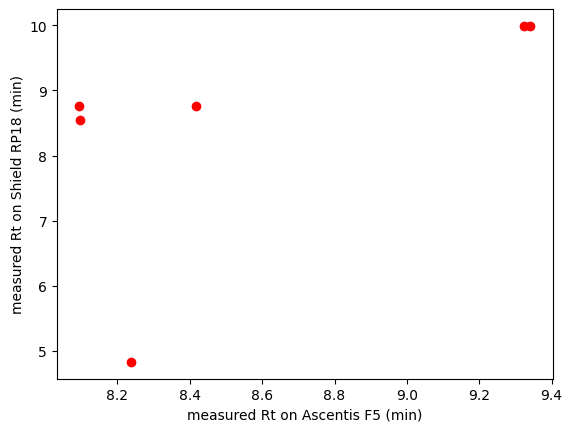

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Ascentis F5
Zorbax Extend C18


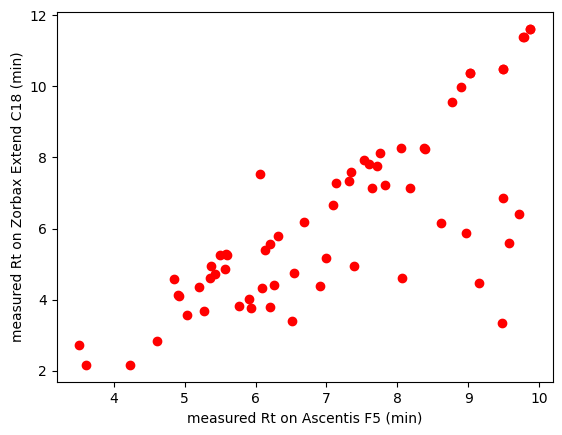

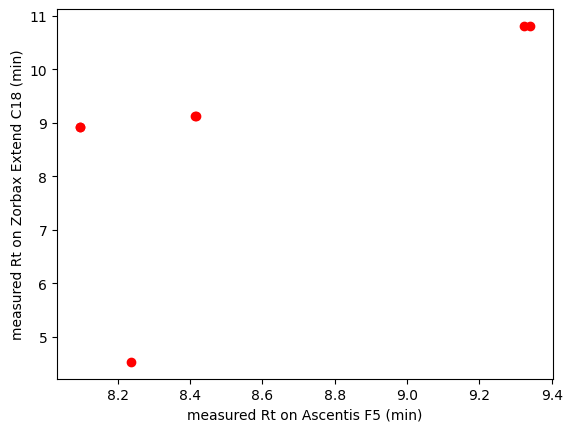

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Ascentis F5
Zorbax SB C8


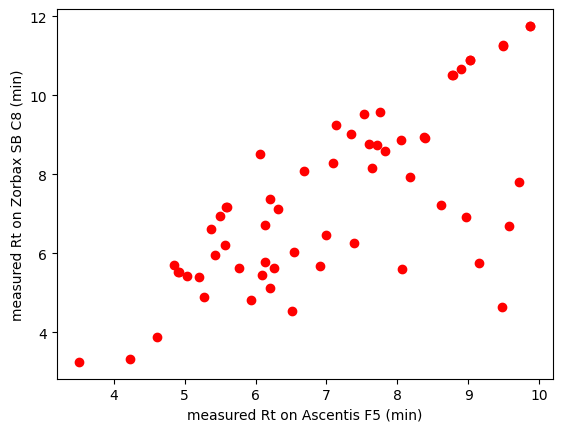

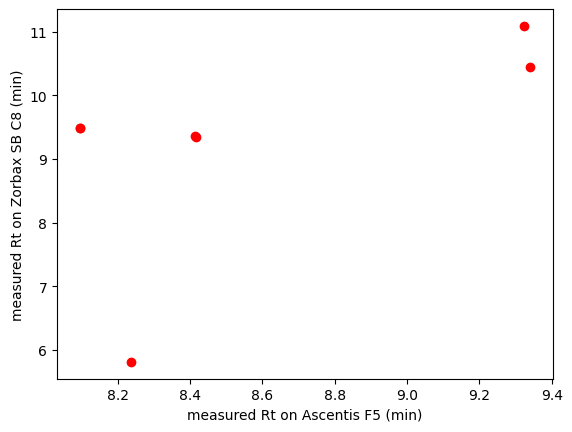

(60, 1)
(60, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Ascentis F5
Zorbax SB-CN


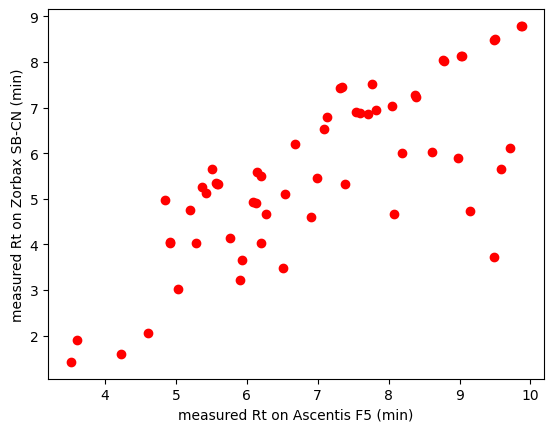

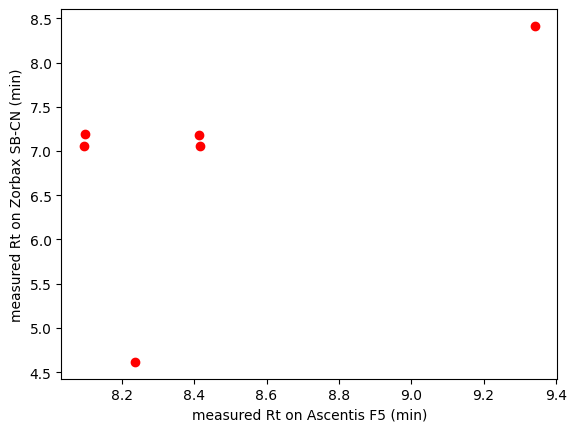

(59, 1)
(59, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
BEH C18 UPLC
Bonus RP


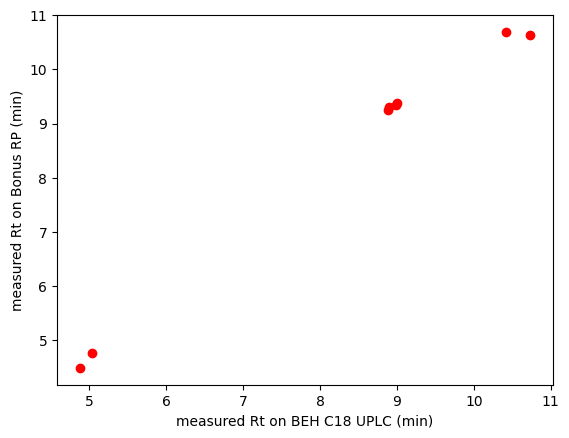

(86, 1)
(82, 1)
1/1 [==============================] - 0s 62ms/step
BEH C18 UPLC
CSH C18 UPLC


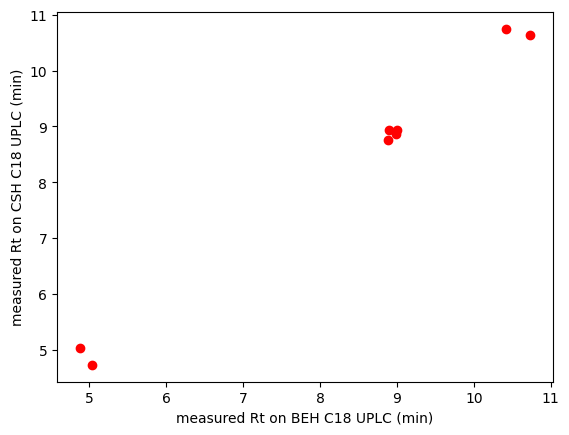

(82, 1)
(78, 1)
1/1 [==============================] - 0s 63ms/step
BEH C18 UPLC
Cortecs C18+


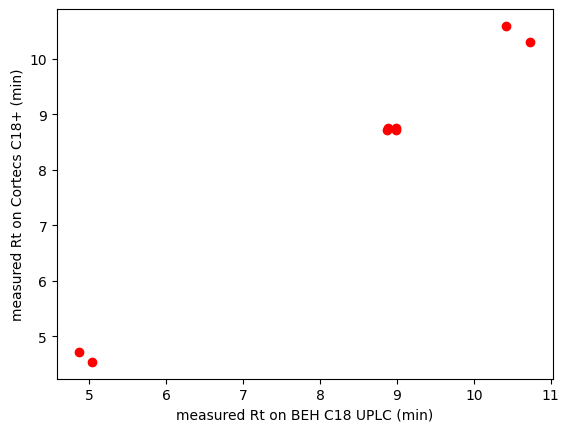

(84, 1)
(80, 1)
1/1 [==============================] - 0s 78ms/step
BEH C18 UPLC
Eclipse RRHD Plus C18


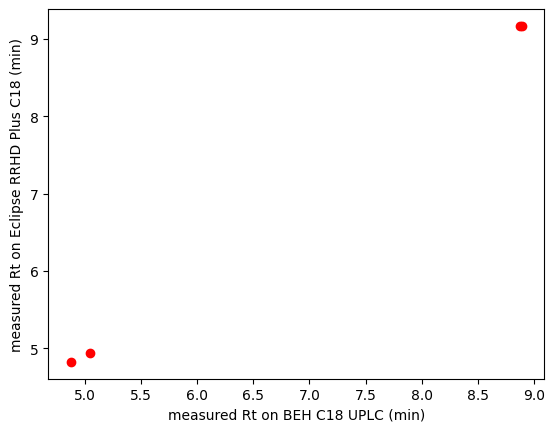

(84, 1)
(80, 1)
1/1 [==============================] - 0s 62ms/step
BEH C18 UPLC
Hypersil PFP


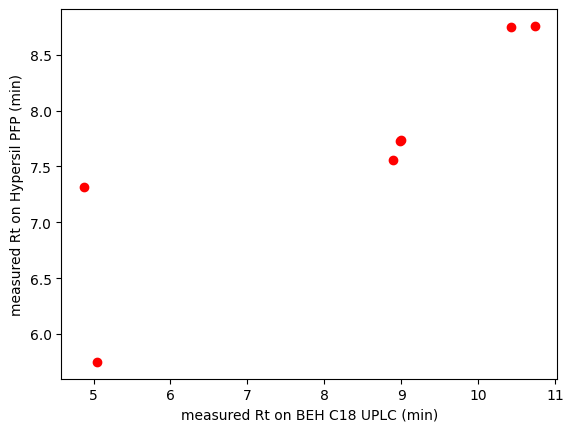

(78, 1)
(74, 1)
1/1 [==============================] - 0s 78ms/step
BEH C18 UPLC
Hypersil aQ


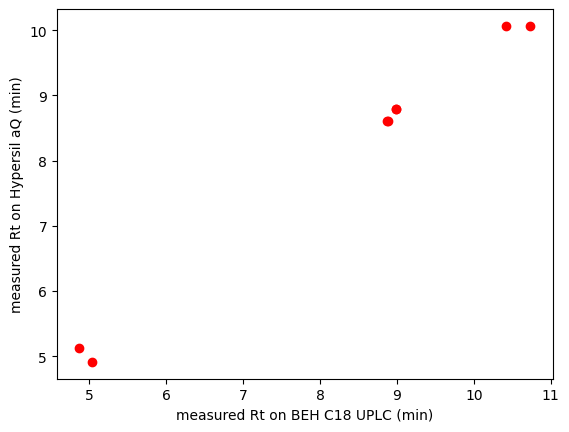

(79, 1)
(75, 1)
1/1 [==============================] - 0s 78ms/step
BEH C18 UPLC
Kinetix XB-C18


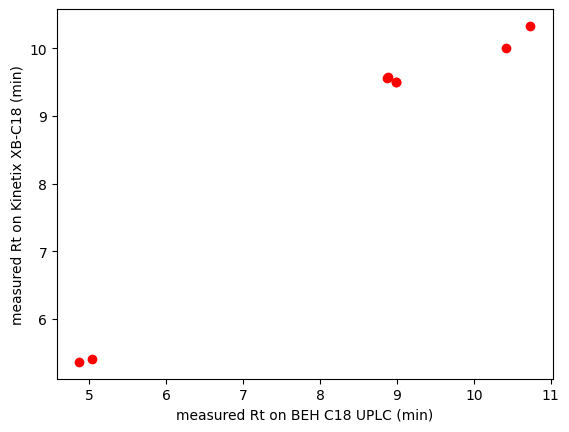

(86, 1)
(82, 1)
1/1 [==============================] - 0s 62ms/step
BEH C18 UPLC
Poroshell EC-C18


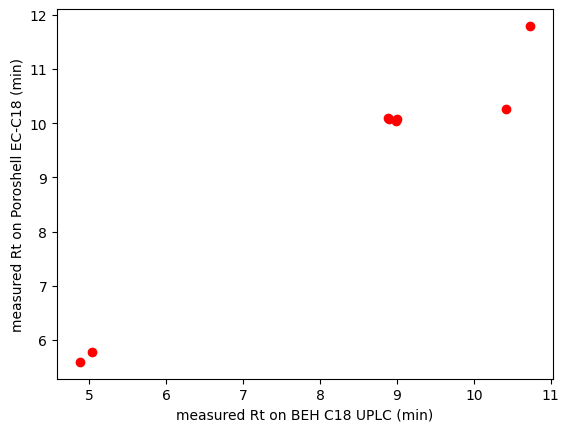

(86, 1)
(82, 1)
1/1 [==============================] - 0s 62ms/step
BEH C18 UPLC
Poroshell SB-AQ


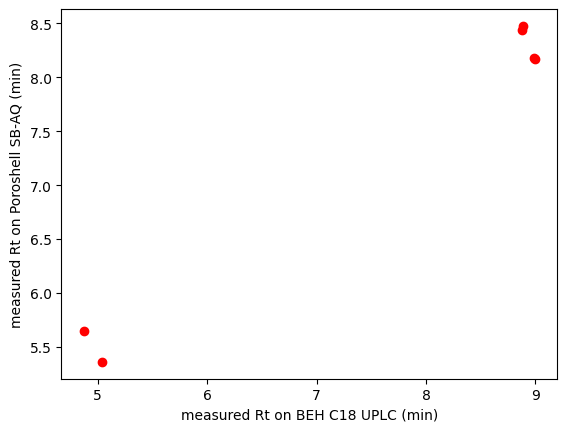

(65, 1)
(61, 1)
1/1 [==============================] - 0s 78ms/step
BEH C18 UPLC
Shield RP18


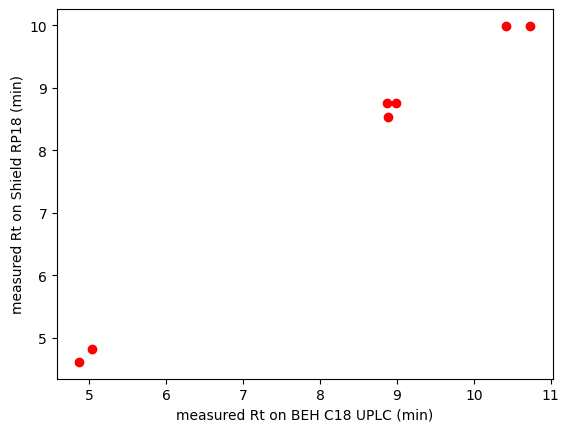

(79, 1)
(75, 1)
1/1 [==============================] - 0s 63ms/step
BEH C18 UPLC
Zorbax Extend C18


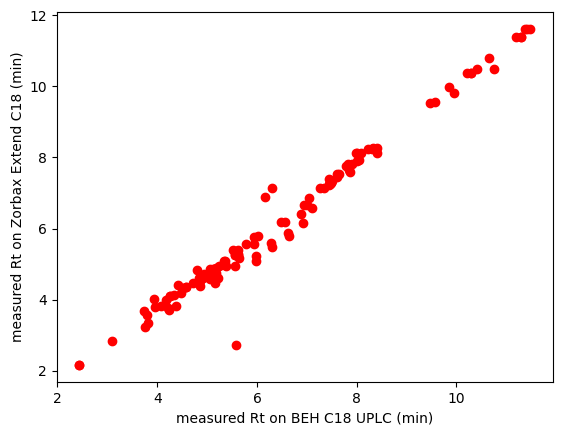

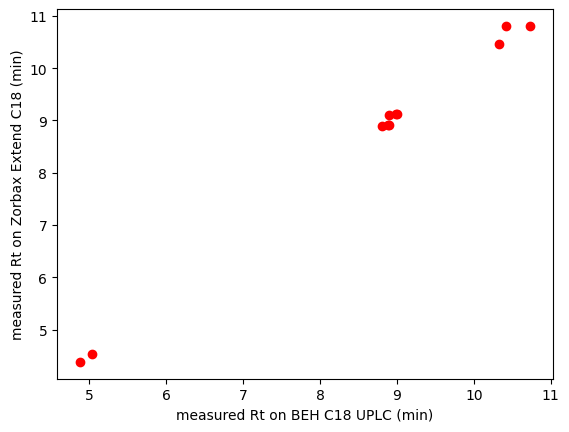

(116, 1)
(116, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
BEH C18 UPLC
Zorbax SB C8


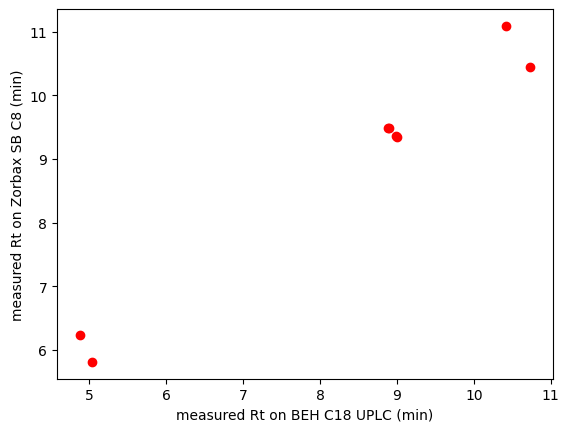

(76, 1)
(72, 1)
1/1 [==============================] - 0s 74ms/step
BEH C18 UPLC
Zorbax SB-CN


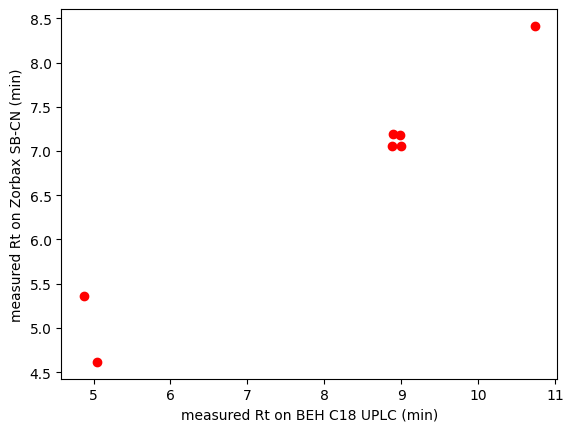

(73, 1)
(69, 1)
1/1 [==============================] - 0s 78ms/step
Bonus RP
CSH C18 UPLC


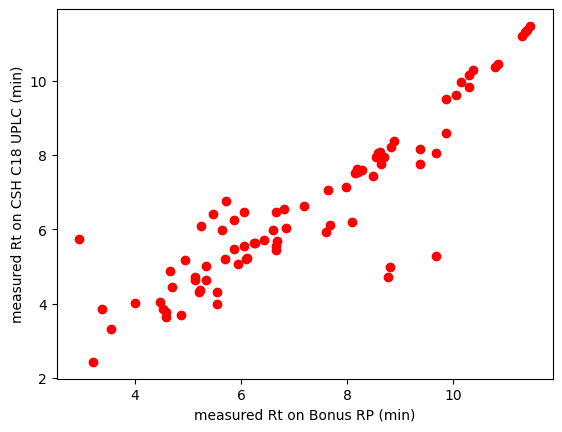

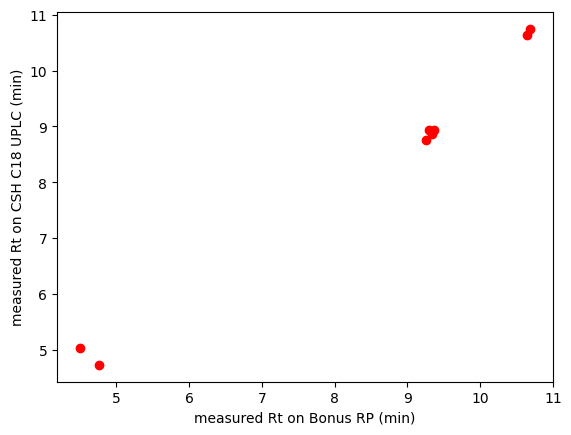

(80, 1)
(80, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Bonus RP
Cortecs C18+


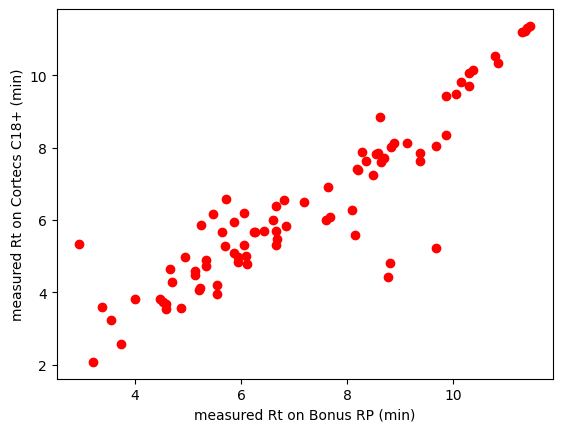

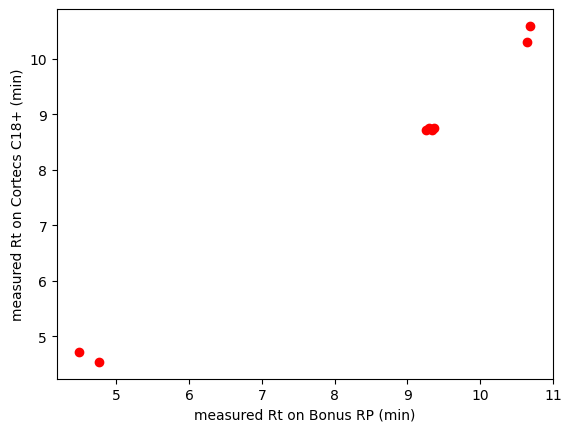

(83, 1)
(83, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Bonus RP
Eclipse RRHD Plus C18


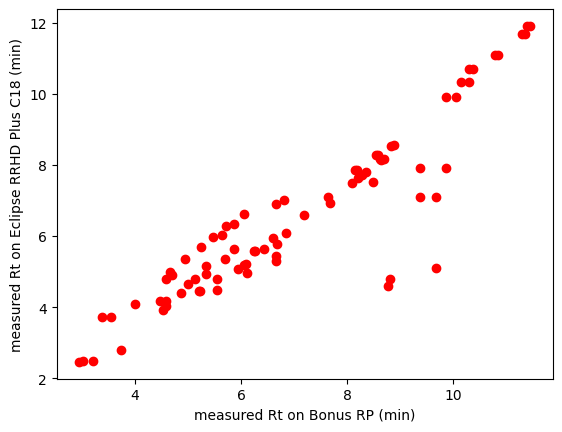

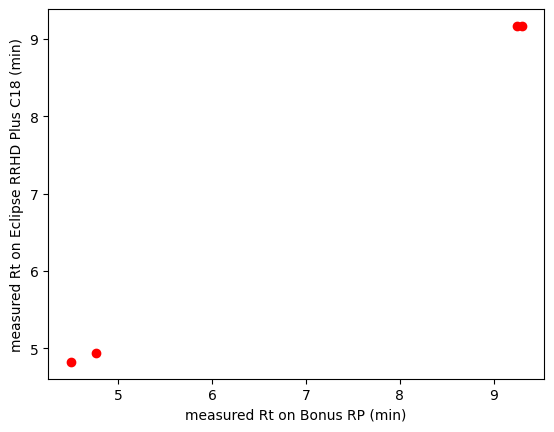

(82, 1)
(82, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Bonus RP
Hypersil PFP


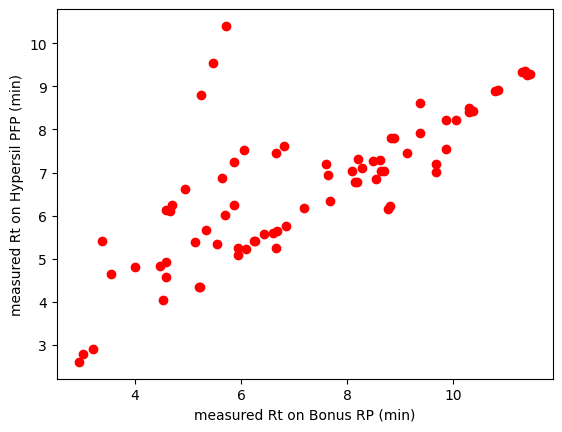

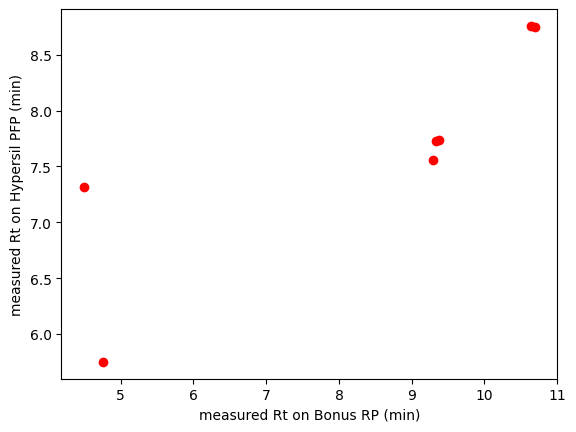

(74, 1)
(74, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Bonus RP
Hypersil aQ


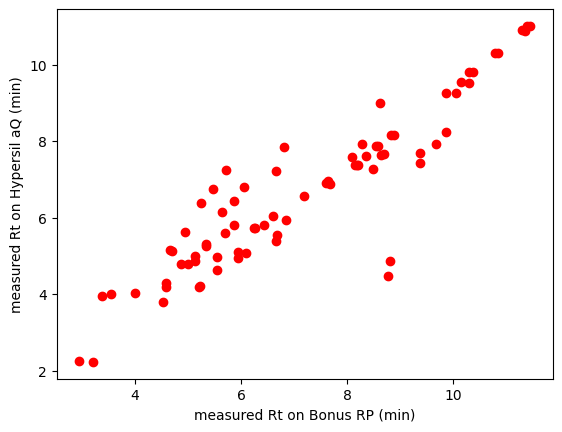

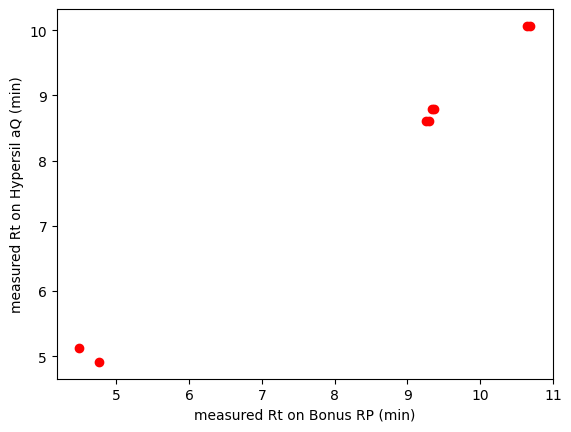

(77, 1)
(77, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Bonus RP
Kinetix XB-C18


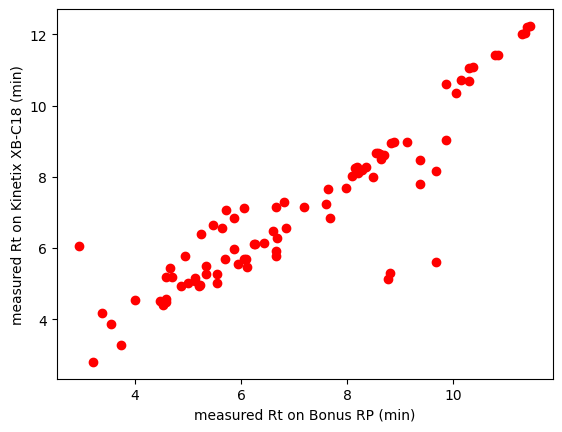

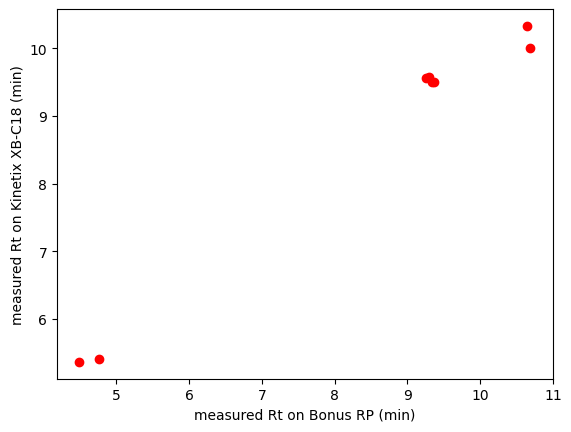

(85, 1)
(85, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Bonus RP
Poroshell EC-C18


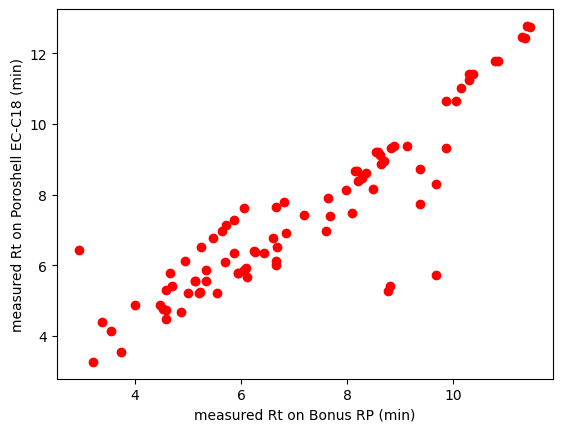

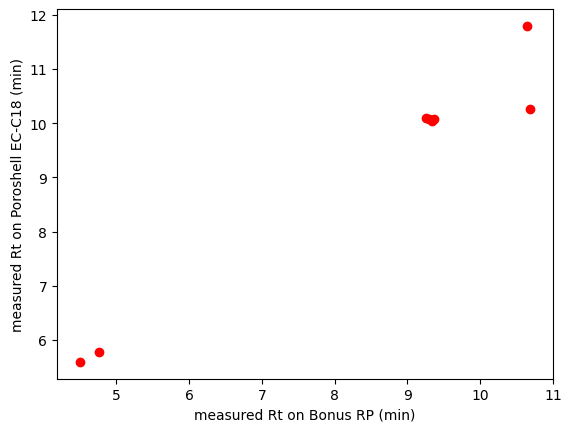

(85, 1)
(85, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Bonus RP
Poroshell SB-AQ


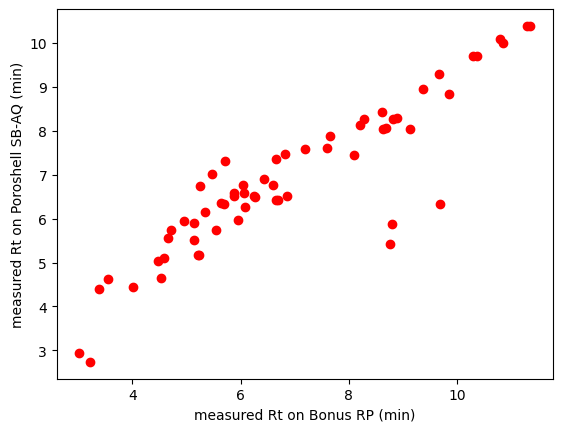

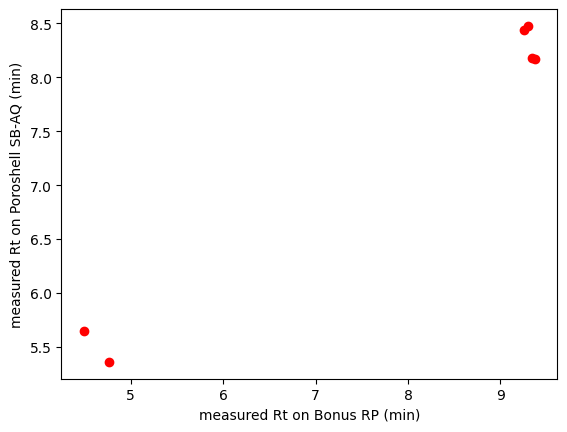

(61, 1)
(61, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Bonus RP
Shield RP18


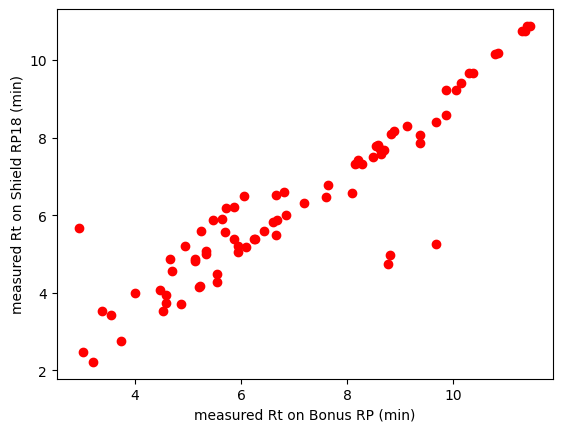

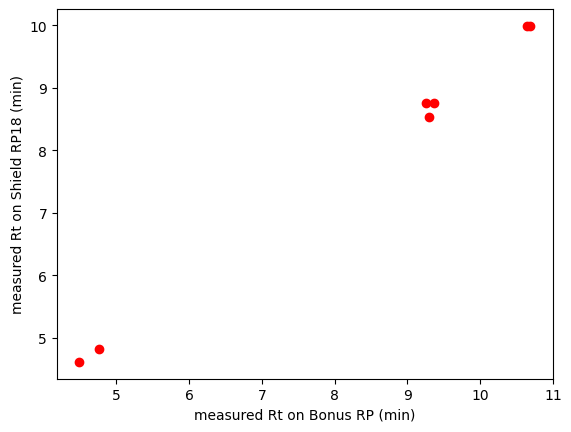

(78, 1)
(78, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
Bonus RP
Zorbax Extend C18


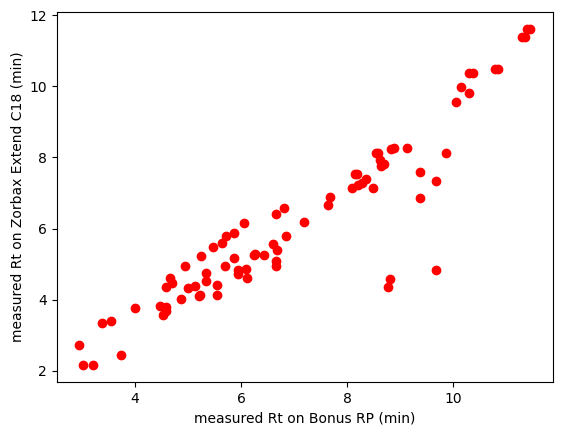

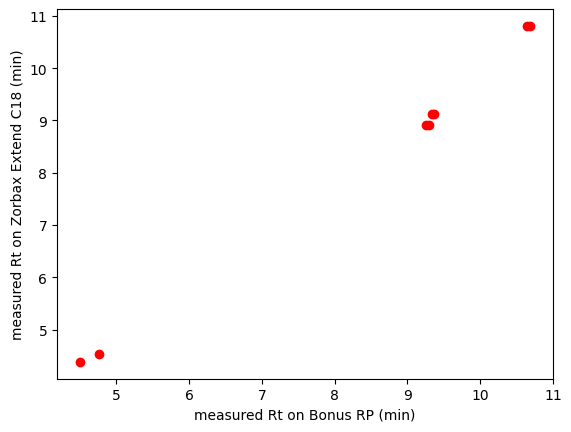

(82, 1)
(82, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Bonus RP
Zorbax SB C8


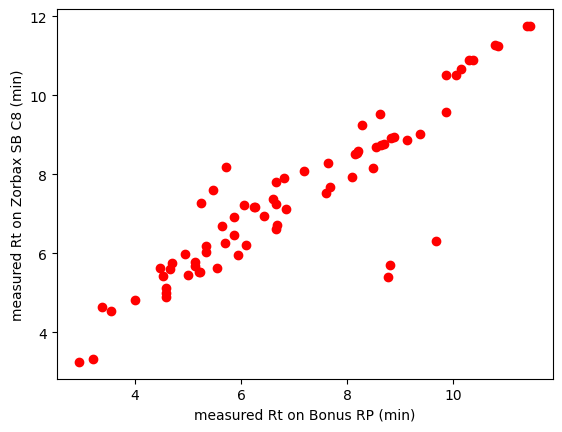

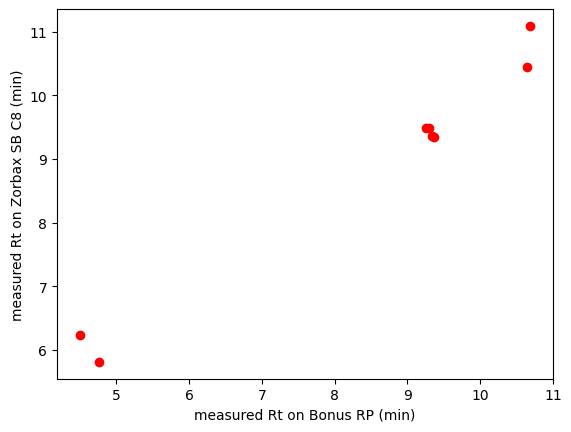

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Bonus RP
Zorbax SB-CN


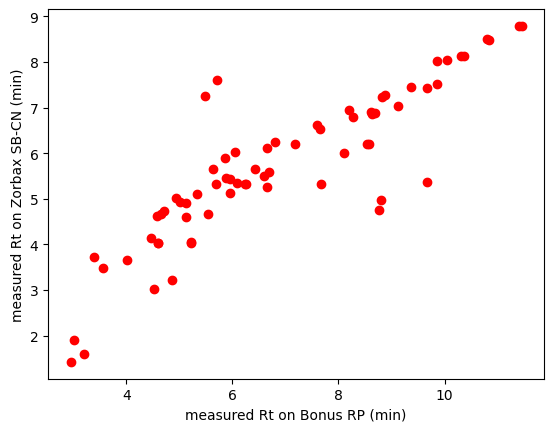

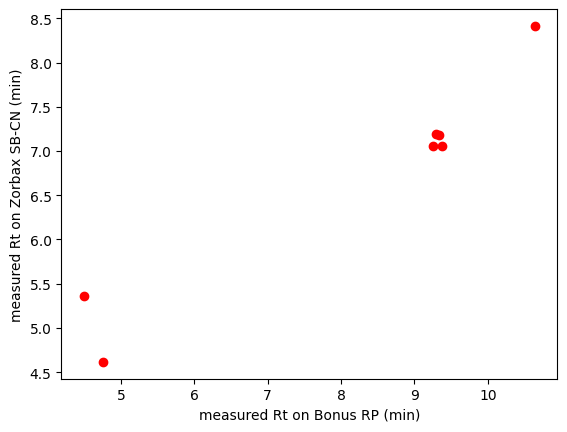

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 79ms/step
CSH C18 UPLC
Cortecs C18+


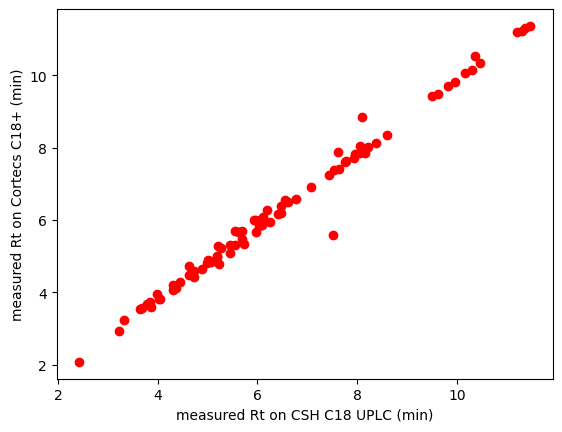

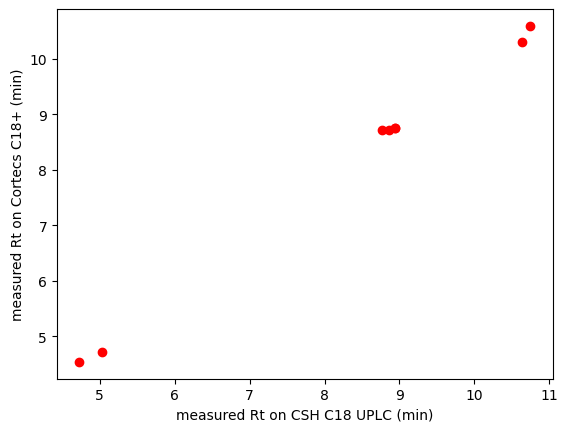

(80, 1)
(80, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
CSH C18 UPLC
Eclipse RRHD Plus C18


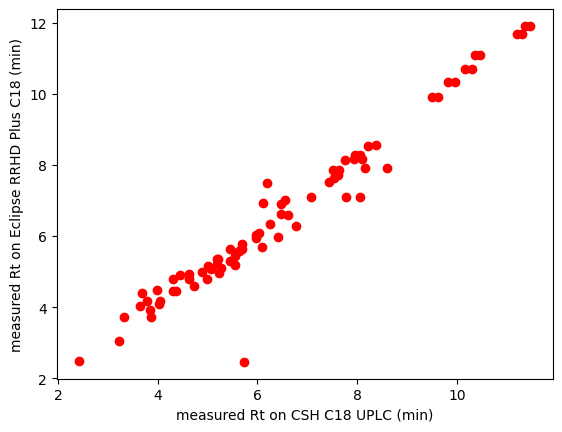

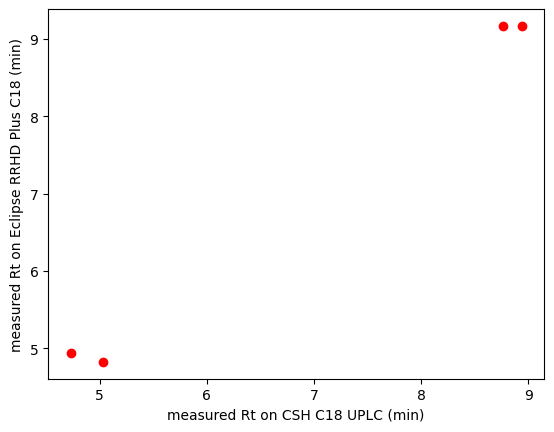

(78, 1)
(78, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
CSH C18 UPLC
Hypersil PFP


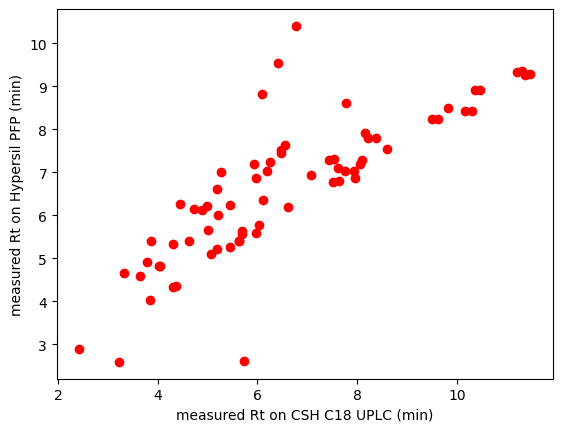

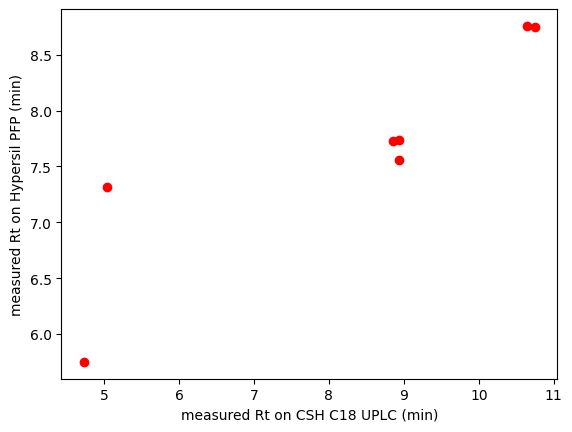

(71, 1)
(71, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
CSH C18 UPLC
Hypersil aQ


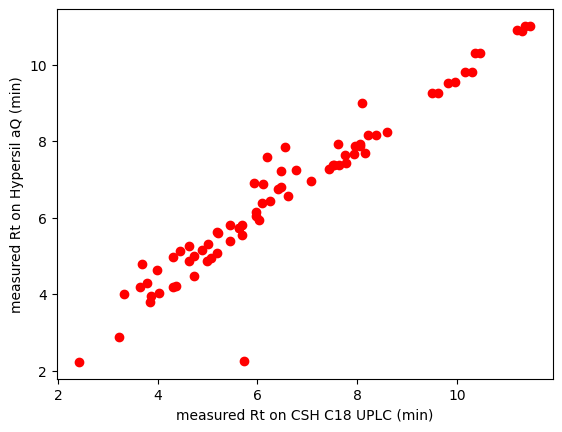

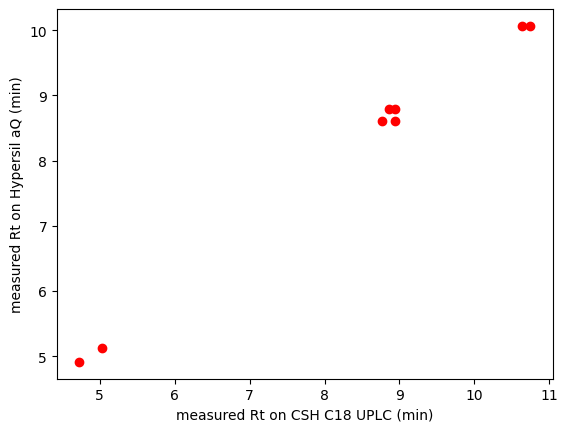

(75, 1)
(75, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
CSH C18 UPLC
Kinetix XB-C18


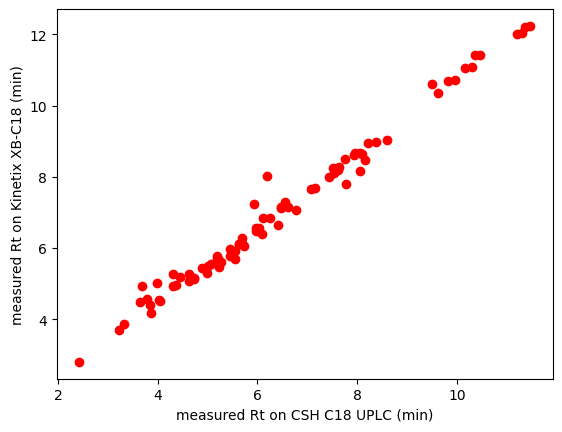

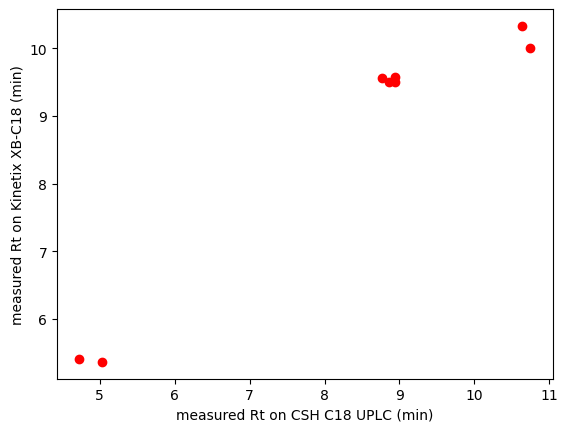

(81, 1)
(81, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
CSH C18 UPLC
Poroshell EC-C18


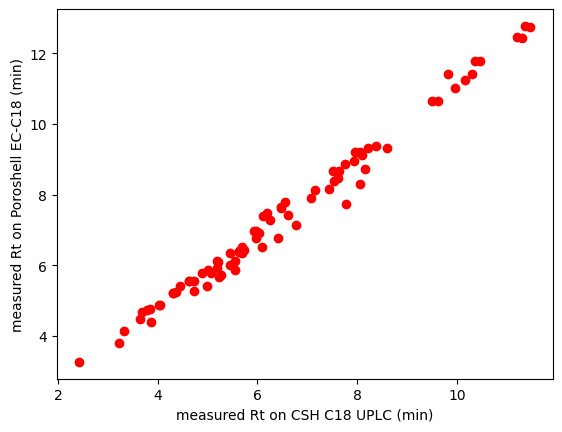

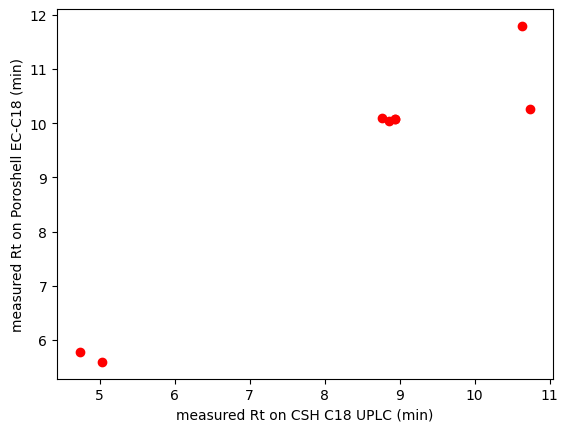

(80, 1)
(80, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
CSH C18 UPLC
Poroshell SB-AQ


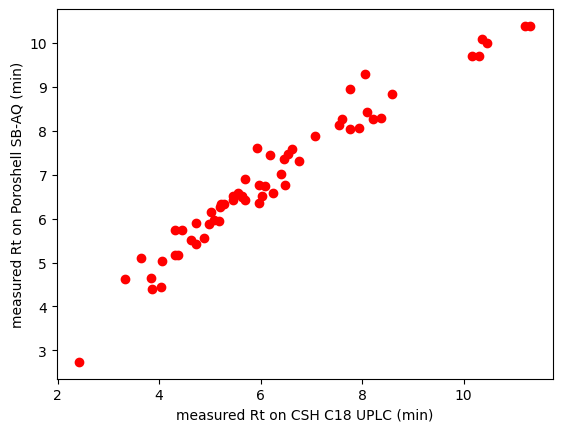

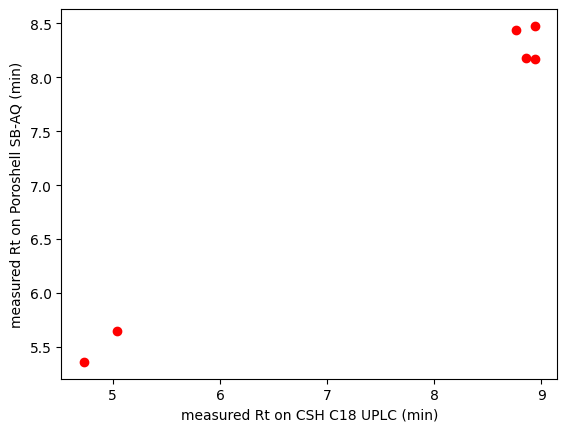

(59, 1)
(59, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
CSH C18 UPLC
Shield RP18


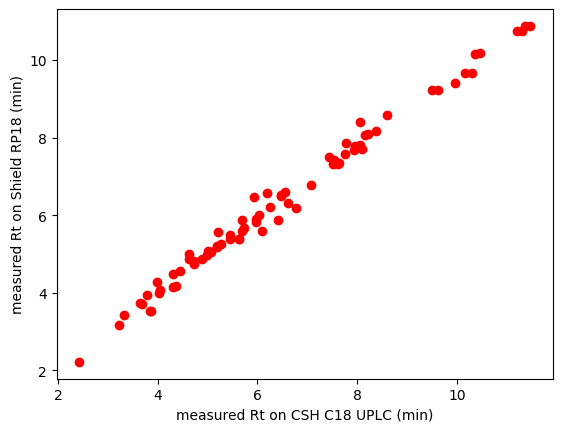

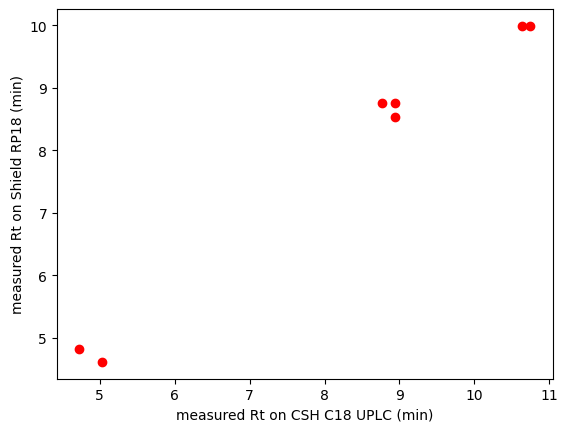

(75, 1)
(75, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
CSH C18 UPLC
Zorbax Extend C18


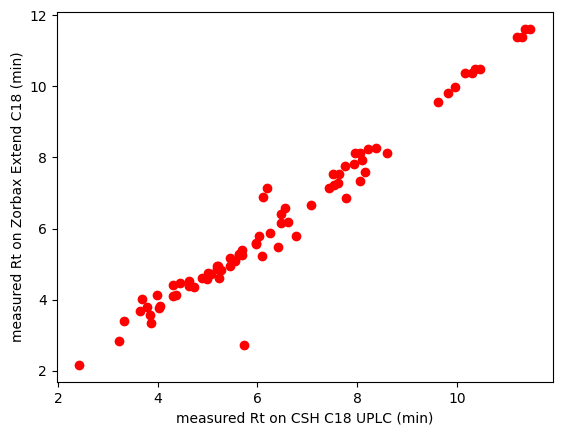

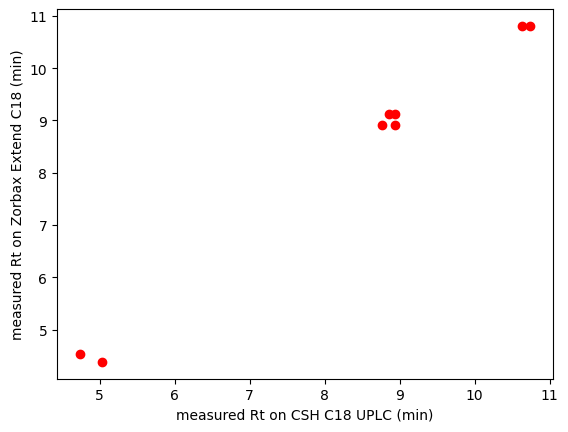

(76, 1)
(76, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
CSH C18 UPLC
Zorbax SB C8


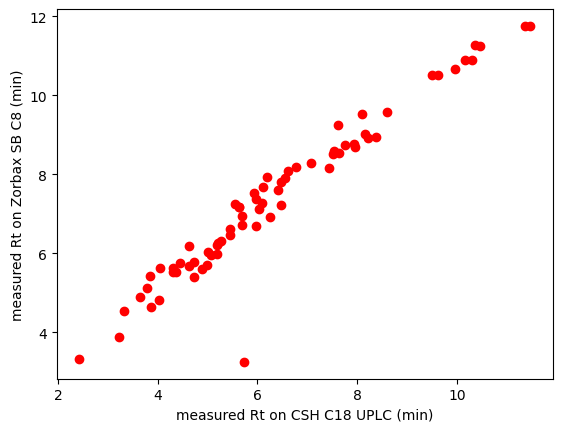

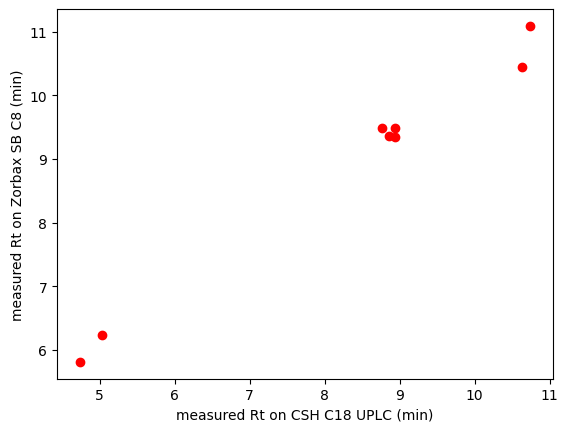

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
CSH C18 UPLC
Zorbax SB-CN


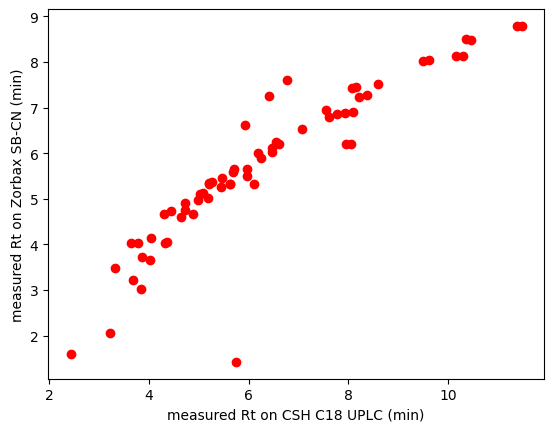

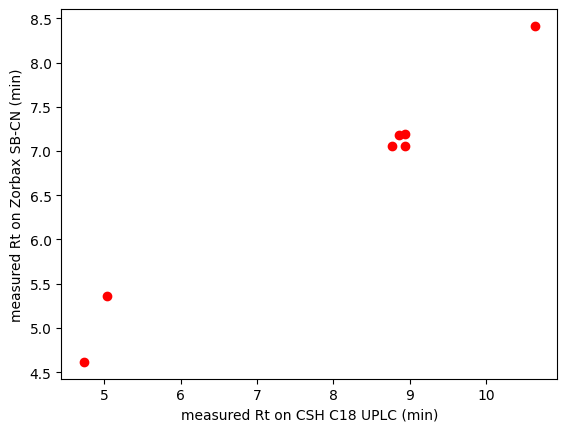

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
Cortecs C18+
Eclipse RRHD Plus C18


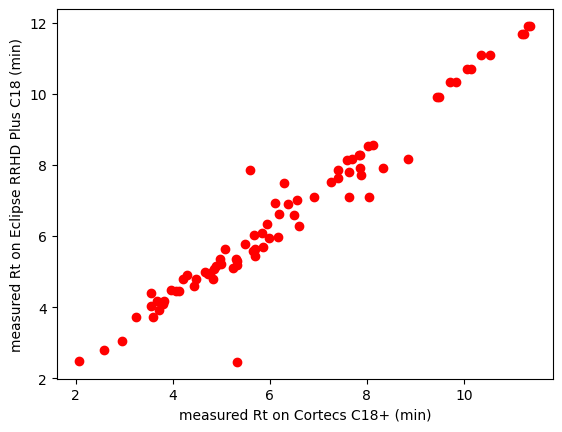

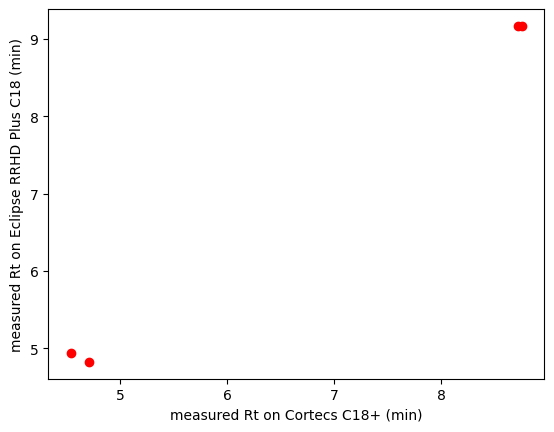

(80, 1)
(80, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
Cortecs C18+
Hypersil PFP


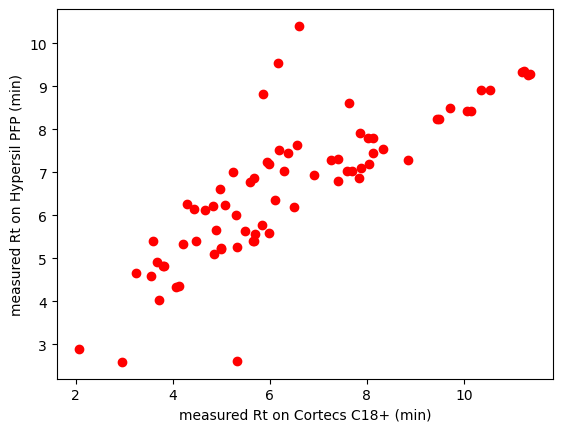

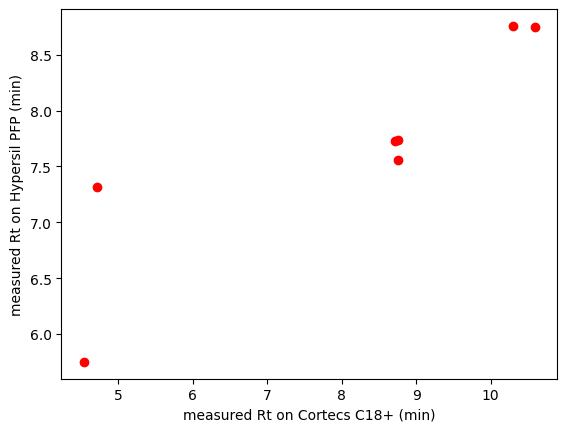

(73, 1)
(73, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Cortecs C18+
Hypersil aQ


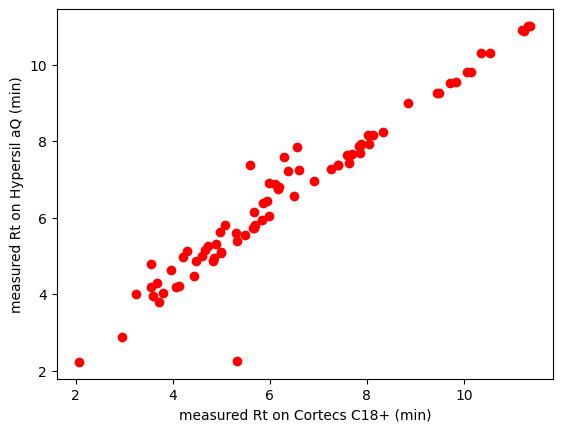

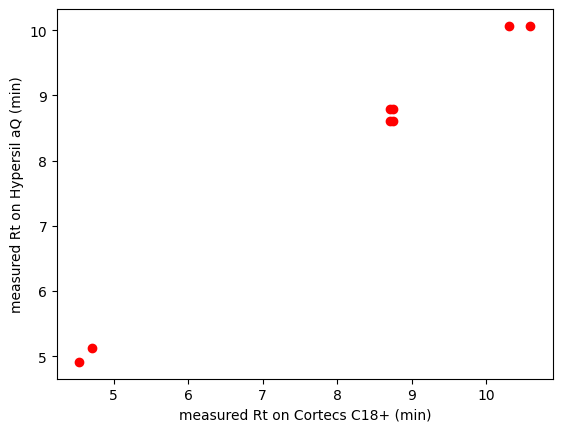

(77, 1)
(77, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Cortecs C18+
Kinetix XB-C18


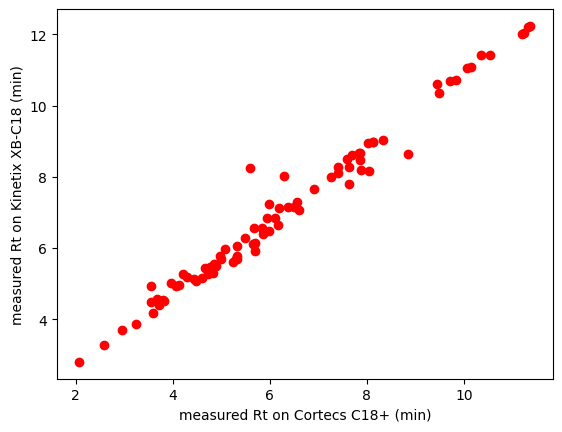

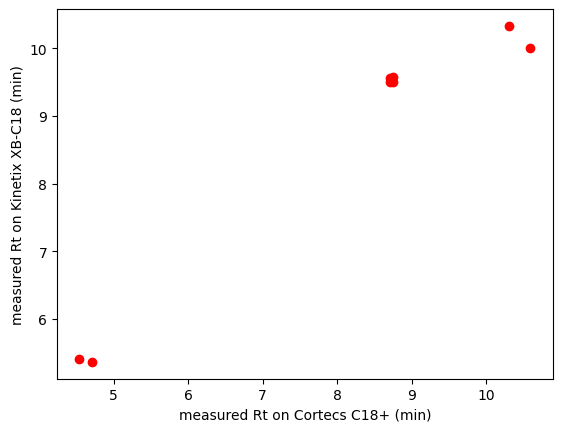

(83, 1)
(83, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Cortecs C18+
Poroshell EC-C18


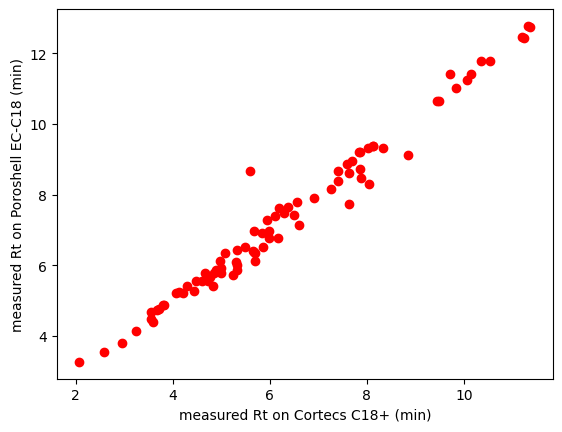

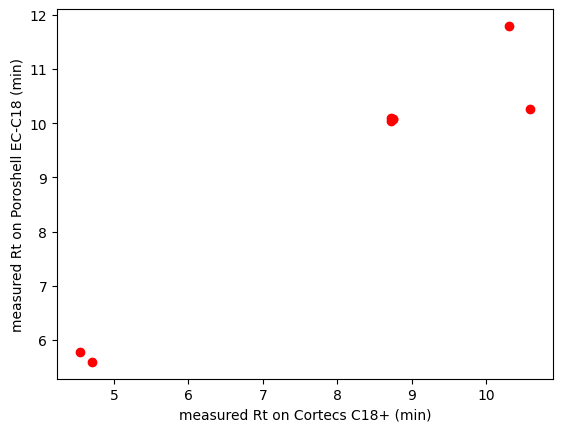

(83, 1)
(83, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Cortecs C18+
Poroshell SB-AQ


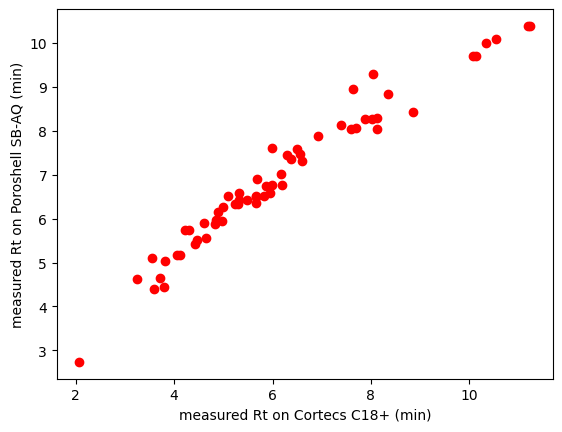

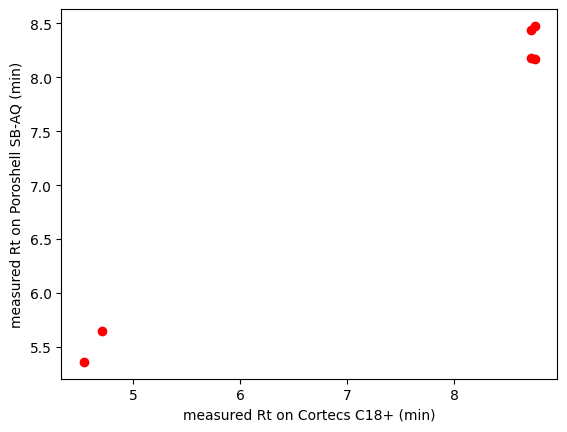

(60, 1)
(60, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Cortecs C18+
Shield RP18


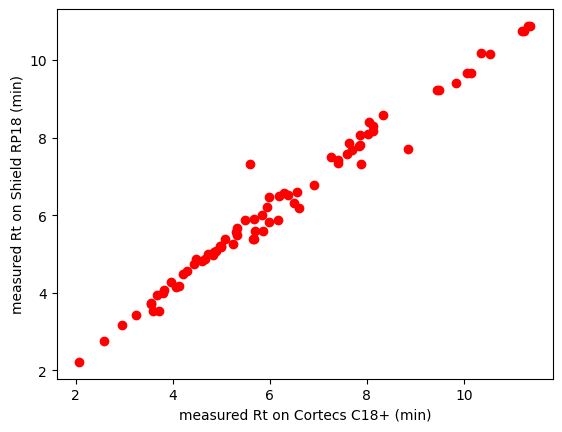

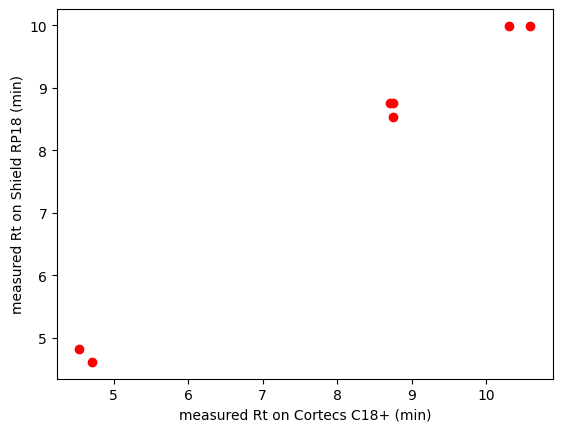

(78, 1)
(78, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Cortecs C18+
Zorbax Extend C18


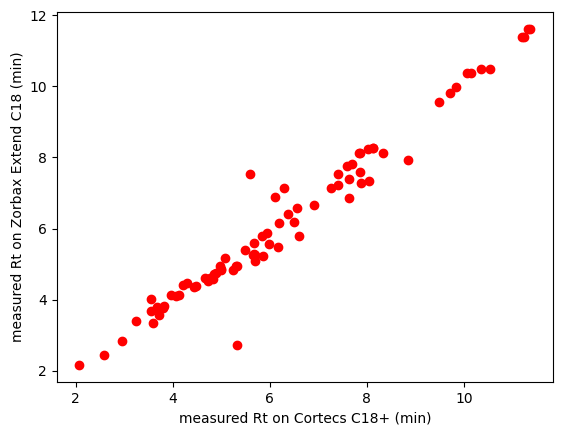

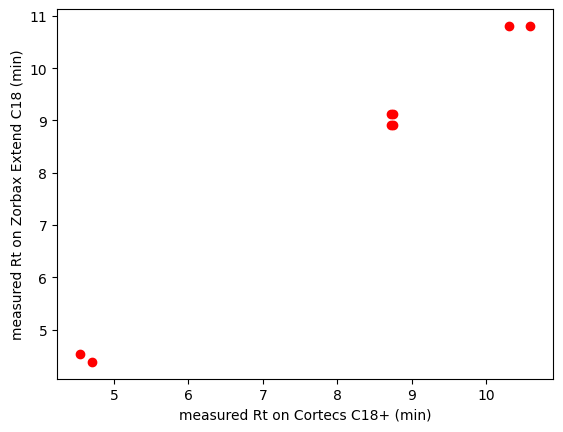

(80, 1)
(80, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Cortecs C18+
Zorbax SB C8


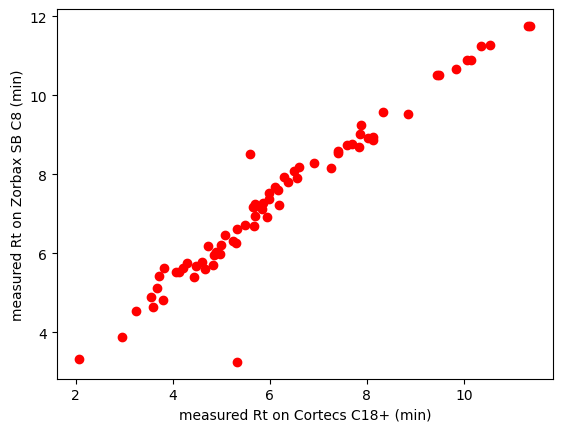

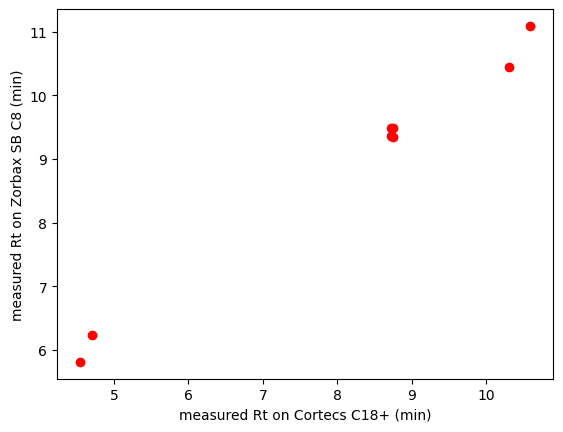

(71, 1)
(71, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Cortecs C18+
Zorbax SB-CN


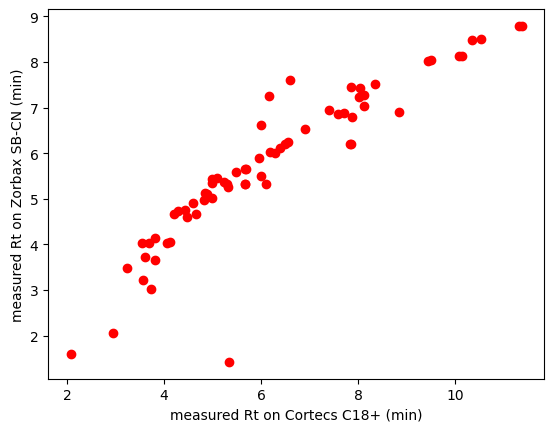

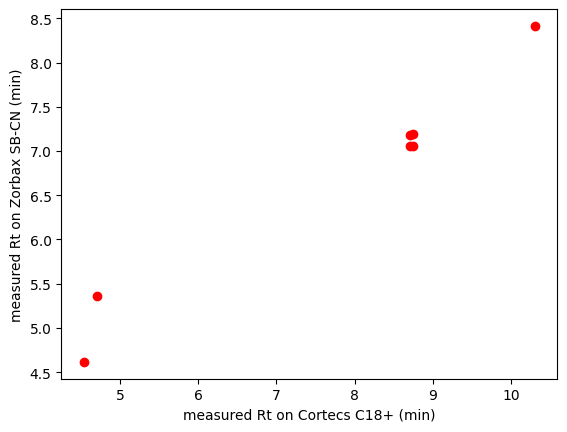

(67, 1)
(67, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Eclipse RRHD Plus C18
Hypersil PFP


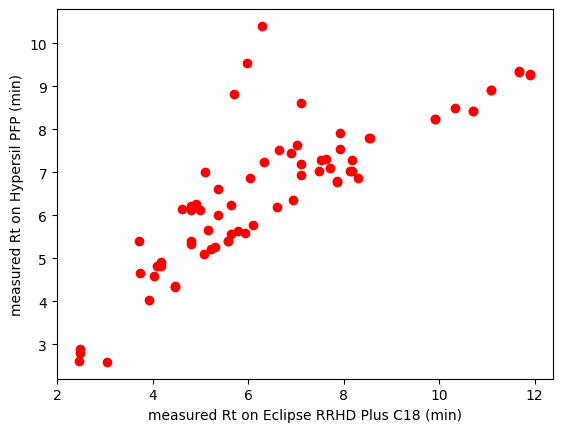

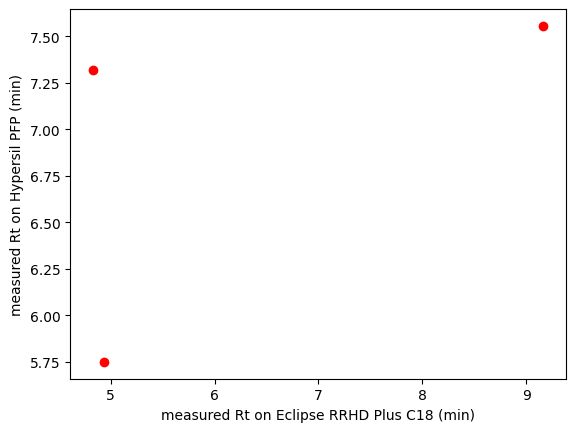

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Eclipse RRHD Plus C18
Hypersil aQ


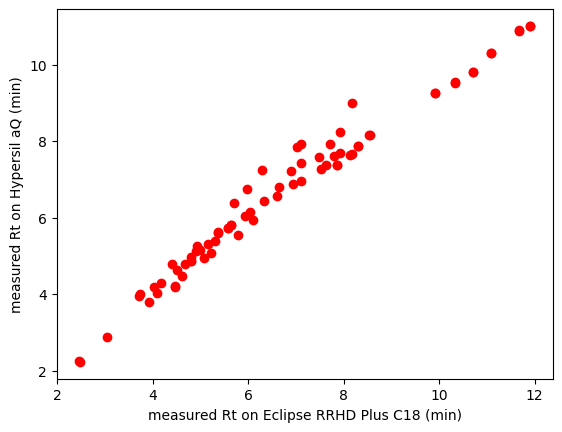

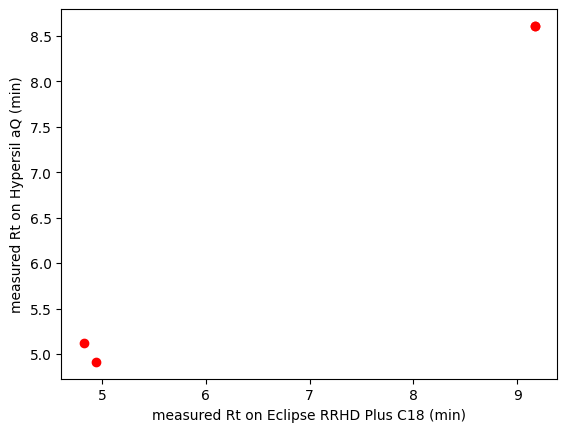

(75, 1)
(75, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Eclipse RRHD Plus C18
Kinetix XB-C18


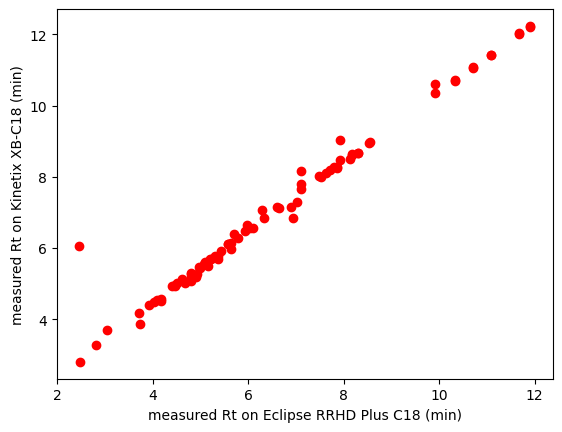

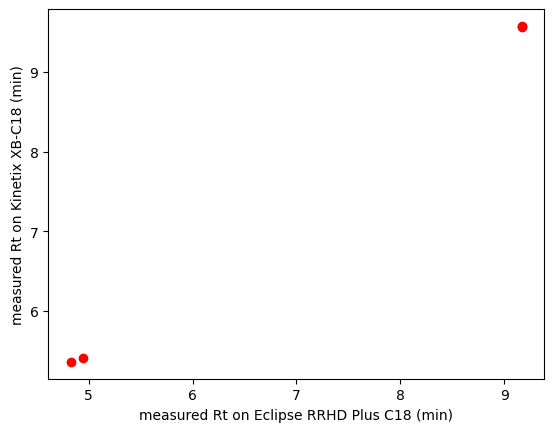

(82, 1)
(82, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Eclipse RRHD Plus C18
Poroshell EC-C18


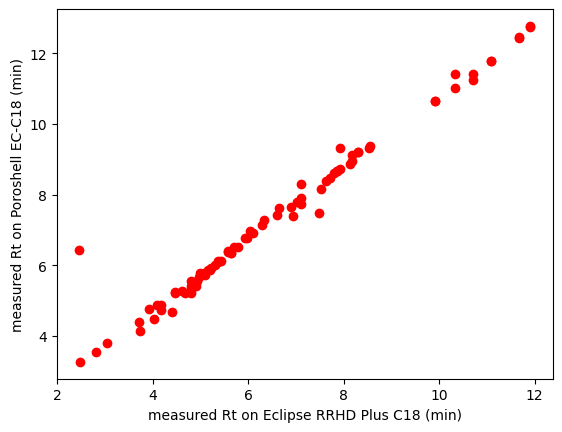

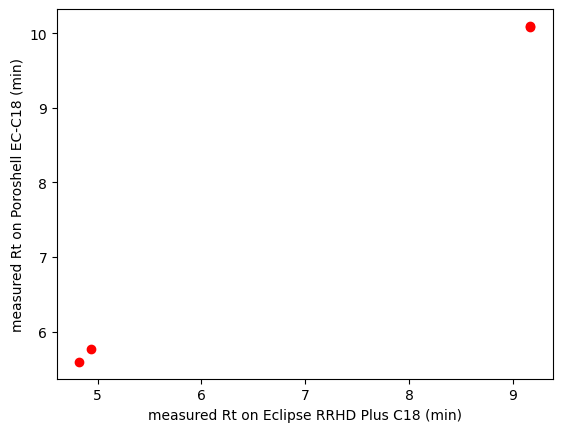

(81, 1)
(81, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step
Eclipse RRHD Plus C18
Poroshell SB-AQ


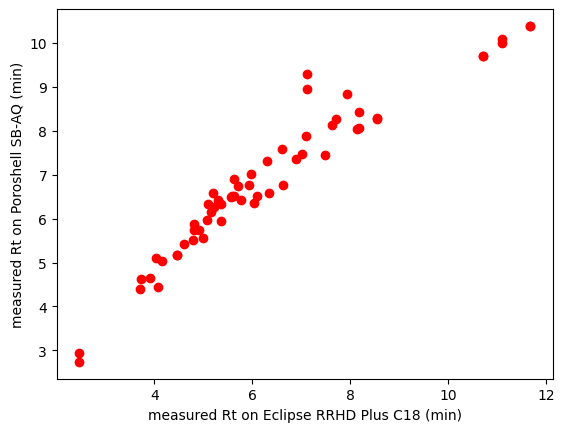

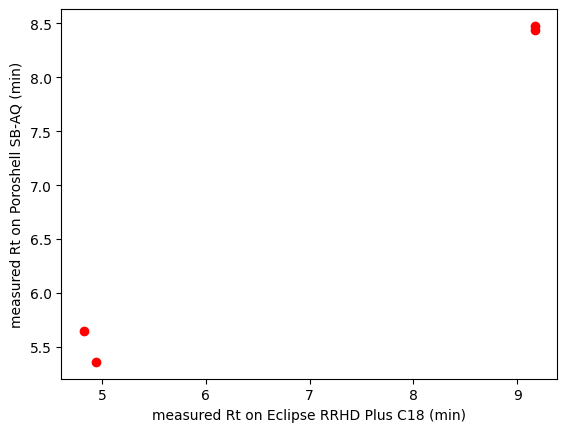

(58, 1)
(58, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Eclipse RRHD Plus C18
Shield RP18


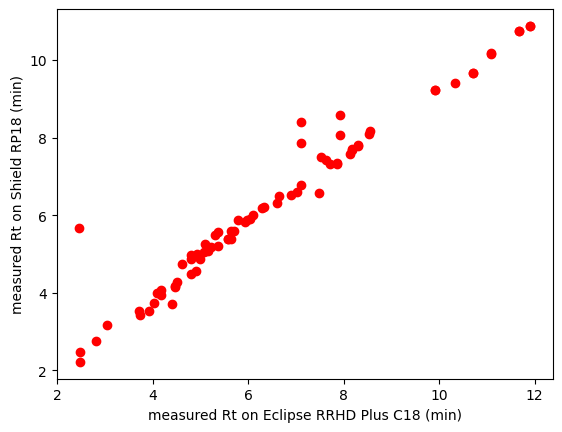

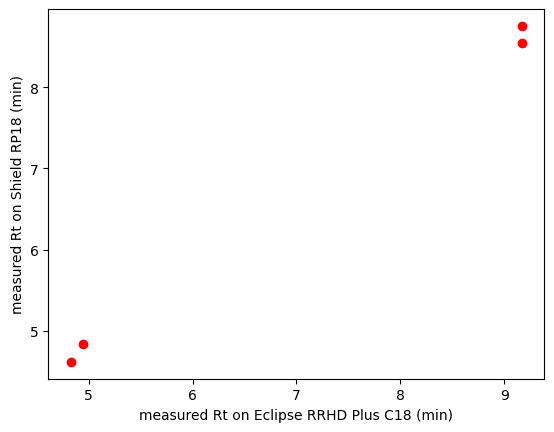

(75, 1)
(75, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 92ms/step
Eclipse RRHD Plus C18
Zorbax Extend C18


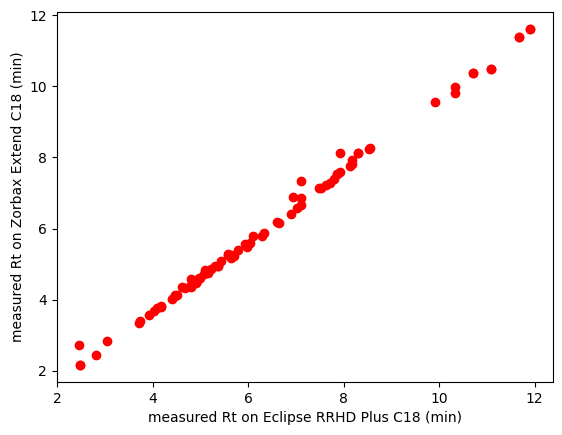

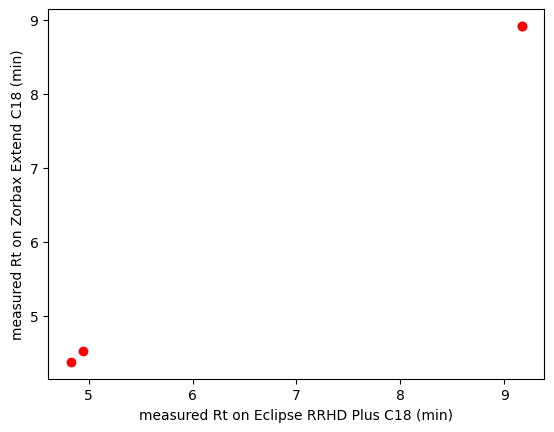

(81, 1)
(81, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 69ms/step
Eclipse RRHD Plus C18
Zorbax SB C8


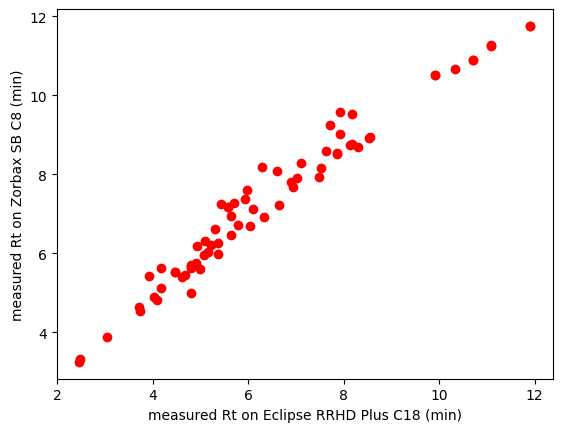

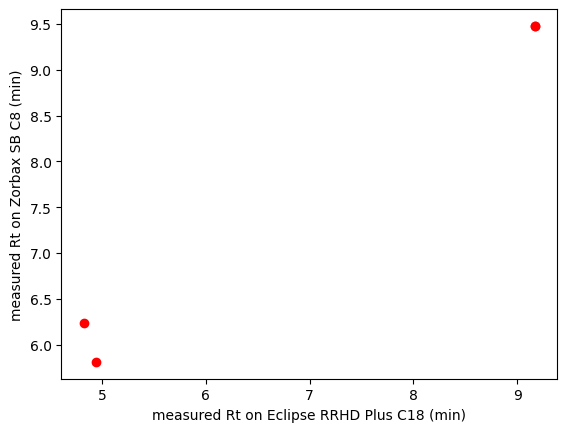

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Eclipse RRHD Plus C18
Zorbax SB-CN


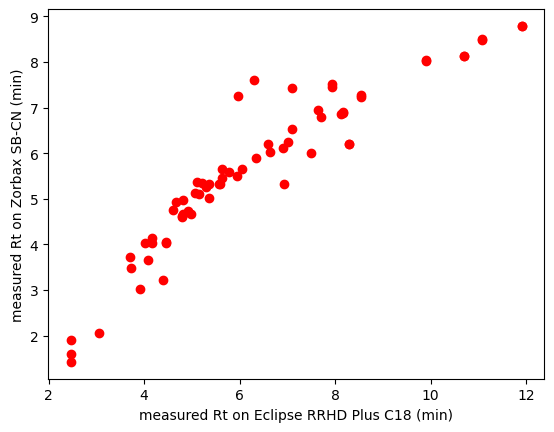

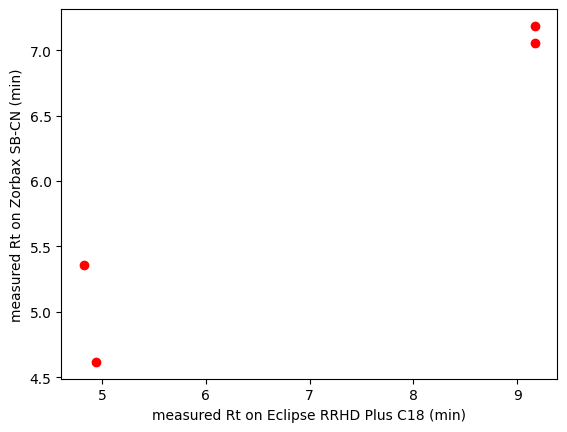

(66, 1)
(66, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Hypersil PFP
Hypersil aQ


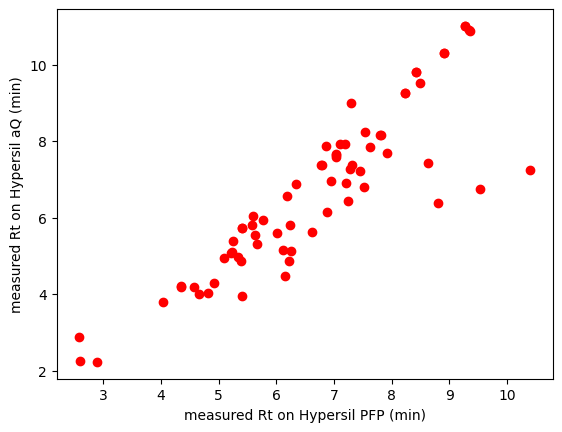

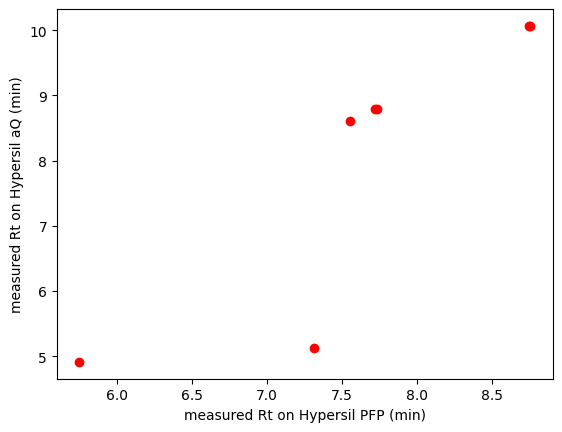

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Hypersil PFP
Kinetix XB-C18


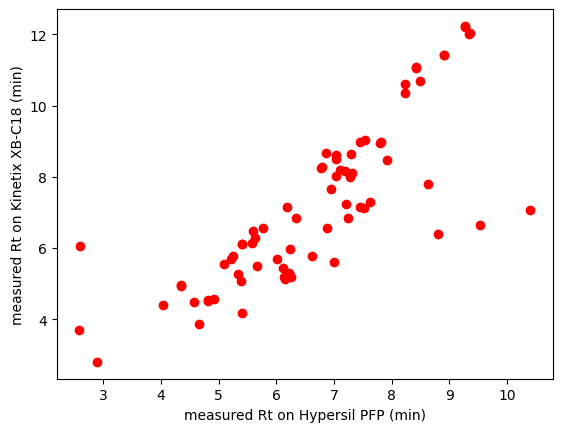

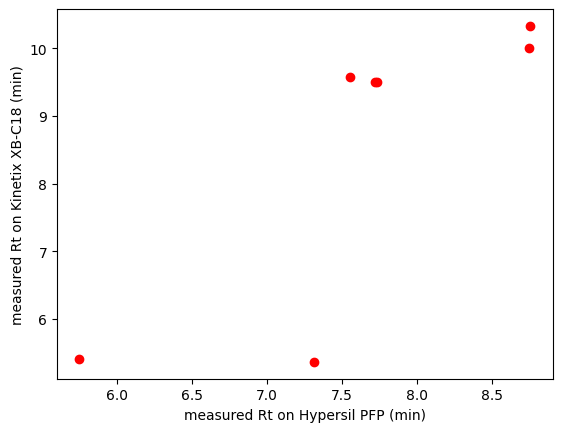

(73, 1)
(73, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Hypersil PFP
Poroshell EC-C18


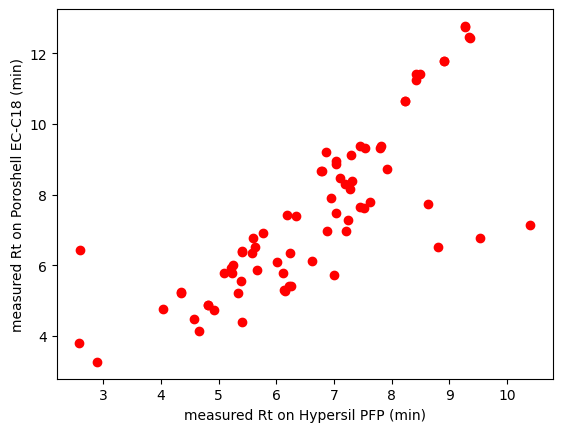

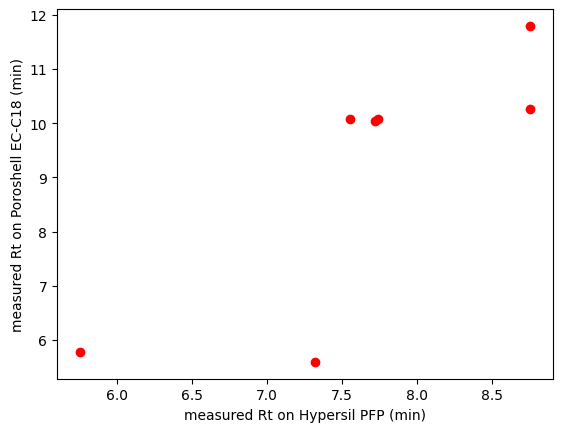

(74, 1)
(74, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Hypersil PFP
Poroshell SB-AQ


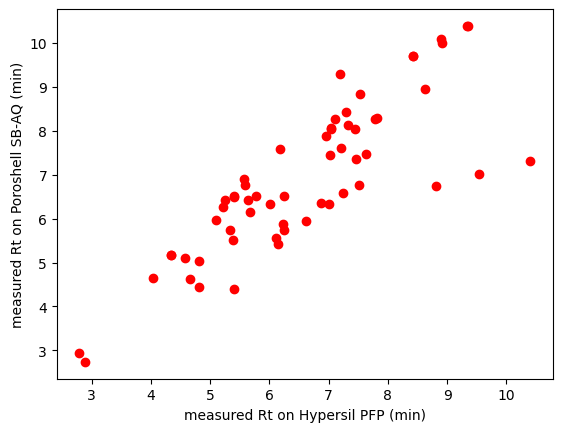

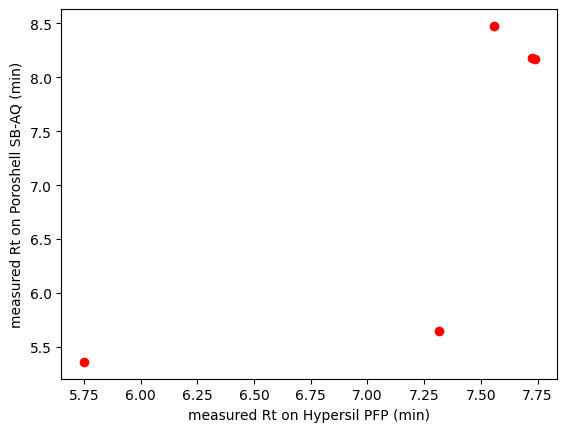

(59, 1)
(59, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Hypersil PFP
Shield RP18


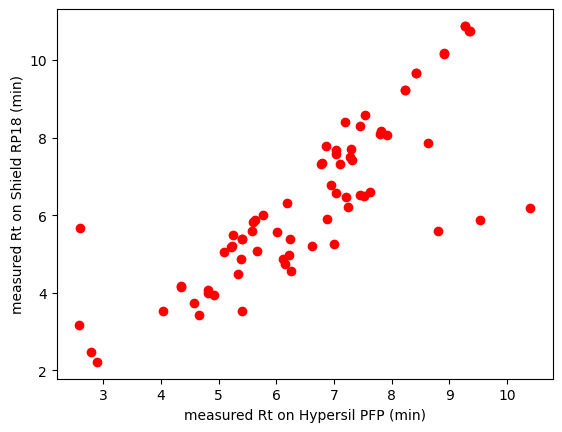

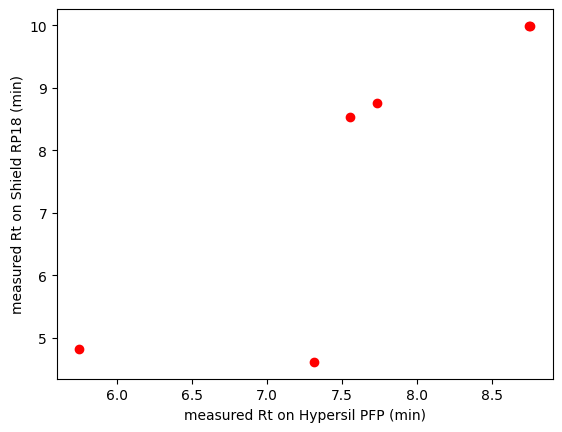

(72, 1)
(72, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Hypersil PFP
Zorbax Extend C18


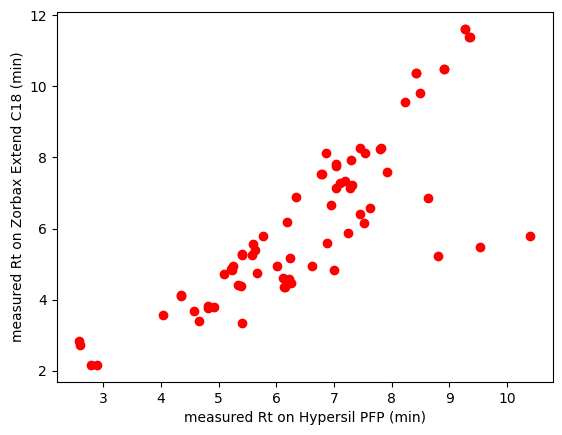

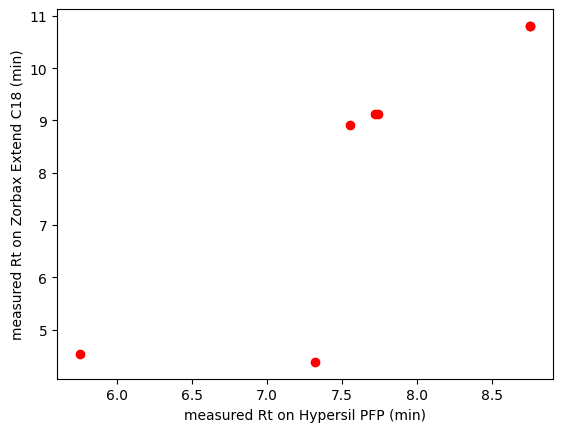

(73, 1)
(73, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Hypersil PFP
Zorbax SB C8


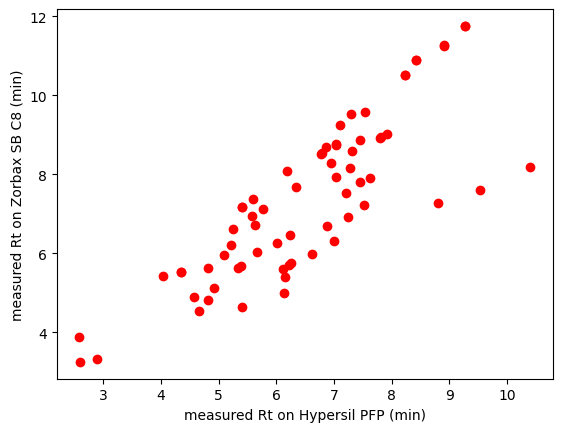

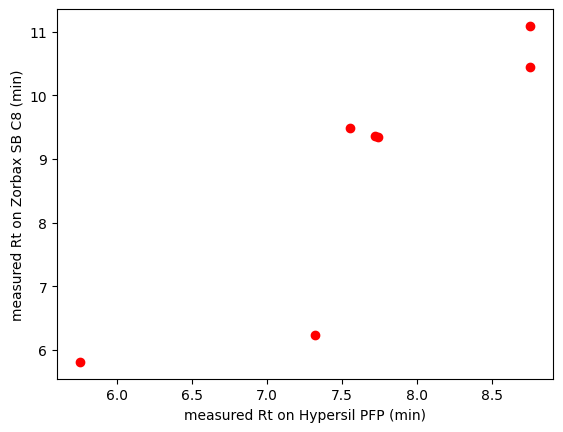

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Hypersil PFP
Zorbax SB-CN


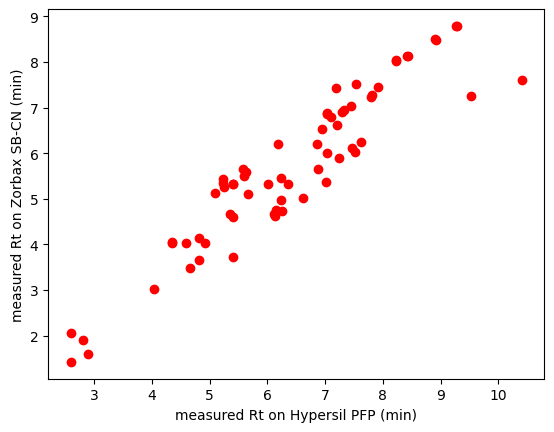

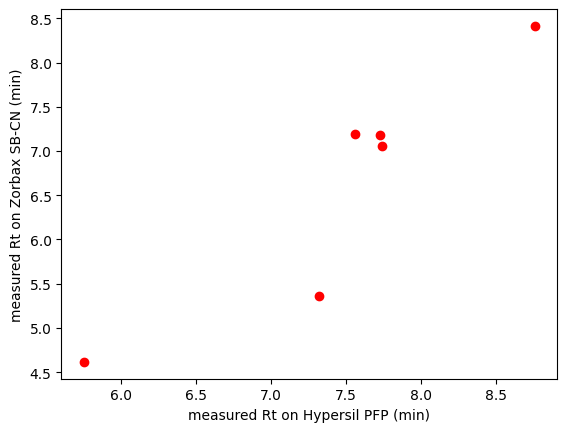

(66, 1)
(66, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Hypersil aQ
Kinetix XB-C18


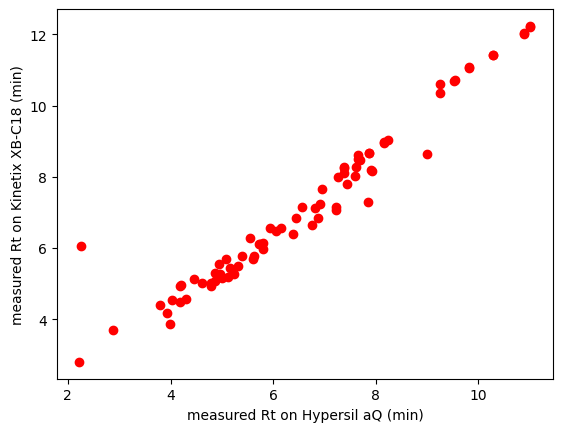

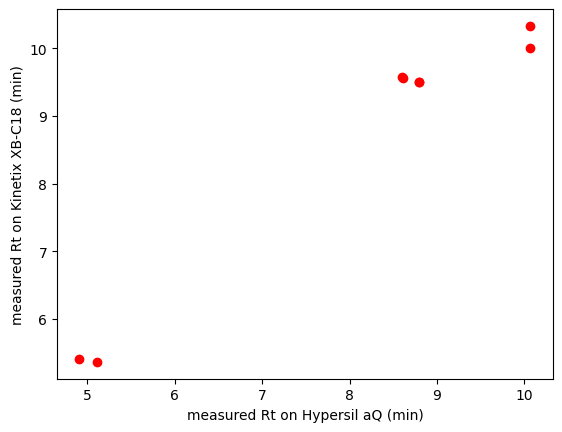

(77, 1)
(77, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Hypersil aQ
Poroshell EC-C18


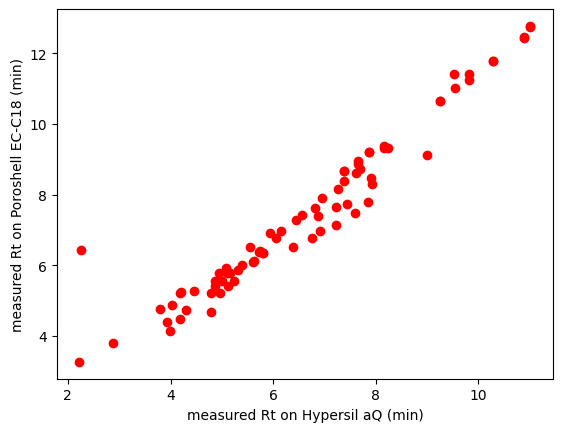

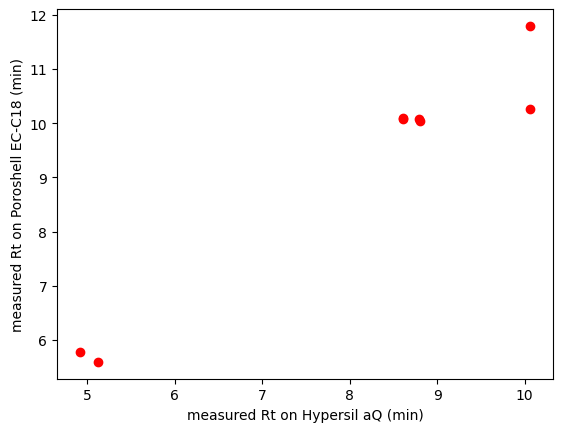

(77, 1)
(77, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Hypersil aQ
Poroshell SB-AQ


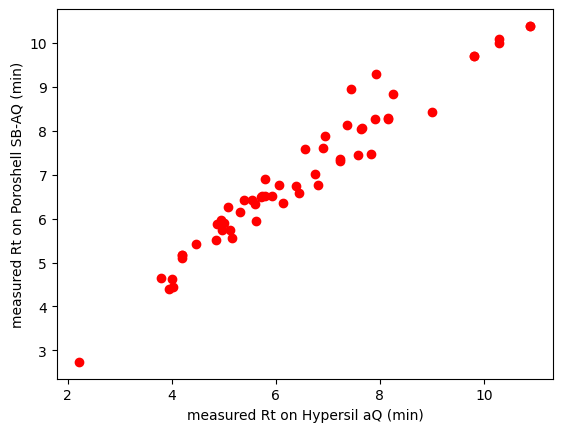

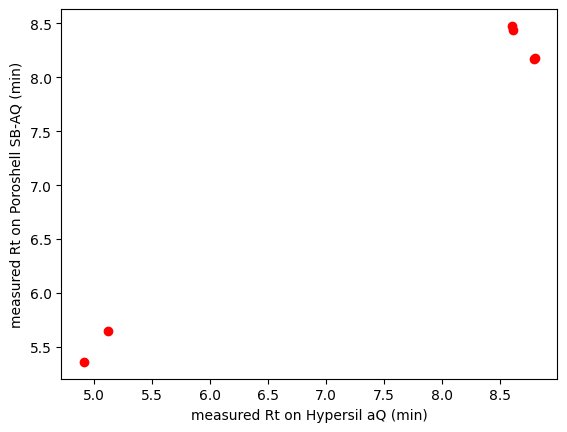

(56, 1)
(56, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Hypersil aQ
Shield RP18


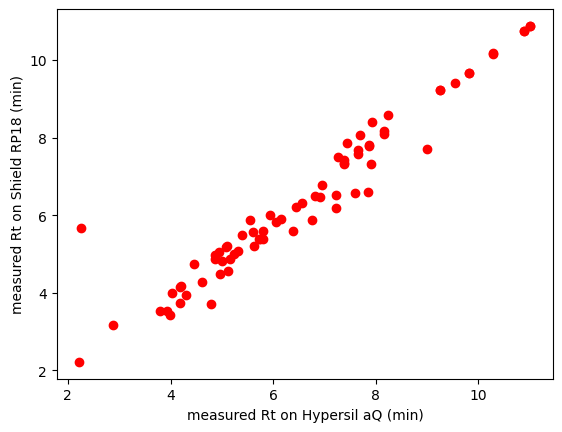

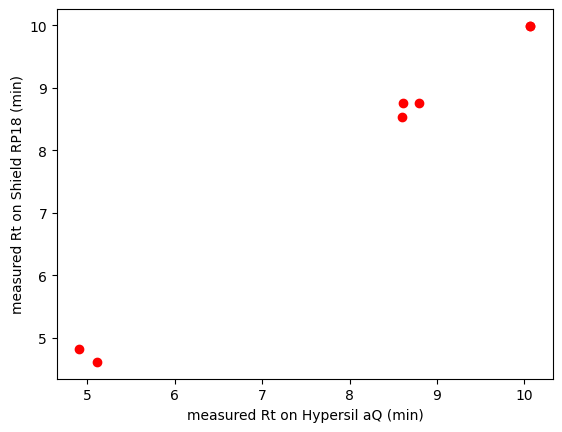

(74, 1)
(74, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Hypersil aQ
Zorbax Extend C18


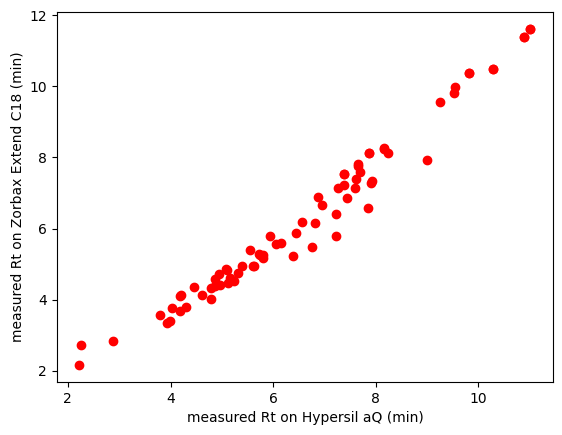

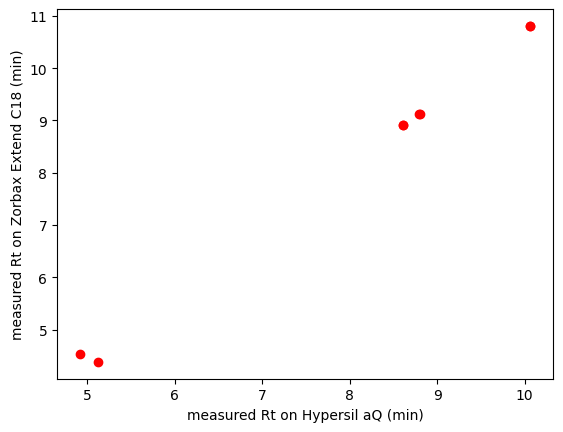

(75, 1)
(75, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Hypersil aQ
Zorbax SB C8


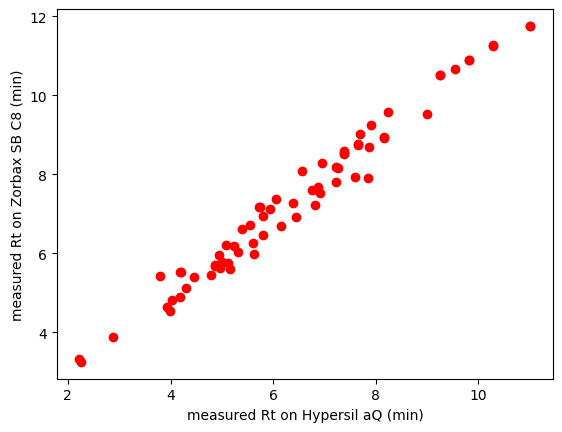

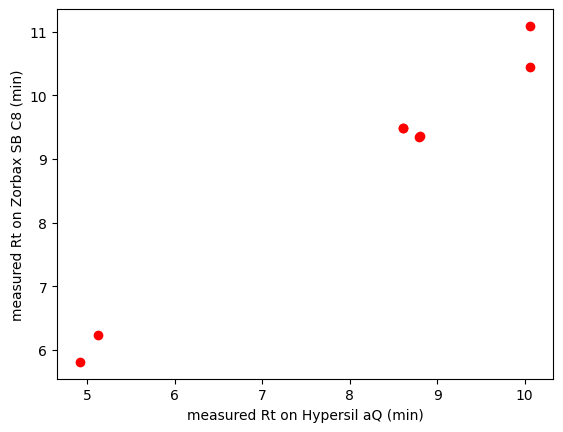

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Hypersil aQ
Zorbax SB-CN


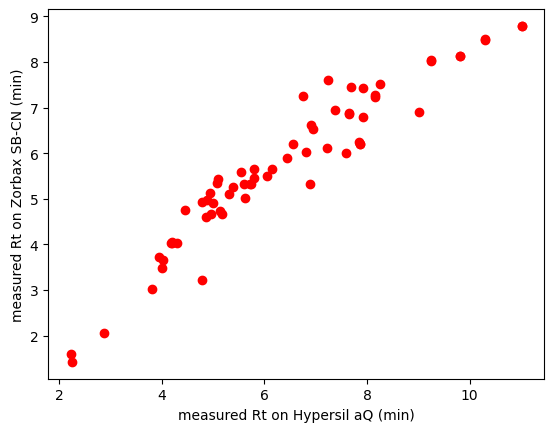

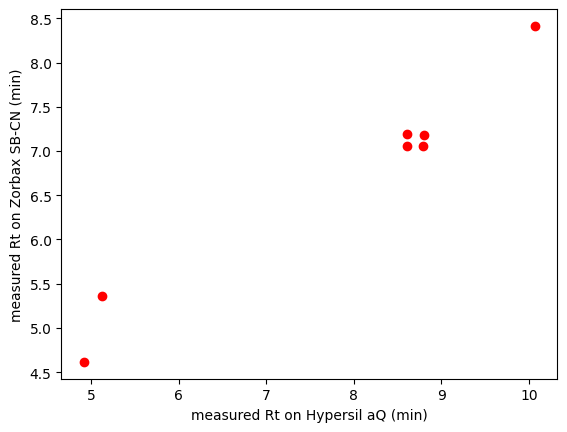

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Kinetix XB-C18
Poroshell EC-C18


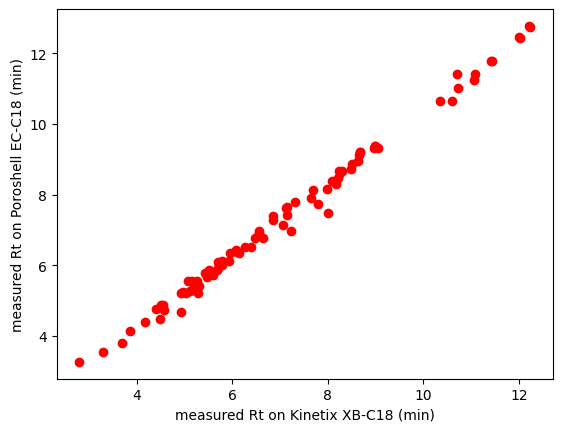

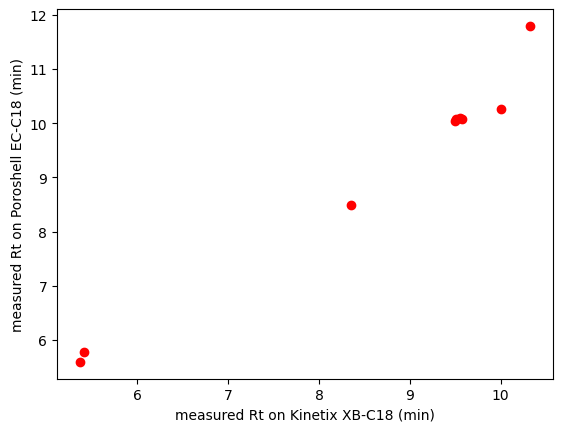

(85, 1)
(85, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 66ms/step
Kinetix XB-C18
Poroshell SB-AQ


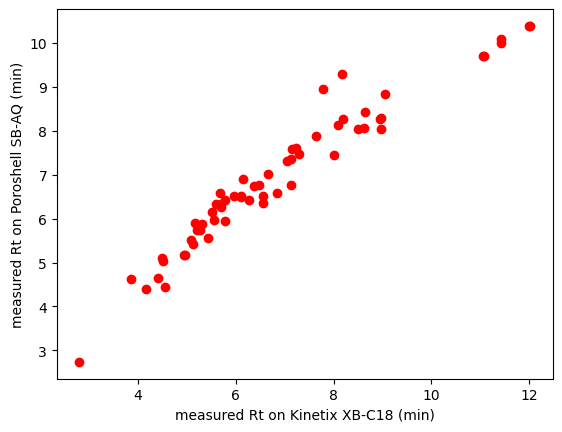

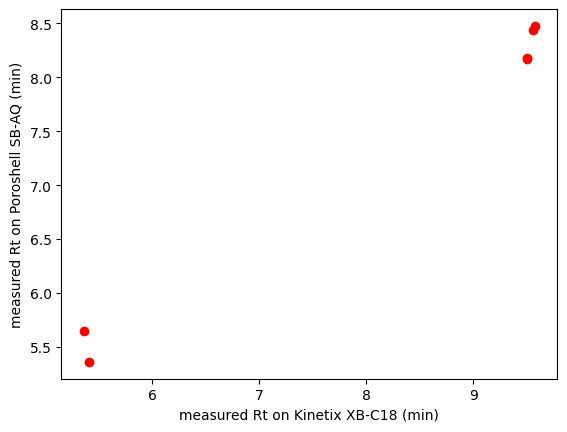

(60, 1)
(60, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Kinetix XB-C18
Shield RP18


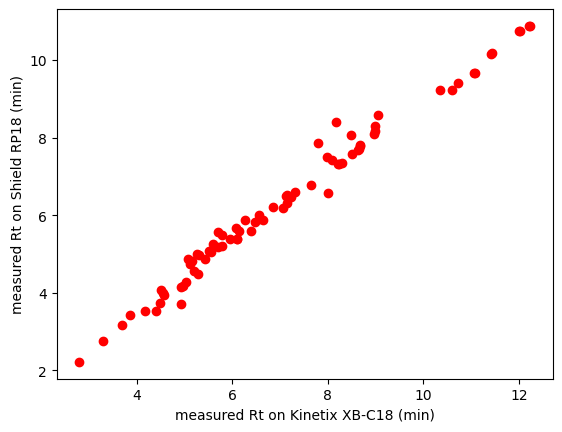

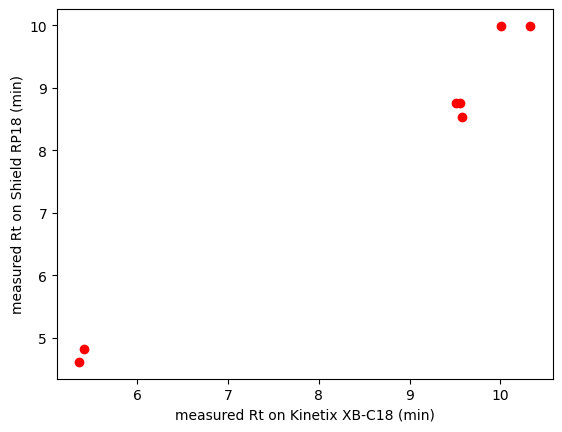

(77, 1)
(77, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Kinetix XB-C18
Zorbax Extend C18


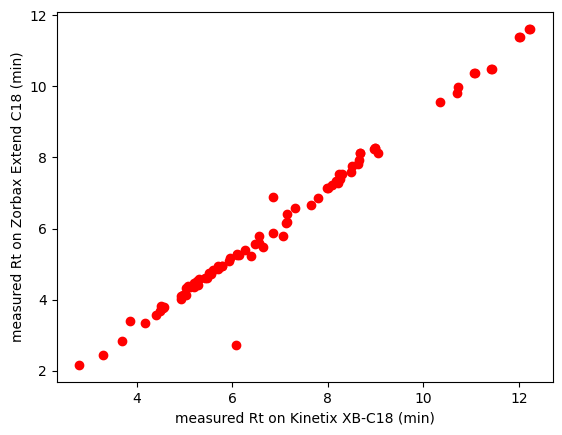

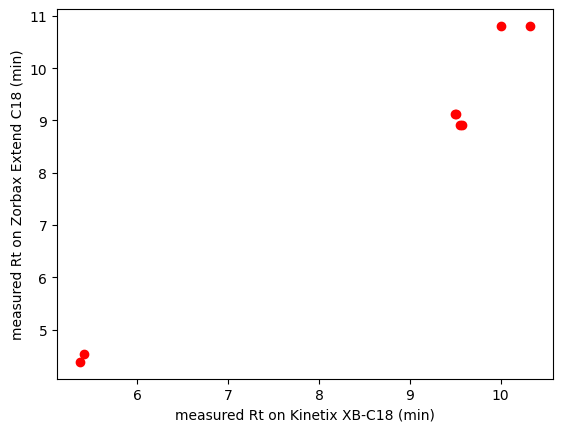

(81, 1)
(81, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Kinetix XB-C18
Zorbax SB C8


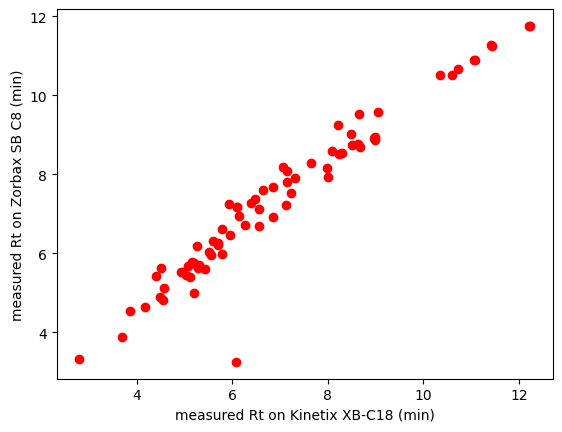

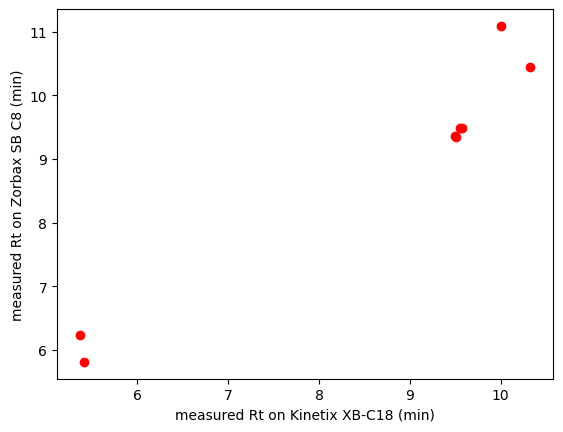

(73, 1)
(73, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Kinetix XB-C18
Zorbax SB-CN


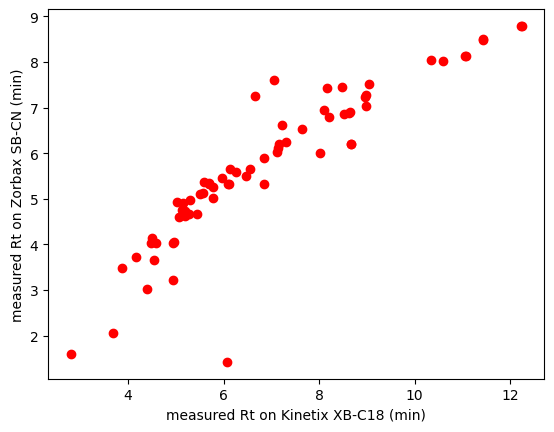

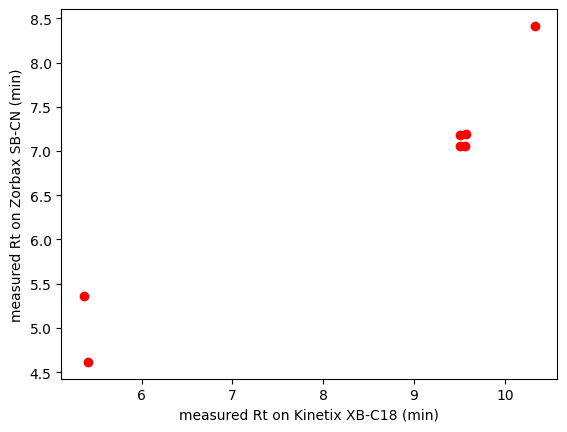

(68, 1)
(68, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Poroshell EC-C18
Poroshell SB-AQ


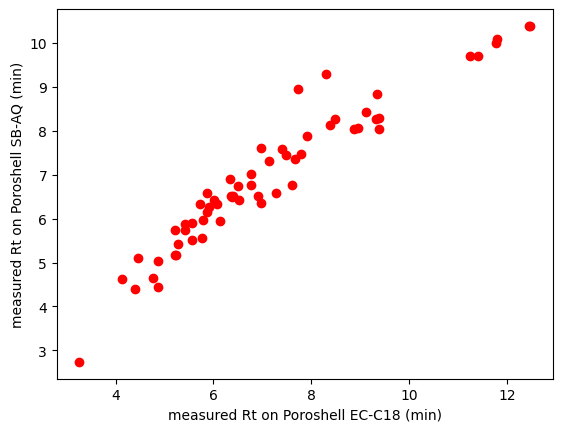

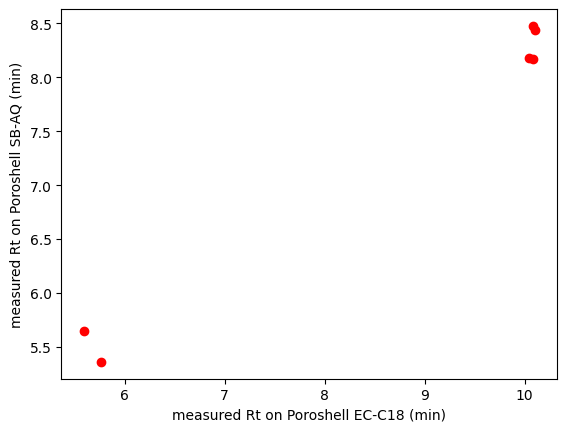

(60, 1)
(60, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Poroshell EC-C18
Shield RP18


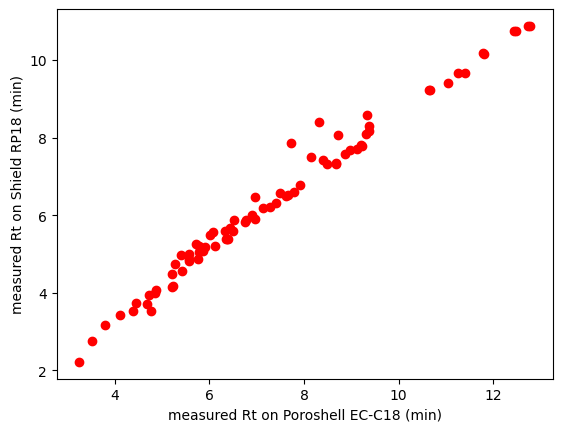

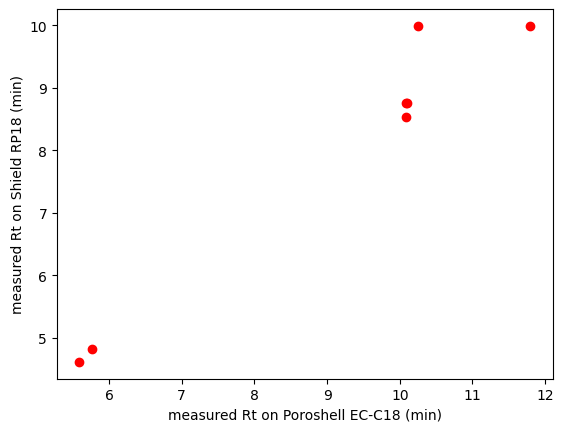

(77, 1)
(77, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Poroshell EC-C18
Zorbax Extend C18


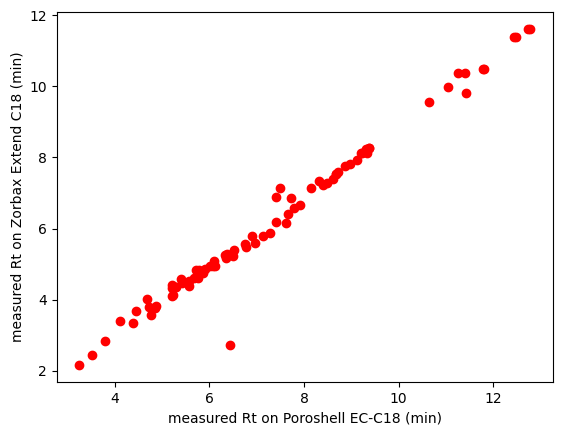

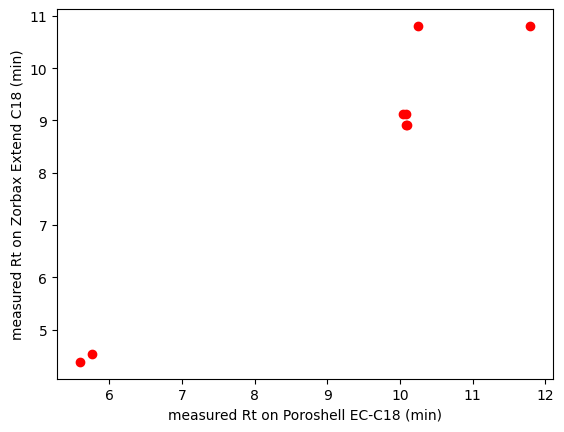

(81, 1)
(81, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Poroshell EC-C18
Zorbax SB C8


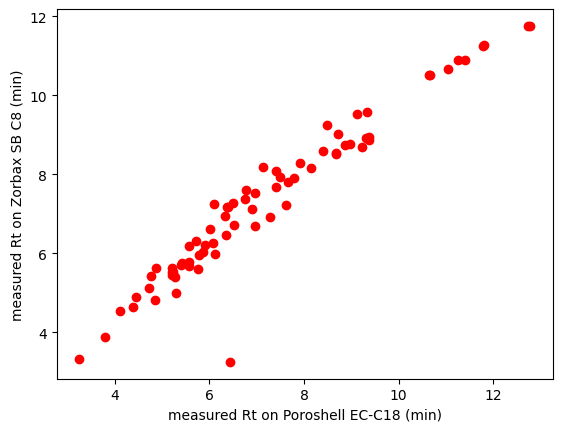

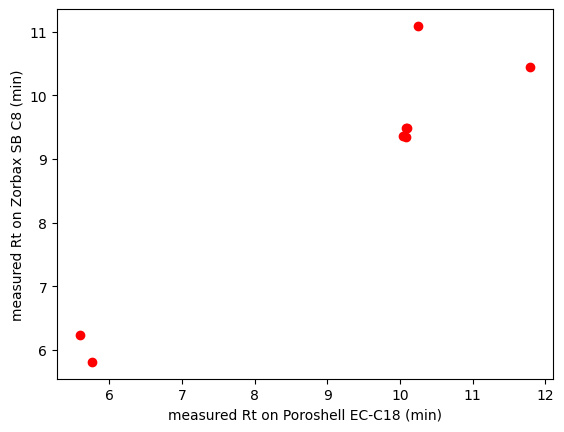

(73, 1)
(73, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Poroshell EC-C18
Zorbax SB-CN


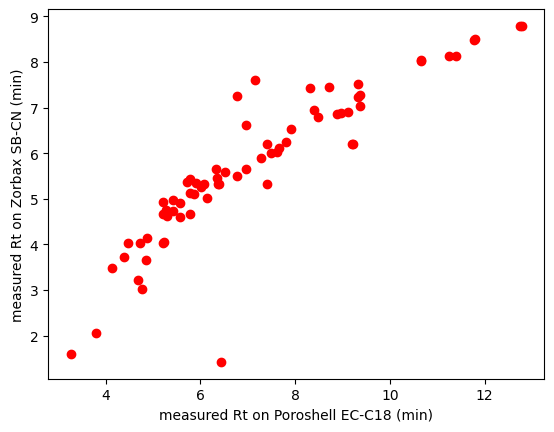

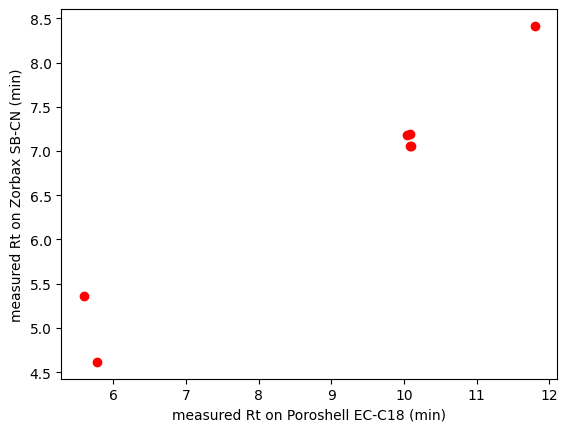

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Poroshell SB-AQ
Shield RP18


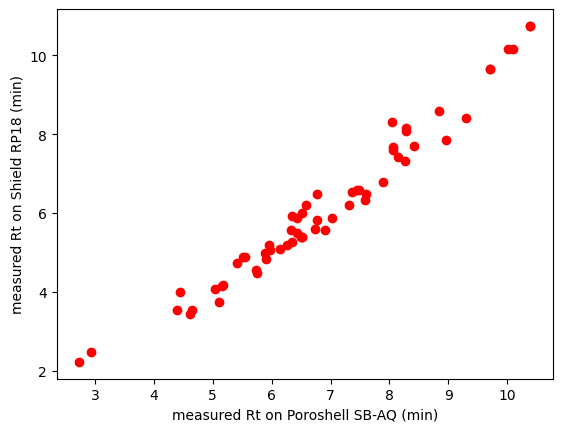

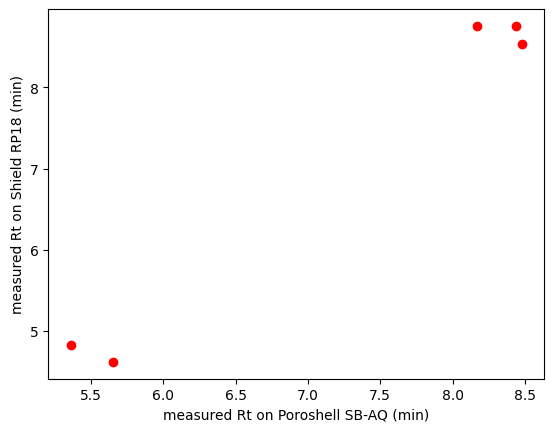

(60, 1)
(60, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Poroshell SB-AQ
Zorbax Extend C18


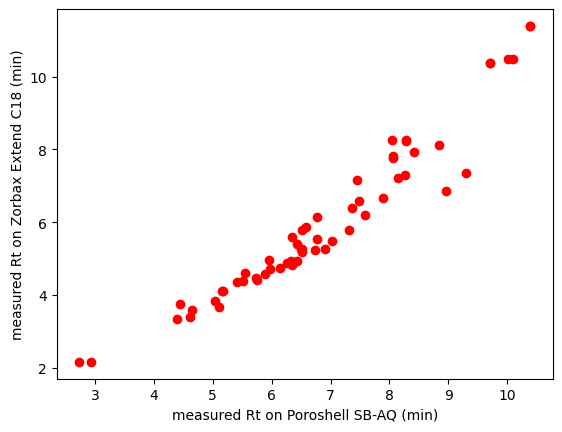

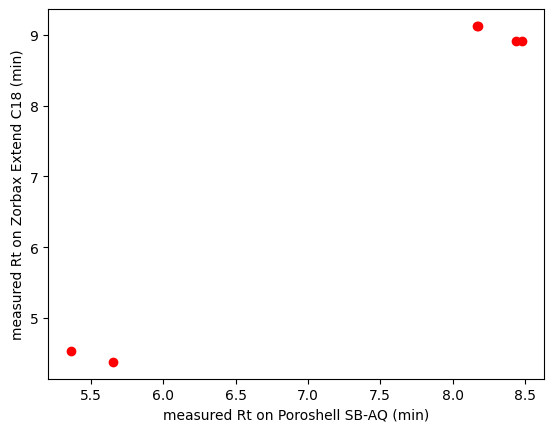

(58, 1)
(58, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Poroshell SB-AQ
Zorbax SB C8


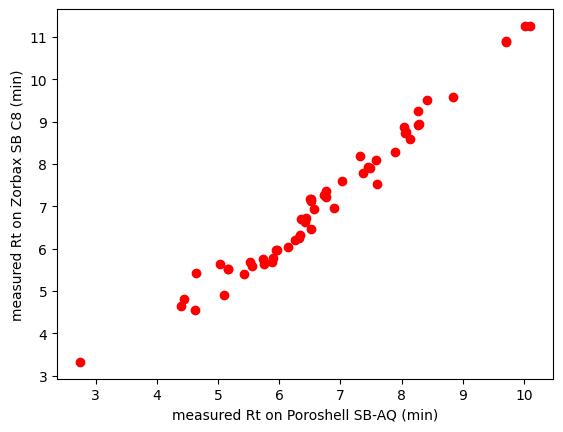

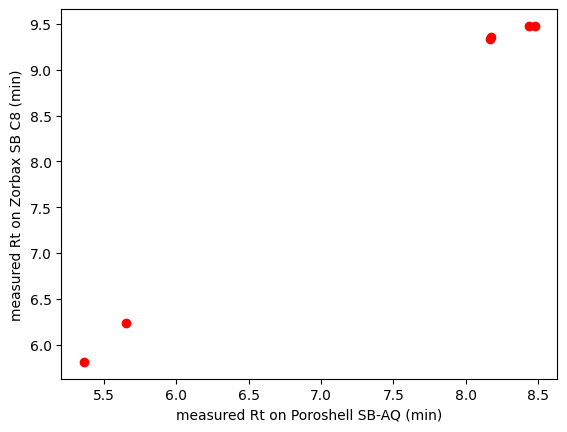

(55, 1)
(55, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Poroshell SB-AQ
Zorbax SB-CN


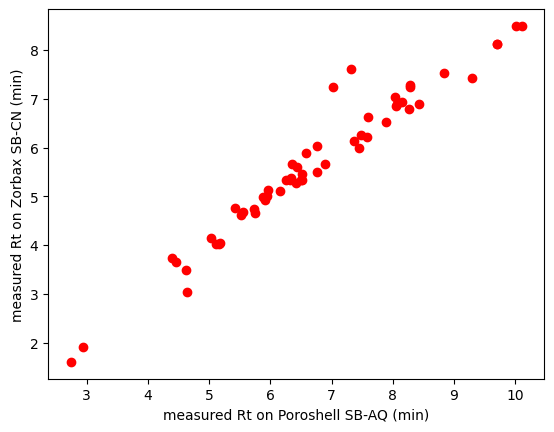

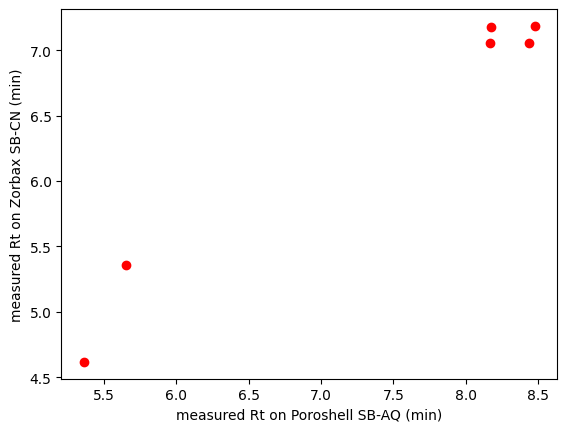

(55, 1)
(55, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 62ms/step
Shield RP18
Zorbax Extend C18


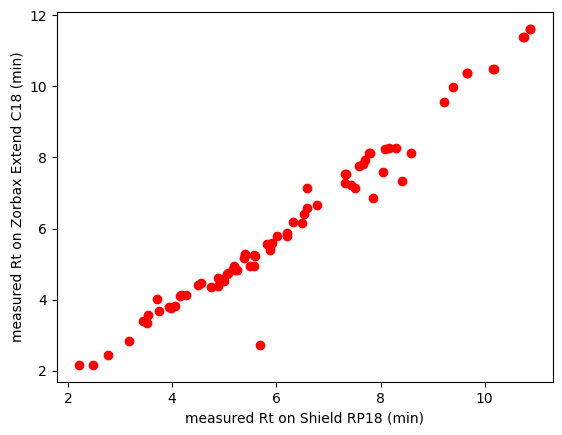

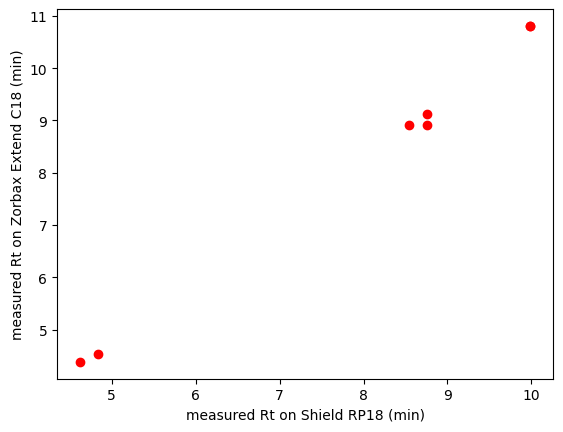

(76, 1)
(76, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Shield RP18
Zorbax SB C8


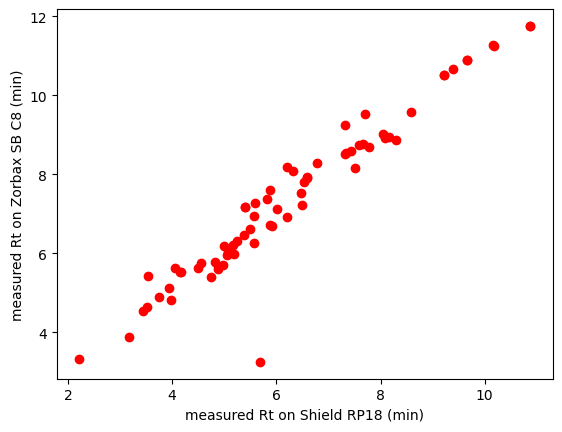

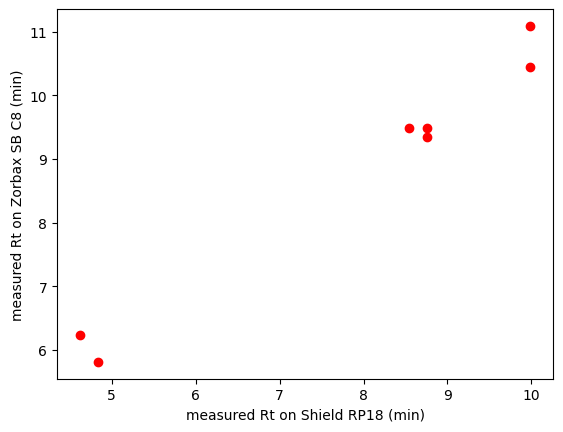

(69, 1)
(69, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Shield RP18
Zorbax SB-CN


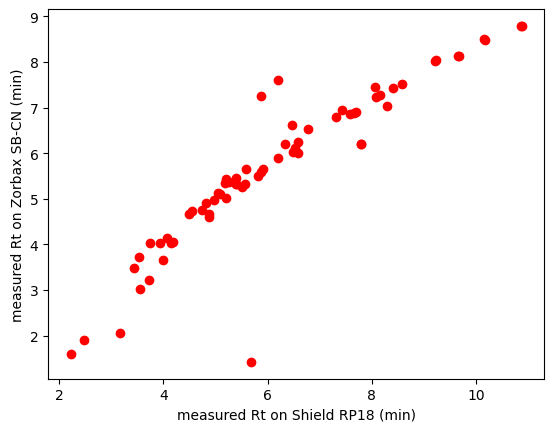

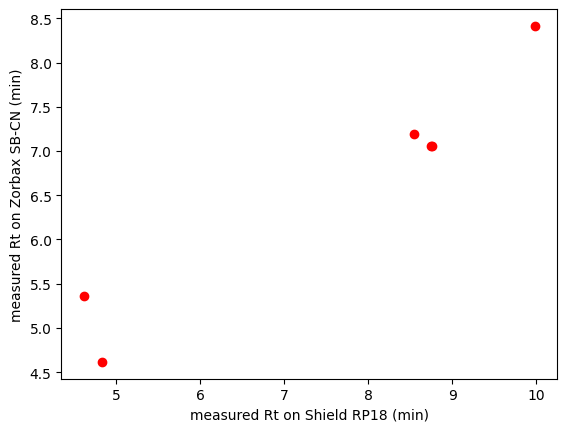

(67, 1)
(67, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 63ms/step
Zorbax Extend C18
Zorbax SB C8


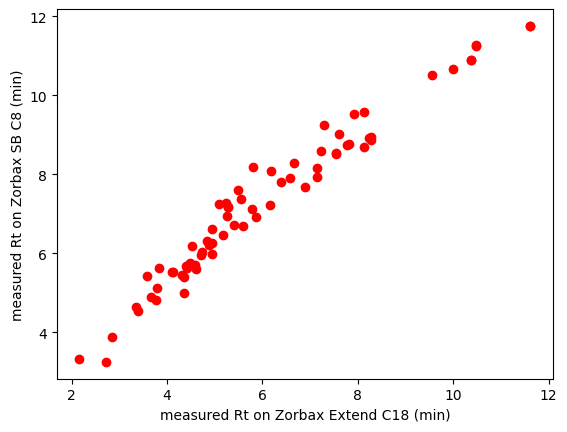

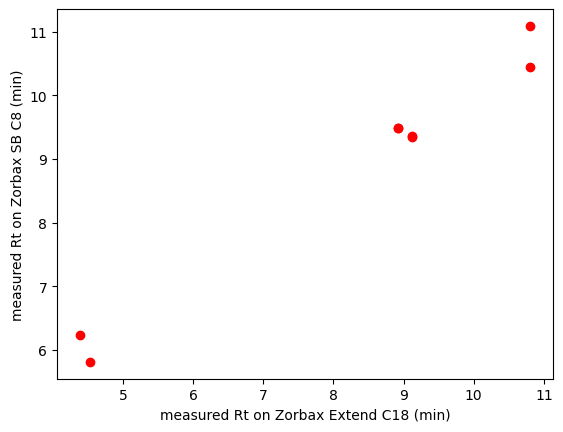

(70, 1)
(70, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Zorbax Extend C18
Zorbax SB-CN


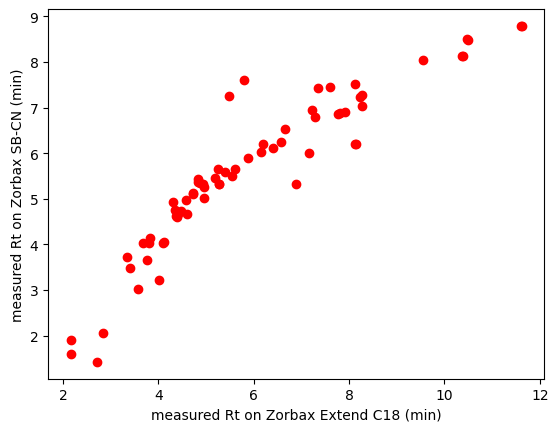

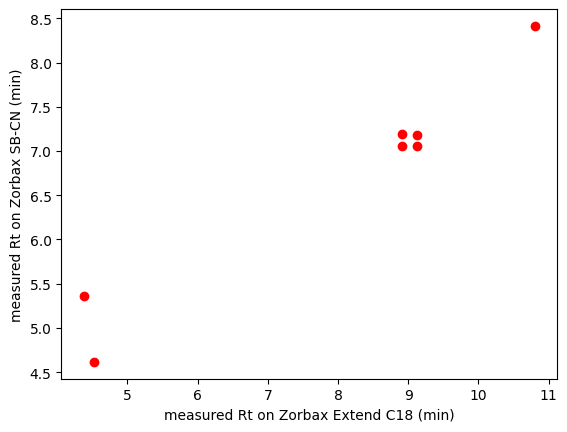

(67, 1)
(67, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 78ms/step
Zorbax SB C8
Zorbax SB-CN


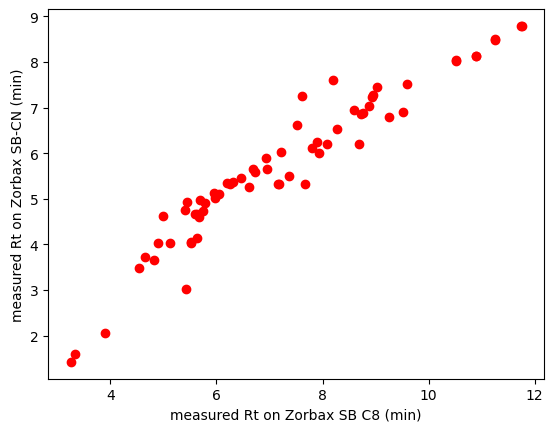

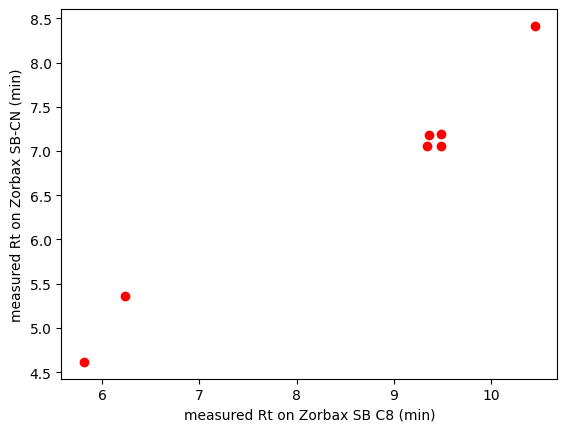

(65, 1)
(65, 1)


C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
C:\Users\shiz16\.conda\envs\TF\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


1/1 [==============================] - 0s 94ms/step


TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [65]:
ind_table_90pct=pd.DataFrame(comb, columns = ['Project','Column','Gnum'])
ind_table_10pct=pd.DataFrame(test, columns = ['Project','Column','Gnum'])
X_CAL = comb.drop(['Project','Column','Gnum','tR (min)'], axis=1)
Y_CAL = np.asarray(y).astype('float32')
X_CAL = np.asarray(X_CAL).astype('float32')

X_TEST = test.drop(['Project','Column','Gnum','tR (min)'], axis=1)
Y_TEST = np.asarray(y_test).astype('float32')
X_TEST = np.asarray(X_TEST).astype('float32')

OUTPUT=COLUMN_TRANSFER_TABLE_90_10(X_CAL, Y_CAL, X_TEST, Y_TEST, ind_table_90pct, ind_table_10pct)


In [83]:
columnA=[]
columnB=[]
samp=[]
R2=[]
rmse_LR=[]
rmse_ANN=[]

for i in range(len(OUTPUT['LABEL'])):
    columnA.append(OUTPUT['LABEL'][i][0])
    columnB.append(OUTPUT['LABEL'][i][1])
    samp.append(OUTPUT['METRIC'][i][0])
    R2.append(OUTPUT['METRIC'][i][1])
    rmse_LR.append(OUTPUT['METRIC'][i][2])
    rmse_ANN.append(OUTPUT['METRIC'][i][3])
    
columnA=pd.DataFrame(columnA,columns=['columnA'])
columnB=pd.DataFrame(columnB,columns=['columnB'])
samp=pd.DataFrame(samp,columns=['# of samp'])
R2=pd.DataFrame(R2,columns=['R2'])
rmse_LR=pd.DataFrame(samp,columns=['rmse_LR'])
rmse_ANN=pd.DataFrame(rmse_ANN,columns=['rmse_ANN'])

results = pd.concat([columnA, columnB, samp, R2, rmse_LR, rmse_ANN],axis=1)

results.to_csv('COLUMN_TRANSFER_90_10.csv')
